## Importing Necessary Libraries

Importing all the necessary libraries required.

In [379]:
import os
import math
import time
import copy
import random
import numpy as np
from tqdm import tqdm
from datetime import datetime
# from torchviz import make_dot
import matplotlib.pyplot as plt

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image

from pycocotools.coco import COCO
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel, pipeline

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from pytorch_metric_learning import losses

import faiss

## Configure Data and Model

In this section set the data paths and other configurations for `trainloader`, `valloader`, `valset1` and `valset2`   (`valset1` contains the BottomsUp features and `valset2` contains the BERT features which are meant for evaluation) as follows:
- `root_dir`: Path to directory for images
- `ann_path`: Path to .json file containing annotations
- `feat_dir`: Path to directory containing BottomsUp image features for each image
- `text_dir`: Path to directory containing BERT's textual features for each annotation
- `batch_size`: The batch size for train loader

I am using the **Flickr30k Dataset**.

In [380]:
# Train DataLoader Configurations
trainloader_args = {
  'root_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/train.json",
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
  'text_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features",
  'batch_size': 32,
  'num_workers': 0
}

# Validation DataLoader Configurations
valloader_args = {
  'root_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json",
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
  'text_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features",
  'batch_size': 32, 
  'num_workers': 0
}

# Dataset for Metric Evaluation -Here I use the validation set itself for metric evaluation
valset1_args = { # BottomUp Features
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json"
}

# Dataset for Metric Evaluation -Here I use the validation set itself for metric evaluation
valset2_args = { # BERT Features
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json"
}

In [381]:
device = torch.device('mps') # Set it to 'cuda' for gpu or 'cpu' for cpu or 'mps' for M1

## Data Preparation

I define the class that will handle the custom datasets and dataloaders. The format in which the dataset of images and the annotation files are present is according to the COCO guidelines.

Make sure to have extracted the image and annotation features for the following class to function properly. The data directory tree is being provided below for reference. Suppose the folder containing all the data is named `data`.
```
data ───────────────────────────> Contains the Dataset and the relevant pre-computed features
├── bert_features ──────────────> Contains the BERT Features for the annotations in the Flickr30k Dataset
│   ├── 0.npz
│   ├── 1.npz
│   ├── 2.npz
│   ├── .....
│   └── 155069.npz ─────────────> BERT Features for the annotation text with ann_id = 155069
├── bottom_up ──────────────────> Contains the Bottom-up Features for all the annotations in the Flickr30k
│   ├── data_att
│   │   ├── 1000092795.npz
│   │   ├── 10002456.npz
│   │   ├── ...
│   │   └── 998845445.npz ──────> Bottom-Up Features for the image with image_id = 998845445
│   └── data_box
│       ├── 1000092795.npz
│       ├── 10002456.npz
│       ├── ...
│       └── 998845445.npz ──────> Bounding Box Features for the image with image_id = 998845445
├── flickr30k_annotations ──────> Contains the Annotation Files for the Flickr30k Dataset
│   ├── flickr30k_all.json ─────> Annotation File for the entire Flickr30k Images
│   ├── train.json ─────────────> Annotation File for the train Flickr30k Images 
│   └── val.json ───────────────> Annotation File for the validation Flickr30k Images 
└── flickr30k_images ───────────> Contains the Image Files for the Flickr30k Dataset
    └── flickr30k_images ───────> Ignore this directory
        ├── 1000092795.jpg
        ├── 10002456.jpg ───────> Images from the Flickr30k Dataset
        ├── ...
        └── 998845445.jpg
```

Above the name of the `<ann_id>.npz` in `bert_features` file corresponds to the annotation with the `ann_id` as `<ann_id>` and the name of the  `<image_id>.npz` in `bottom_up/data_att` and `bottom_up/data_box` corresponds to the image with the `image_id` as `<image_id>` in the `flickr30k_all.json` file which stores the data as per the `COCO .json` guidelines.

### Bottom-Up Features Storage

Below we see how the data in the .npz files are organized. `data_box` folder contains the coordinates of the bounding box.

In [382]:
data1 = np.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up/data_box/36979.npz')

In [383]:
data1['feat'].shape

(36, 5)

In [384]:
data1['feat'][:5] # First 5 out of 36 bounding boxes for one of the images

array([[103.83716583,  55.41079712, 144.81468201,  99.13117218,
        545.        ],
       [110.3965683 , 146.09048462, 361.76617432, 286.25769043,
        106.        ],
       [135.88619995, 173.63604736, 415.54824829, 335.27069092,
        106.        ],
       [251.71195984,  40.11985779, 356.18463135, 211.74856567,
         50.        ],
       [  0.        ,  70.35986328, 101.263237  , 179.20793152,
        119.        ]])

`data_att` folder contains the features extracted from these bounding box.

In [385]:
data1 = np.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up/data_att/36979.npz')

In [386]:
data1['feat'].shape

(36, 2048)

In [387]:
data1['feat'][:5] # First 5 out of 36 bounding boxes' features for the same image as above

array([[0.0000000e+00, 6.2104285e-01, 1.0477988e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.0651214e-01],
       [5.0457919e-01, 7.7560830e-01, 0.0000000e+00, ..., 0.0000000e+00,
        6.0314050e+00, 5.8209195e+00],
       [2.8219435e-01, 1.8445037e-01, 0.0000000e+00, ..., 0.0000000e+00,
        9.9888259e-01, 7.9883933e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.6663906e-02,
        4.0683333e-02, 7.9872423e-01],
       [0.0000000e+00, 0.0000000e+00, 2.4023591e-04, ..., 0.0000000e+00,
        6.2136441e-01, 1.8564485e-01]], dtype=float32)

### BERT Feature Storage

`bert_features` folder contains the BERT-based (more specifically `distil-bert uncased`) features extracted from the annotations.

In [388]:
data1 = np.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features/0.npz')

In [389]:
data1['feat'].shape

(19, 768)

In [390]:
data1['feat'][:5] # First 5 out of 19 tokens' features for each annotation

array([[ 0.18091495, -0.17293406, -0.10586261, ..., -0.15721308,
         0.6573164 , -0.02420515],
       [ 0.31351984,  0.05622987, -0.24647827, ..., -0.13656305,
         0.58381605, -0.2248309 ],
       [ 0.4589281 ,  0.3011122 , -0.1646451 , ..., -0.35835925,
         0.46185836, -0.71534413],
       [ 0.44939154,  0.27436888, -0.23062916, ..., -0.31810743,
         0.13104717, -0.46463642],
       [ 0.46763006,  0.78821033, -0.14429283, ..., -0.06293612,
         0.5962199 , -0.41637862]], dtype=float32)

### Image Augmentation

I use the following image augmentation to the images from the dataset, which is added to the images before passing to the Faster-RCNN for getting region proposals and for the feature extraction.

In [391]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

class Denormalize(object):
  """
  Denormalize image and boxes for visualization
  """
  
  def __init__(self, mean = MEAN, std = STD, **kwargs):
    self.mean = mean
    self.std = std

  def __call__(self, img, box = None, label = None, mask = None, **kwargs):
    """
    :param img: (tensor) image to be denormalized
    :param box: (list of tensor) bounding boxes to be denormalized, by multiplying them with image's width and heights. Format: (x,y,width,height)
    """
    mean = np.array(self.mean)
    std = np.array(self.std)
    img_show = img.numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

def get_resize_augmentation(image_size, keep_ratio=False, box_transforms = False):
  """
  Resize an image, support multi-scaling
  :param image_size: shape of image to resize
  :param keep_ratio: whether to keep image ratio
  :param box_transforms: whether to augment boxes
  :return: albumentation Compose
  """

  if not keep_ratio:
    return  A.Compose([
        A.Resize(
            height = image_size[1],
            width = image_size[0]
        )]) 
  else:
    return A.Compose([
        A.LongestMaxSize(max_size=max(image_size)), 
        A.PadIfNeeded(min_height=image_size[1], min_width=image_size[0], p=1.0, border_mode=cv2.BORDER_CONSTANT),
        ])
        

def get_augmentation():
  val_transforms = A.Compose([
      A.Normalize(mean=MEAN, std=STD, max_pixel_value=1.0, p=1.0),
      ToTensorV2(p=1.0)
  ])

  return val_transforms

### Visualization Functions

The following functions are used to visualize the images and the captions from the Dataset as well as retrieval results.

In [392]:
def draw_image_caption(image, text, image_name=None, figsize=(10,10)):

  plt.close('all')
  fig = plt.figure(figsize=figsize)

  if isinstance(image, torch.Tensor):
    image = image.numpy().squeeze().transpose((1,2,0))

  # Display the image
  plt.imshow(image)
  plt.axis('off')
  fig.text(.5, .05, text, ha='center')

  if image_name:
    plt.savefig(image_name, bbox_inches='tight')

  return fig

def draw_retrieval_results(query, top_k_relevant, gt_path=None, save_filename=None, figsize=(10,10)):
  plt.close('all')
  fig=plt.figure(figsize=figsize)

  columns = len(top_k_relevant) + 1
  for i, (image, score) in enumerate(top_k_relevant):
    img = Image.open(image)
    fig.add_subplot(1, columns, i+1)
    plt.imshow(img)
    plt.title(str(score))
    plt.tight_layout()
    plt.axis('off')


  # Plot ground truth
  img = Image.open(gt_path)
  fig.add_subplot(1, columns, columns)
  plt.imshow(img)
  plt.title('Ground Truth')
  plt.tight_layout()
  plt.axis('off')


  if save_filename is not None:
    plt.savefig(save_filename)

  fig.suptitle(query)
  return fig

### Custom Dataset Classes

Following are the custom Dataset classes to handle our data and will serve has an input to our DataLoader for training the model.

#### COCO Dataset

The following is the class that handles the dataset in COCO format. It deals with the raw dataset containing images and captions only, but not the extracted features. The `CocoDataset` class can be used to fetch the data in the form of:
- `image_ids`: IDs of the images in the .json annotation files
- `ann_ids`: IDs for the annotations in the .json annotation files
- `image_names`: Image names
- `ori_imgs`: Original Images
- `imgs`: Transformed Images
- `tgt_texts_raw`: Raw caption texts for each image (Since, there are multiple captions for each image, we select a random caption out of the many for each image)
- `texts`: Should contain the transformed preprocessed caption text, but as of now it returns `tgt_texts_raw`. **TODO!!!**

In [393]:
class CocoDataset(Dataset):
  
  def __init__(self, root_dir, ann_path, image_size=224, keep_ratio=False):

    self.patch_size = 16
    self.root_dir = root_dir
    self.ann_path = ann_path
    self.image_size = [image_size, image_size]

    self.transforms = A.Compose([
      get_resize_augmentation(self.image_size, keep_ratio=keep_ratio),
      get_augmentation()
    ])

    self.coco = COCO(ann_path)
    self.image_ids = self.coco.getImgIds()

  def __len__(self):
    return len(self.image_ids)

  def load_image(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    image_path = os.path.join(self.root_dir, image_info['file_name'])
    return image_path

  def load_annotations(self, image_index, return_all=False):
    ann_id = self.coco.getAnnIds(imgIds=self.image_ids[image_index])

    if not return_all:
      ann_id = ann_id[0] # A random annotation out of the many annotations is returned
      anns = self.coco.loadAnns(ann_id)[0]['caption']
    else:
      anns = self.coco.loadAnns(ann_id)
      anns = [i['caption'] for i in anns]
    return anns, ann_id

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    image_path = self.load_image(index)
    text, ann_id = self.load_annotations(index)

    return {
      'image_id': image_id,
      'ann_id': ann_id,
      'image_path': image_path,
      'text': text,
  }

  def load_augment(self, image_path):
    ori_img = cv2.imread(image_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    image = ori_img.astype(np.float32)
    image /= 255.0
    image = self.transforms(image=image)['image']
    return image, ori_img

  def collate_fn(self, batch):

    image_paths = [s['image_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_id'] for s in batch]

    image_names = []
    ori_imgs = []
    for image_path in image_paths:
      image_names.append(os.path.basename(image_path))

    imgs = []
    for image_path in image_paths:
      image, ori_img = self.load_augment(image_path)
      imgs.append(image)
      ori_imgs.append(ori_img)
    feats = torch.stack(imgs)

    texts = [s['text'] for s in batch]

    return {
      'image_ids': image_ids,
      'ann_ids': ann_ids,
      'image_names': image_names,
      'ori_imgs': ori_imgs,
      'imgs': feats,
      'tgt_texts_raw': texts,
      'texts': texts,
    }


  def visualize_item(self, index = None, figsize=(15,15)):
    """
    Visualize an image with its captions by index
    """

    if index is None:
      index = random.randint(0,len(self.coco.imgs)-1)
    image_path = self.load_image(index)
    image_name = os.path.basename(image_path)
    image, _ = self.load_augment(image_path)

    texts, _ = self.load_annotations(index, return_all=True)

    normalize = False
    if self.transforms is not None:
      for x in self.transforms.transforms[1]:
        if isinstance(x, A.Normalize):
          normalize = True
          denormalize = Denormalize(mean=x.mean, std=x.std)

    # Denormalize and reverse-tensorize
    if normalize:
      image = denormalize(img = image)

    self.visualize(image, texts, figsize = figsize, img_name= image_name)

  def visualize(self, img, texts, figsize=(15,15), img_name=None):
    """
    Visualize an image with its captions
    """

    text = []
    for i, t in enumerate(texts):
      text.append(f"{i+1}. {t}")
    text = "\n".join(text)
    fig = draw_image_caption(img, text, figsize=figsize)

    if img_name is not None:
      plt.title(img_name)
    plt.show()

  def count_dict(self, types = 1):
    """
    Count text length frequencies
    """
    cnt_dict = {}
    if types == 1: # Text length Frequencies
      for image_id in range(len(self.image_ids)):
        texts = self.load_annotations(image_id, return_all=True)
        for text in texts:
          text_length = len(text)
          if text_length not in cnt_dict.keys():
            cnt_dict[text_length] = 0
          cnt_dict[text_length] += 1

    return cnt_dict

  def plot(self, figsize = (8,8), types = ["length"]):
    """
    Plot distribution
    """
    ax = plt.figure(figsize = figsize)
    num_plots = len(types)
    plot_idx = 1

    if "length" in types:
      ax.add_subplot(num_plots, 1, plot_idx)
      plot_idx +=1
      cnt_dict = self.count_dict(types = 1)
      plt.title("Total texts: "+ str(sum(list(cnt_dict.values()))))
      bar1 = plt.bar(list(cnt_dict.keys()), list(cnt_dict.values()), color=[np.random.rand(3,) for i in range(len(cnt_dict.keys()))])
      for rect in bar1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

    plt.show()

  def __str__(self): 
    s1 = "Number of images: " + str(len(self.image_ids)) + '\n'
    s2 = "Number of texts: " + str(len(self.coco.getAnnIds())) + '\n'
    return s1 + s2

#### Numpy Features Dataset

Let's understand the structure of the data in detail. For each data point in the dataset, we have extracted two types of features using pretrained model, which are as follows:
- Visual Features: Bounding Box Coordinates for Regions Proposed by Faster-RCNN's RPN and the ResNet model was used to extract the features for all these image portions inside the bounding boxes.
- Textual Features: Textual features were obtained using BERT for each caption. This is done for all the multiple captions are present for each image.

Now, in the `collate_fn` used when generating batch data from the DataLoader, we use padding upto the maximum length of the textual features for all sentences in that batch. This is handled by the `make_feature_batch` function below.

In [394]:
def make_feature_batch(features,  pad_token=0):
  """
  List of features,
  each feature is [K, model_dim] where K is number of objects of each image
  This function pad max length to each feature and tensorize, also return the masks
  """
  model_dim = features[0].shape[-1]

  # Find maximum length
  max_len=0
  for feat in features:
    feat_len = feat.shape[0]
    max_len = max(max_len, feat_len)

  # Init batch
  batch_size = len(features)
  batch = np.ones((batch_size, max_len, model_dim))
  batch *= pad_token

  # Copy data to batch
  for i, feat in enumerate(features):
    feat_len = feat.shape[0]
    batch[i, :feat_len, :] = feat

  batch = torch.from_numpy(batch).type(torch.float32)
  return batch 

The following class handles the dataset for both the precomputed numpy features for images and texts together.

In [395]:
class NumpyFeatureDataset(Dataset):
  
  def __init__(self, root_dir, ann_path, feat_dir, text_dir):

    self.root_dir = root_dir
    self.ann_path = ann_path
    self.feat_dir = feat_dir
    self.text_dir = text_dir
    self.coco = COCO(ann_path)
    self.image_ids = self.coco.getImgIds()

  def __len__(self):
    return len(self.image_ids)

  def load_image(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    image_path = os.path.join(self.root_dir, image_info['file_name'])
    return image_path

  def load_image_by_id(self, image_id):
    image_infos = self.coco.loadImgs(image_id)
    image_path = [os.path.join(self.root_dir, i['file_name']) for i in image_infos]
    return image_path

  def load_annotations_by_id(self, ann_id):
    anns = self.coco.loadAnns(ann_id)
    anns = [i['caption'] for i in anns]
    return anns

  def load_numpy(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    npy_path = os.path.join(self.feat_dir, 'data_att', image_info['file_name'][:-4]+'.npz')
    npy_loc_path = os.path.join(self.feat_dir, 'data_box', image_info['file_name'][:-4]+'.npz')
    return npy_path, npy_loc_path

  def load_annotations(self, image_index, return_all=False):
    ann_id = self.coco.getAnnIds(imgIds=self.image_ids[image_index])

    if not return_all:
        ann_id = ann_id[0] # returns a random caption out of the multiple captions
        anns = self.coco.loadAnns(ann_id)[0]['caption']
        language_path = os.path.join(self.text_dir, f"{ann_id}.npz")
        return anns, language_path, ann_id
    else:
        anns = self.coco.loadAnns(ann_id)
        anns = [i['caption'] for i in anns]
        return anns, ann_id

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    image_path = self.load_image(index)
    npy_path, npy_loc_path = self.load_numpy(index)
    text, language_path, ann_id = self.load_annotations(index)

    return {
        'image_id': image_id,
        'ann_id': ann_id,
        'npy_path': npy_path,
        'language_path': language_path,
        "npy_loc_path": npy_loc_path,
        'image_path': image_path,
        'text': text,
    }

  def collate_fn(self, batch):

    image_paths = [s['image_path'] for s in batch]
    npy_paths = [s['npy_path'] for s in batch]
    npy_loc_paths = [s['npy_loc_path'] for s in batch]
    language_paths = [s['language_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_id'] for s in batch]
    texts = [s['text'] for s in batch]

    image_names = []
    ori_imgs = []
    for image_path in image_paths:
        image_names.append(os.path.basename(image_path))

    for image_path in image_paths:
        ori_img = cv2.imread(image_path)
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
        ori_imgs.append(ori_img)

    npy_feats = []
    npy_loc_feats = []
    npy_lang_feats = []
    for npy_path, npy_loc_path, language_path in zip(npy_paths, npy_loc_paths, language_paths):
        npy_feat = np.load(npy_path, mmap_mode='r')['feat']
        npy_loc_feat = np.load(npy_loc_path, mmap_mode='r')['feat']
        npy_lang_feat = np.load(language_path, mmap_mode='r')['feat']
        npy_feats.append(npy_feat)
        npy_loc_feats.append(npy_loc_feat)
        npy_lang_feats.append(npy_lang_feat)

    npy_feats = np.stack(npy_feats, axis=0)
    npy_loc_feats = np.stack(npy_loc_feats, axis=0)

    feats = torch.from_numpy(npy_feats).float()
    loc_feats = torch.from_numpy(npy_loc_feats).float()

    lang_feats = make_feature_batch(npy_lang_feats, pad_token=0)
    lang_feats = lang_feats.float()

    return {
        'image_ids': image_ids,
        'ann_ids': ann_ids,
        'image_names': image_names,
        'ori_imgs': ori_imgs,
        'feats': feats,
        'loc_feats': loc_feats,
        'lang_feats': lang_feats,
        'tgt_texts_raw': texts,
    }

  def __str__(self): 
    s1 = "Number of images: " + str(len(self.image_ids)) + '\n'
    s2 = "Number of texts: " + str(len(self.coco.getAnnIds())) + '\n'
    return s1 + s2

#### BottomUp Features Dataset

The following class handles the dataset for the precomputed BottomUp numpy features for images.

In [396]:
class BottomUpSet(Dataset):
  """
  Numpy bottom up feature dataset
  """
  def __init__(self, ann_path, feat_dir):

    self.ann_path = ann_path
    self.feat_dir = feat_dir
    self.coco = COCO(ann_path)
    self.image_ids = self.coco.getImgIds()

  def __len__(self):
    return len(self.image_ids)

  def load_numpy(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    npy_path = os.path.join(self.feat_dir, 'data_att', image_info['file_name'][:-4]+'.npz')
    npy_loc_path = os.path.join(self.feat_dir, 'data_box', image_info['file_name'][:-4]+'.npz')
    return npy_path, npy_loc_path

  def load_annotations(self, image_index):
    ann_ids = self.coco.getAnnIds(imgIds=image_index)
    return ann_ids

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    npy_path, npy_loc_path = self.load_numpy(index)
    ann_ids = self.load_annotations(image_id)

    return {
      'image_id': image_id,
      'ann_ids': ann_ids,
      'npy_path': npy_path,
      "npy_loc_path": npy_loc_path,
    }

  def collate_fn(self, batch):

    npy_paths = [s['npy_path'] for s in batch]
    npy_loc_paths = [s['npy_loc_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_ids'] for s in batch]

    npy_feats = []
    npy_loc_feats = []
    for npy_path, npy_loc_path in zip(npy_paths, npy_loc_paths):
      npy_feat = np.load(npy_path, mmap_mode='r')['feat']
      npy_loc_feat = np.load(npy_loc_path, mmap_mode='r')['feat']
      npy_feats.append(npy_feat)
      npy_loc_feats.append(npy_loc_feat)

    npy_feats = np.stack(npy_feats, axis=0)
    npy_loc_feats = np.stack(npy_loc_feats, axis=0)

    feats = torch.from_numpy(npy_feats).float()
    loc_feats = torch.from_numpy(npy_loc_feats).float()

    return {
      'ids': image_ids,
      'text_ids': ann_ids,
      'feats': feats,
      'loc_feats': loc_feats,
    }

#### BERT Features Dataset

The following class handles the dataset for the precomputed BERT numpy features for textual captions.

In [397]:
class BertSet(Dataset):
  """
  Numpy bert feature dataset
  """
  def __init__(self, ann_path, feat_dir):

    self.ann_path = ann_path
    self.feat_dir = feat_dir
    self.coco = COCO(ann_path)
    self.text_ids = self.coco.getAnnIds()

  def __len__(self):
    return len(self.text_ids)

  def load_numpy(self, ann_index):
    # get ground truth annotations
    language_path = os.path.join(self.feat_dir, f"{ann_index}.npz")
    return language_path

  def load_image_id(self, ann_index):
    ann = self.coco.loadAnns(ann_index)
    image_id = ann[0]['image_id']
    return image_id

  def __getitem__(self, index):
    ann_id = self.text_ids[index]
    language_path = self.load_numpy(ann_id)
    image_id = self.load_image_id(ann_id)

    return {
      'image_id': image_id,
      'ann_id': ann_id,
      'language_path': language_path,
    }

  def collate_fn(self, batch):

    language_paths = [s['language_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_id'] for s in batch]

    npy_feats = []
    for language_path in language_paths:
      npy_feat = np.load(language_path, mmap_mode='r')['feat']
      npy_feats.append(npy_feat)

    lang_feats = make_feature_batch(npy_feats, pad_token=0)
    lang_feats = lang_feats.float()

    return {
      'ids': ann_ids,
      'image_ids': image_ids,
      'lang_feats': lang_feats,
    }

### DataLoader Class

The following is the Numpy Feature Loader class which we use to load the image and text data in batches which can be feeded to the model for training and evaluation.

In [398]:
class NumpyFeatureLoader(DataLoader):
  def __init__(self, batch_size, root_dir, ann_path, feat_dir, text_dir, num_workers=0):
    self.dataset = NumpyFeatureDataset(root_dir, ann_path,  feat_dir, text_dir)
    self.collate_fn = self.dataset.collate_fn
    super().__init__(self.dataset, batch_size=batch_size, pin_memory=True, collate_fn=self.collate_fn, num_workers=num_workers)

#### DataLoaders

The following are the DataLoaders for the train and validation datasets.

In [399]:
trainloader = NumpyFeatureLoader(**trainloader_args) # Training Dataset Loader
valloader = NumpyFeatureLoader(**valloader_args) # Validation Dataset Loader

valset1 = BottomUpSet(**valset1_args) # Image Features for Metric Evaluation -- I use the Validation Set
valset2 = BertSet(**valset2_args) # Text Features for Metric Evaluation -- I use the Validation Set

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Data Visualization

Before delving into building the model, let's visualize few items from the training data using the Dataset classes I just created.

In [400]:
dataset = CocoDataset(
    root_dir=valloader_args['root_dir'], 
    ann_path=valloader_args['ann_path'], 
    image_size=224, 
    keep_ratio=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


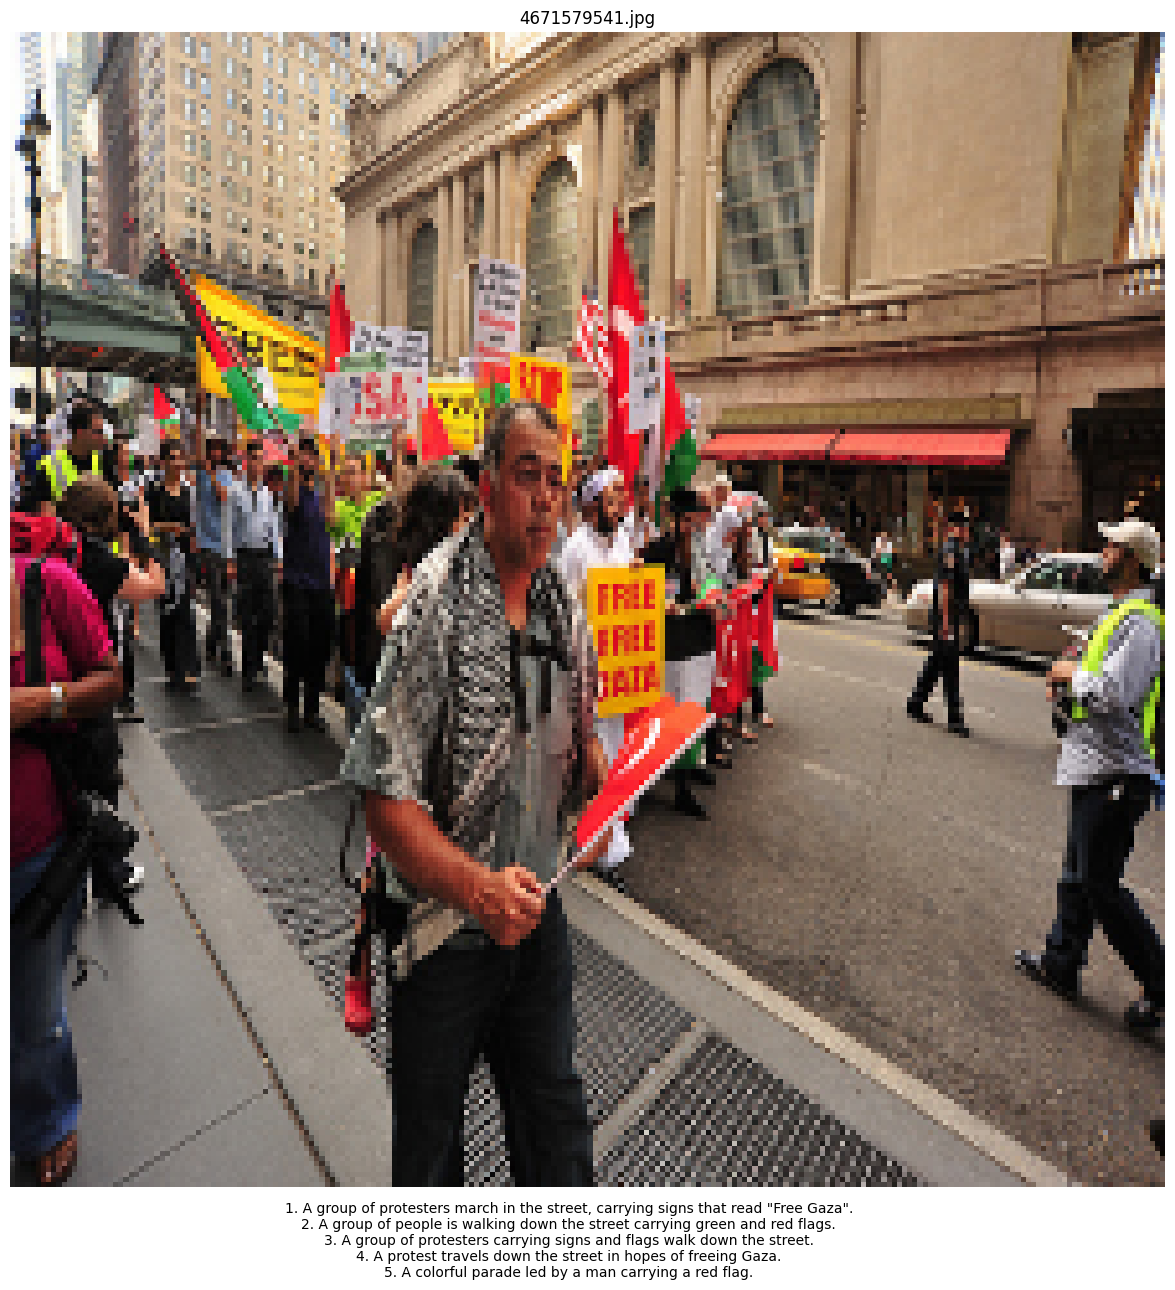

In [401]:
dataset.visualize_item() # Visualize one image at random from the dataset

## Model

Set the model configurations for the TERN transformer model.

In [402]:
d_embed = 128                      # output_dim
d_model = 128                      # model dim
d_ff = 256                          # feed-forward dim to be used in the transformers
aggregation = "mean"                # [mean, first]
N_v = 2                             # number of Vision Transformer encoder layers
N_l = 2                             # number of Text Transformer encoder layers
heads = 4                           # number of heads to be used in the visual and textual transformer
dropout = 0.3                       # dropout rate to be used in the transformer
precomp_bert = True                 # whether to use bert feature extractor
num_sw_layers = 1                   # number of shared-weight layers in the TERN architecture
max_rel_pos = 1                     # number of inputs to the left and right to be considered in the relative embedding matrix

### Architecture

Here I will build the TERN (Transformer Encoder Reasoning Network) Model Architecture, which I will training with the above DataLoader. But there is one key difference compared to the original TERN model architecture:
- I have incorporated the Relative Positional Encoding (RPE) instead of Sinusoidal Positional Encoding on both Image and Text side Transformers.

I could have used the already available layers in the `torch.nn` module. But incorporating the RPE requires modifying the way the Attention is calculated in the `MultiHeadAttention` so, I implemented the `MultiHeadAttention` to take into account the RPE.

In [403]:
class RelativePosition(nn.Module):
  """
  Calculate relative positional matrices
  :input:
    num_units:               relative positional embedding dimension
    max_relative_position:   number of inputs to the left and right of each input to consider for building the Relative Positional Embedding Matrix
  :output:
    relative positional embedding matrix
  """
  def __init__(self, num_units, max_relative_position):
    super().__init__()
    self.num_units = num_units # The relative positional embedding dimension
    self.max_relative_position = max_relative_position # The maximum number of inputs on either side to consider
    self.embeddings_table = nn.Parameter(torch.Tensor(max_relative_position * 2 + 1, num_units)) # The relative positional embedding matrix
    nn.init.xavier_uniform_(self.embeddings_table) # For initialization of the embeddings_table

  def forward(self, length_q, length_k):
    # length_q and length_k are nothing but just sequence length and is same in this case
    range_vec_q = torch.arange(length_q)
    range_vec_k = torch.arange(length_k)
    distance_mat = range_vec_k[None, :] - range_vec_q[:, None]
    # Clipped distance matrix where each row corresponds to the current input and it's entries refer to the inputs with which we consider the relative positional relationship -- Clipped as explained in the paper
    distance_mat_clipped = torch.clamp(distance_mat, -self.max_relative_position, self.max_relative_position)
    final_mat = distance_mat_clipped + self.max_relative_position
    final_mat = torch.LongTensor(final_mat).to(device)
    embeddings = self.embeddings_table[final_mat].to(device)
    
    return embeddings

class RelMultiHeadAttention(nn.Module):
  """
  Calculate relative multihead attention with num_heads and relative positional encoding
  :input:
    heads:          number of attention heads
    d_model:        embedding dim
    dropout:        dropout rate
  :output:
  """
  def __init__(self, heads, d_model, max_relative_position, dropout = 0.1):
    super().__init__()
    self.d_model = d_model
    assert d_model % heads == 0
    self.d_k = d_model // heads
    self.h = heads
    self.max_relative_position = max_relative_position # Number of inputs on either side to consider for relative positional embedding
    self.relative_position_k = RelativePosition(self.d_k, self.max_relative_position) # Relative Positional Embedding Keys Matrix
    self.relative_position_v = RelativePosition(self.d_k, self.max_relative_position) # Relative Positional Embedding Values Matrix
    self.q_linear = nn.Linear(d_model, d_model) # Queries Projection Matrix
    self.v_linear = nn.Linear(d_model, d_model) # Values Projection Matrix
    self.k_linear = nn.Linear(d_model, d_model) # Keys Projection Matrix
    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(d_model, d_model)
    self.scale = torch.sqrt(torch.FloatTensor([self.d_k])).to(device) # The scaling factor for the scaled-dot product attention

  def forward(self, q, k, v, mask = None):

    k = k.to(device) # key = [batch size, key len, hid dim]
    q = q.to(device) # query = [batch size, query len, hid dim]
    v = v.to(device) # value = [batch size, value len, hid dim]
    bs = q.size(0) # batch size
    len_k = k.shape[1] # sequence length 
    len_q = q.shape[1] # sequence length
    len_v = v.shape[1] # sequence length
    k = self.k_linear(k) # Linearly Projecting the Keys Matrix
    q = self.q_linear(q) # Linearly Projecting the Queries Matrix
    v = self.v_linear(v) # Linearly Projecting the Values Matrix

    # Usual Compatibility Function Calculation
    q1 = q.view(bs, -1, self.h, self.d_k).permute(0, 2, 1, 3)
    k1 = k.view(bs, -1, self.h, self.d_k).permute(0, 2, 1, 3)
    attn1 = torch.matmul(q1, k1.permute(0, 1, 3, 2))

    # Relative Positional Encoding Compatibility Function additional term calculate
    r_k = self.relative_position_k(len_q, len_k)
    r_k = r_k.permute(0, 2, 1)
    q2 = q1.permute(2, 0, 1, 3).reshape(len_q, -1, self.d_k)

    attn2 = torch.matmul(q2, r_k).view(len_q, bs, self.h, len_q)
    attn2 = attn2.permute(1, 2, 0, 3)
    attn = (attn1 + attn2) / self.scale # Final Compatibility Function

    if mask is not None:
      attn = attn.masked_fill(mask == 0, -1e10)

    attn = self.dropout(torch.softmax(attn, dim = -1)) # attn = [batch size, n heads, query len, key len]
    
    v1 = v.view(bs, -1, self.h, self.d_k).permute(0, 2, 1, 3) 
    weight1 = torch.matmul(attn, v1) # Usual attn-weighted value sum

    # Relative Positional Encoding attn-weighted values for additional term calculate
    r_v = self.relative_position_v(len_q, len_v)
    weight2 = attn.permute(2, 0, 1, 3).contiguous().view(len_q, bs*self.h, len_k)
    weight2 = torch.matmul(weight2, r_v)
    weight2 = weight2.transpose(0, 1).contiguous().view(bs, self.h, len_q, self.d_k)
    
    x = weight1 + weight2 # x = [batch size, n heads, query len, head dim]
    x = x.permute(0, 2, 1, 3).contiguous() # x = [batch size, query len, n heads, head dim]
    x = x.view(bs, -1, self.d_model) # x = [batch size, query len, hid dim]
    x = self.out(x) # x = [batch size, query len, hid dim]

    return x
  
def attention(q, k, v, d_k, mask=None, dropout=None):
  """
  Calculate attention
  :input:
      q:          query
      k:          key
      v:          value
      d_k:        scaled term
      mask:       whether to use masking attention
      dropout:    dropout rate
  :output:
  """

  # Query, Key matrix multiplication
  scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

  # If mask, use masking attetion
  if mask is not None:
    mask = mask.unsqueeze(1)
    scores = scores.masked_fill(mask == 0, -1e9)

  # Softmax for scaling in range [0,1]
  scores = F.softmax(scores, dim=-1)

  # Dropout
  if dropout is not None:
    scores = dropout(scores)

  # Score, Value matrix multiplication
  output = torch.matmul(scores, v)
  return output, scores

class MultiHeadAttention(nn.Module):
  """
  Calculate multihead attention with num_heads
  :input:
      heads:          number of attention heads
      d_model:        embedding dim
      dropout:        dropout rate
  :output:
  """
  def __init__(self, heads, d_model, max_relative_position, dropout = 0.1):
    super().__init__()

    self.d_model = d_model
    self.d_k = d_model // heads
    self.h = heads

    self.q_linear = nn.Linear(d_model, d_model)
    self.v_linear = nn.Linear(d_model, d_model)
    self.k_linear = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(d_model, d_model)

    # For visualization
    self.attn = None

  def forward(self, q, k, v, mask=None):

    bs = q.size(0)

    # perform linear operation and split into N heads
    k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
    q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
    v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

    # transpose to get dimensions bs * N * sl * d_model
    k = k.transpose(1,2)
    q = q.transpose(1,2)
    v = v.transpose(1,2)


    # calculate attention 
    scores, self.attn = attention(q, k, v, self.d_k, mask, self.dropout)
    # concatenate heads and put through final linear layer
    concat = scores.transpose(1,2).contiguous()\
    .view(bs, -1, self.d_model)
    output = self.out(concat)

    return output

Now, after the RPE-Based `MultiHeadAttention` I will build the usual Transformer Architecture.

Following are the `PositionwiseFeedForword` Layer and `LayerNorm` which is used in the `EncoderLayer`s of the Transformer's Encoder.

In [404]:
class PositionwiseFeedForward(nn.Module):
  """
  Just a simple 2-layer feed forward, input and output shape are equal
  """
  def __init__(self, model_dim, ff_dim, dropout=0.1):
    super().__init__()
    self.w_1 = nn.Linear(model_dim, ff_dim)
    self.w_2 = nn.Linear(ff_dim, model_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    Apply RELU and dropout between two layers
    """
    return self.w_2(self.dropout(F.gelu(self.w_1(x))))

class LayerNorm(nn.Module):
  "Construct a layernorm module."
  def __init__(self, model_dim, eps=1e-6):
    super().__init__()
    self.a_2 = nn.Parameter(torch.ones(model_dim))
    self.b_2 = nn.Parameter(torch.zeros(model_dim))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2    
  
class RelEncoderLayer(nn.Module):
  """
  Single encoder layer consists of Relative Multihead Attention, 
  2-layer feed forward, Layer Normalization and Dropout
  """
  def __init__(self, d_model, d_ff, heads, max_rel_pos, dropout=0.1):
    super().__init__()
    self.norm_1 = LayerNorm(d_model)
    self.norm_2 = LayerNorm(d_model)
    self.attn = RelMultiHeadAttention(heads, d_model, max_rel_pos, dropout=dropout)
    self.ff = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
    self.dropout_1 = nn.Dropout(dropout)
    self.dropout_2 = nn.Dropout(dropout)

  def forward(self, x, mask):
    x2 = self.norm_1(x)
    x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
    x2 = self.norm_2(x)
    x = x + self.dropout_2(self.ff(x2))
    return x
  
class EncoderLayer(nn.Module):
  """
  Single encoder layer consists of Multihead Attention, 
  2-layer feed forward, Layer Normalization and Dropout
  """
  def __init__(self, d_model, d_ff, heads, max_rel_pos, dropout=0.1):
    super().__init__()
    self.norm_1 = LayerNorm(d_model)
    self.norm_2 = LayerNorm(d_model)
    self.attn = MultiHeadAttention(heads, d_model, max_rel_pos, dropout=dropout)
    self.ff = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
    self.dropout_1 = nn.Dropout(dropout)
    self.dropout_2 = nn.Dropout(dropout)

  def forward(self, x, mask):
    x2 = self.norm_1(x)
    x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
    x2 = self.norm_2(x)
    x = x + self.dropout_2(self.ff(x2))
    return x

The following are few utility functions for creating the `TransformerEncoder`, Vision and Text Transformers and deals with intialization, making identical layers and $L_2$-normalizing vectors.

In [405]:
def get_clones(module, N):
  """
  "Produce N identical layers."
  """
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def init_xavier(model):
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

def l2norm(X):
  """
  L2-normalize columns of X
  """
  norm = torch.pow(X, 2).sum(dim=1, keepdim=True).sqrt()
  X = torch.div(X, norm)
  return X

Stacking multiple `EncoderLayer`s to build the `TransformerEncoder`, which will be used near the end of the `TERN` architecture and will serve as shared weight transformer for visual and textual feature outputs by the respective ViT and Language Transformer.

`ModalProjection` projects the output vector of `in_dim` of Vision Transformer and Language Transformer for each modal to `out_dim` after passing it through an `ReLU` activation. This is used as the final step to come up with two vector outputs one for visual side and other for textual side.

In [406]:
class TransformerEncoder(nn.Module):
  """
  transformer encoder
  """
  def __init__(self, d_model, d_ff, N, heads, max_rel_pos, dropout, sw = False):
    super().__init__()
    self.N = N
    self.sw = sw
  
    if self.N >= 1 and (not self.sw):
      self.rel_layer = RelEncoderLayer(d_model, d_ff, heads, max_rel_pos, dropout)
    if self.N > 1:
      self.layers = get_clones(EncoderLayer(d_model, d_ff, heads, max_rel_pos, dropout), N-1)
      self.norm = LayerNorm(d_model)  

  def forward(self, x):
    if self.N >= 1 and (not self.sw):
      x = self.rel_layer(x, mask=None)
    if self.N > 1:
      for i in range(self.N-1):
        x = self.layers[i](x, mask=None)
      x = self.norm(x)
    return x

class ModalProjection(nn.Module):
  """
  Project features into same space
  """
  def __init__(self, in_dim, out_dim):
    super().__init__()

    self.model = nn.Sequential(
          nn.Linear(in_dim, in_dim),
          nn.ReLU(),
          nn.Linear(in_dim, out_dim))

  def forward(self, x):
    return self.model(x)

Now, we will build at the Vision Transformer Encoder `EncoderBottomUp`. But for that I will embed the visual features (extracted by ResNet) of each region to be transformed to `embed_dim` from `features_dim`, which is done by `FeatureEmbedding` and `SpatialEncoding` transforms the bounding box coordinates to `embed_dim` to be added to the visual features.

In [407]:
class FeatureEmbedding(nn.Module):
  """
  Projects image features into a space of
  dimensionality `embed_dim`.
  """
  def __init__(self, features_dim, embed_dim):
    super().__init__()
    self.linear = nn.Linear(features_dim, embed_dim)

  def forward(self, x):
    return self.linear(x)


class SpatialEncoding(nn.Module):
  """
  Encodes bounding box coordinates and relative sizes
  as vector of dimensionality `embed_dim`.
  """
  def __init__(self, embed_dim):
    super().__init__()
    self.linear = nn.Linear(5, embed_dim)

  def forward(self, x):
    return self.linear(x)

The following is the `EncoderBottomUp` layer that will add the `cls_token1` before the sequence of region's feature embedding and `cls_token2` before the sequence of region's location feature embedding. After that it will apply the `FeatureEmbedding` and `SpatialEncoding` layer to come with a single sequence of feature instead of two, by adding the location features and the regions extracted features.

In [408]:
class EncoderBottomUp(nn.Module):
  """
  Encoder for Bottom-Up-Attention features
  :input:
      feat_dim:       feature dim
      d_model:        embeddings dim
  :output:
      encoded embeddings shape [batch * input length * model_dim]
  """
  def __init__(self, feat_dim, d_model):
    super().__init__()
    self.cls_token1 = nn.Parameter(torch.zeros(1, 1, d_model)) # Add CLS token 
    self.cls_token2 = nn.Parameter(torch.zeros(1, 1, d_model)) # Add CLS token 

    self.feat_embed = FeatureEmbedding(feat_dim, d_model)
    self.loc_embed = SpatialEncoding(d_model)

  def forward(self, src, spatial_src):
    x = self.feat_embed(src)
    cls_token1 = self.cls_token1.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_token1, x), dim=1)

    spatial_x = self.loc_embed(spatial_src)
    cls_token2 = self.cls_token2.expand(spatial_x.shape[0], -1, -1)
    spatial_x = torch.cat((cls_token2, spatial_x), dim=1)

    x += spatial_x

    return x

Now, I will construct the `EncoderBERT` layer that applies the `distilbert-base-uncased` pretrained model to convert the input to extracted features. But, since I have precomputed the features on the captions, the `precomp` argument is set to `True` and `EncoderBERT` won't compute these features for the captions again and simply pass the `x` tensor when it is called with it, when `precomp = True`.

In [409]:
class EncoderBERT(nn.Module):
  """
  Pretrained BERT model
  :input:
      version:       bert version
      precomp:       True, if precomputed features is to be used
  :output:
      encoded embeddings shape [batch * input length * model_dim]
  """

  def __init__(self, feat_dim, d_model, version='distilbert-base-uncased', precomp=True, device=None):
    super().__init__()
  
    self.feat_dim = feat_dim
    self.d_model = d_model
    self.feat_embed = FeatureEmbedding(feat_dim, d_model)
    
    self.precomp = precomp

    if not self.precomp:
      model = AutoModel.from_pretrained(version)

      tokenizer = AutoTokenizer.from_pretrained(version, add_special_tokens = 'true', padding = 'longest')

      self.pipeline = pipeline(
        'feature-extraction', 
        model=model, 
        tokenizer=tokenizer, 
        device = 0 if device is not None else -1)

  def forward(self, x):
    if not self.precomp:
      with torch.no_grad():
        x = self.pipeline(x)
      x = np.squeeze(x)
      if len(x.shape) == 2:
        x = np.expand_dims(x, axis=0)
      x = make_feature_batch(x, pad_token=0)
      x = x.to(device)
    x = self.feat_embed(x)

    return x

Finally, we put it all together into the `TERN` Model.

In [410]:
class TERN(nn.Module):
  """
  Architecture idea based on Transformer Encoder Reasoning Network
  :input:
    d_model: Embedding Dimension for the Visual and Textual Encoder
    d_ff: FeedForward Network Hidden Unit in Visual and Textual Encoder
    N_v: Number of Encoder Layers in Visual Encoder
    N_l: Number of Encoder Layers in Language Encoder
    heads: Number of heads in Visual and Textual Encoder
    max_rel_pos: Number of inputs on either side of an input to be considered for Relative Position Encoding
    dropout: Dropout Rate
    aggregation: After Visual and Textual Encoder, how to collapse the temporal dimension of the output
    precomp_bert: True/False depending on if you have pre-computed features
    num_sw_layers: Number of shared transformer encoder layers
  :output:
    visual output feature vector, language output feature vector
  """
  def __init__(self, d_model, d_embed, d_ff, N_v, N_l, heads, max_rel_pos, dropout, aggregation, precomp_bert, num_sw_layers, **kwargs):
    super(TERN, self).__init__()
    self.name = "TERN" # Name of the model
    self.aggregation = aggregation # ['mean' | 'first'] How to collapse the Transformer Sequence output into a single feature vector
    self.precomp_bert = precomp_bert # If the BERT features need to be computed?

    self.encoder_v = EncoderBottomUp(feat_dim=2048, d_model=d_model) # Visual Embedding Layer [Considering the combined output of Faster-RCNN and Resnet extracted features to be the embedding for the visual transformer model]
    self.encoder_l = EncoderBERT(feat_dim=768, d_model=d_model, precomp=precomp_bert) # Textual Embedding Layer [Considering the output of BERT to be the embedding for the textual transformer model]

    self.reasoning_v = TransformerEncoder(d_model=d_model, d_ff=d_ff, N=N_v, heads=heads, max_rel_pos=max_rel_pos, dropout=dropout) # ViT
    self.reasoning_l = TransformerEncoder(d_model=d_model, d_ff=d_ff, N=N_l, heads=heads, max_rel_pos=max_rel_pos, dropout=dropout) # LangT
  
    if num_sw_layers > 0: # Shared weight encoders
      self.sw_layer = TransformerEncoder(d_model=d_model, d_ff=d_ff, N=num_sw_layers, heads=heads, max_rel_pos=max_rel_pos, dropout=dropout, sw=True)
    else:
      self.sw_layer = None
    
    self.img_proj = ModalProjection(in_dim=d_model, out_dim=d_embed) # Final projection of in_dim vector to out_dim vector for visual side
    self.cap_proj = ModalProjection(in_dim=d_model, out_dim=d_embed) # Final projection of in_dim vector to out_dim vector for textual side

    init_xavier(self)

  def forward(self, batch):
    outputs_v = self.visual_forward(batch)
    outputs_l = self.lang_forward(batch)
    return outputs_l, outputs_v


  def visual_forward(self, batch):
    visual_inputs = batch['feats'].to(device)
    spatial_inputs = batch['loc_feats'].to(device)

    outputs_v = self.encoder_v(visual_inputs, spatial_inputs) 
    outputs_v = self.reasoning_v(outputs_v)                   

    if self.sw_layer is not None:
      outputs_v = self.sw_layer(outputs_v)

    if self.aggregation == 'mean':
      feats_v = self.img_proj(outputs_v).mean(dim=1)
    if self.aggregation == 'first':
      feats_v = self.img_proj(outputs_v)[:, 0]

    feats_v = l2norm(feats_v)
    return feats_v

  def lang_forward(self, batch):
    if self.precomp_bert:
      lang_inputs = batch['lang_feats'].to(device)
      outputs_l = self.encoder_l(lang_inputs) 
    else:
      outputs_l = self.encoder_l(batch['texts'])
      outputs_l = outputs_l.to(device)

    outputs_l = self.reasoning_l(outputs_l)

    if self.sw_layer is not None:
      outputs_l = self.sw_layer(outputs_l)

    if self.aggregation == 'mean':
      feats_l = self.cap_proj(outputs_l).mean(dim=1)

    if self.aggregation == 'first':
      feats_l = self.cap_proj(outputs_l)[:, 0]

    feats_l = l2norm(feats_l)
    return feats_l

In [411]:
tern = TERN(
  d_model=d_model,
  d_embed=d_embed,
  d_ff=d_ff,
  N_v=N_v,
  N_l=N_l,
  heads=heads,
  max_rel_pos=max_rel_pos,
  dropout=dropout,
  aggregation='first',
  precomp_bert=True,
  num_sw_layers=num_sw_layers
).to(device)

In [412]:
tern.parameters

<bound method Module.parameters of TERN(
  (encoder_v): EncoderBottomUp(
    (feat_embed): FeatureEmbedding(
      (linear): Linear(in_features=2048, out_features=128, bias=True)
    )
    (loc_embed): SpatialEncoding(
      (linear): Linear(in_features=5, out_features=128, bias=True)
    )
  )
  (encoder_l): EncoderBERT(
    (feat_embed): FeatureEmbedding(
      (linear): Linear(in_features=768, out_features=128, bias=True)
    )
  )
  (reasoning_v): TransformerEncoder(
    (rel_layer): RelEncoderLayer(
      (norm_1): LayerNorm()
      (norm_2): LayerNorm()
      (attn): RelMultiHeadAttention(
        (relative_position_k): RelativePosition()
        (relative_position_v): RelativePosition()
        (q_linear): Linear(in_features=128, out_features=128, bias=True)
        (v_linear): Linear(in_features=128, out_features=128, bias=True)
        (k_linear): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (out): Linear(in_feat

### Loss Function

Since, the objective is to learn good vector representation of the textual and image features in the joint-embedding space. The task is to maximize the similarity between the vector representation of the caption and the vector representation of the corresponding image.

This idea is similar to that of Siamese Network, where we train triplet loss function to maximize the similarity between the same input images but increases the dissimilarity between the different input images. Here, the difference is instead of having pairs of images we have pairs of image and texts.

Thus, `ContrastiveLoss` is chosen as the loss function.

In [413]:
def dot_sim(im, s):
  """
  Cosine similarity between all the image and sentence pairs
  """
  return im.mm(s.t())

class ContrastiveLoss(nn.Module):
  """
  Compute contrastive loss
  """

  def __init__(self, margin=0, max_violation=False):
    super().__init__()
    self.margin = margin
    self.sim = dot_sim
    self.max_violation = max_violation

  def forward(self, im, s):
    scores = self.sim(im, s) # compute image-sentence score matrix
    diagonal = scores.diag().view(im.size(0), 1)
    d1 = diagonal.expand_as(scores)
    d2 = diagonal.t().expand_as(scores)

    # compare every diagonal score to scores in its column
    # caption retrieval
    cost_s = (self.margin + scores - d1).clamp(min=0) # Here cost_s minimization implies d1 - score > margin --> diagonal scores will be improved compared to off diagonal on caption-retrieval
    # compare every diagonal score to scores in its row
    # image retrieval
    cost_im = (self.margin + scores - d2).clamp(min=0) # Same as cost_s but for image-retrieval

    # clear diagonals
    mask = torch.eye(scores.size(0)) > .5
    I = mask.to(device)
    cost_s = cost_s.masked_fill_(I, 0)
    cost_im = cost_im.masked_fill_(I, 0)

    # keep the maximum violating negative for each query
    if self.max_violation:
      cost_s = cost_s.max(1)[0]
      cost_im = cost_im.max(0)[0]

    loss = cost_s.sum() + cost_im.sum()
    return loss

In [414]:
criterion = ContrastiveLoss(0.2)

### Evalutation Metric

The reason why I am creating the evaluation metric before training is while training, there will be a evaluation step on the validation dataset. Thus, to carry out that step to get an idea about validation loss. I create the evaluation metrics before training.

I will be using the following metrics for evaluation:
- F1
- MAP (Mean Average Precision)
- NN (Nearest Neighbor)
- Recall
- First Tier
- Second Tier

In [415]:
class F1Metric:
  """
  F1 score at K
  """
  def __init__(self, k, decimals = 4):
    self.k = k
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    output = output[:self.k]
    n = len(np.intersect1d(target,output)) # Number of corrects
    score = 2*n / (len(target)+len(output))
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {f"F1@{self.k}" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [416]:
class MAPMetric:
  """
  Mean average precision at K
  """
  def __init__(self, k, decimals = 4):
    self.k = k
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    output = output[:self.k]
    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(output):
      if p in target and p not in output[:i]:
        num_hits += 1.0
        score += num_hits / (i+1.0)
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {f"MAP@{self.k}" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [417]:
class NearestNeighborMetric:
  """
  Nearest neighbor
  """
  def __init__(self, decimals = 4):
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    score = int(output[0] in target)
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {"NN" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [418]:
class RecallMetric:
  """
  Nearest neighbor
  """
  def __init__(self, k, decimals = 4):
    self.k = k
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    retrieved_labels = output[:self.k]
    n_targets = len(target)                                        # Number of targets
    n_relevant_objs = len(np.intersect1d(target,retrieved_labels)) # Number of corrects
    score = n_relevant_objs*1.0 / n_targets
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {f"R@{self.k}" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [419]:
class FirstTierMetric:
  """
  First Tier
  """
  def __init__(self, decimals = 4):
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    n_relevant_objs = sum([1 if i in target else 0 for i in output])
    retrieved_1st_tier = output[:n_relevant_objs+1]
    score = np.mean([1 if i in target else 0 for i in retrieved_1st_tier])
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {"FT" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [420]:
class SecondTierMetric:
  """
  Second Tier
  """
  def __init__(self, decimals = 4):
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    n_relevant_objs = sum([1 if i in target else 0 for i in output])
    retrieved_2nd_tier = output[:2*n_relevant_objs+1]
    score = np.mean([1 if i in target else 0 for i in retrieved_2nd_tier])
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {"ST" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

Based on all the above metrics, I define a single `RetrievalScore` class that will load the evaluation dataloaders on instantiation and will help us readily evaluate the model

In [421]:
# Some utility functions
def get_dist_func(name):
  if name == 'cosine':
    return cosine_distances # 1 - similarity
  elif name == 'euclide':
    return euclidean_distances
  else:
    raise NotImplementedError

def save_results(query_results, outname):
  if not os.path.exists('./results/'):
    os.mkdir('./results/')
  np.save(f'./results/{outname}.npy', query_results, allow_pickle=True)

def get_top_k(object_dist_score, top_k=5, max_distance=2.0):
  """
  Input: Array of distance of each item in the gallery to the query
  Return: top k objects's indexes and scores
  """
  top_k_indexes = object_dist_score.argsort()[:top_k] # Sort item by distance and get top-k
  top_k_scores = object_dist_score[top_k_indexes]

  if max_distance is not None: # Keep only item with near distance
    keep_indexes = top_k_scores <= max_distance
    top_k_indexes = top_k_indexes[keep_indexes]
    top_k_scores = top_k_scores[keep_indexes]

  return top_k_indexes, top_k_scores

metrics_mapping = { # All the metrics to keep track of during evaluation
  'FT': FirstTierMetric(),
  'ST': SecondTierMetric(),
  'NN': NearestNeighborMetric(),
  'MAP@10': MAPMetric(k=10),
  'F1@10': F1Metric(k=10),
  'R@1': RecallMetric(k=1),
  'R@5': RecallMetric(k=5),
  'R@10': RecallMetric(k=10),
}

The `RetrievalScore` calculates the value of each of the above metric when called.
It saves the prediction for each batch:
- `./results/i2t_results.npy` for image-to-text retrieval
- `./results/t2i_results.npy` for text-to-image retrieval.

Set `eval_batch_size` for the evaluation batch size.

In [422]:
eval_batch_size = 128 # Set the evaluation batch size
eval_num_workers = 0

In [423]:
class RetrievalScore:    
  def __init__(self, 
        image_set, 
        text_set, 
        dimension=1024,
        metric_names=['FT', "ST", "MAP@10", "NN", "F1@10", "R@10"],
        max_distance = None,
        top_k=10,
        save_results=True):

    self.metric_names = metric_names
    self.image_loader = data.DataLoader(
      image_set,
      batch_size=eval_batch_size,
      shuffle = False, 
      collate_fn=image_set.collate_fn, 
      num_workers= eval_num_workers,
      pin_memory=True
    )

    self.text_loader = data.DataLoader(
      text_set,
      batch_size=eval_batch_size,
      shuffle = False, 
      collate_fn=text_set.collate_fn, 
      num_workers= eval_num_workers,
      pin_memory=True
    )

    self.top_k = top_k                  # Query top k candidates
    self.max_distance = max_distance    # Query candidates with distances lower than threshold
    self.save_results = save_results    # Save for vizualization

    self.image_embedding = [] 
    self.text_embedding = []

    # For image-to-text retrieval
    self.image_ids = []
    self.text_target_ids = []

    # For text-to-image retrieval
    self.text_ids = []
    self.image_target_ids = []

    if self.save_results:
      self.results_dict = {}

    self.dist_func = get_dist_func('cosine') # Distance function

  def reset(self):
    self.image_embedding = [] 
    self.text_embedding = []

    # For image-to-text retrieval
    self.image_ids = []
    self.text_target_ids = []

    # For text-to-image retrieval
    self.text_ids = []
    self.image_target_ids = []

    if self.save_results:
      self.results_dict = {}

    for metric_name in self.metric_names:
      metric_fn = metrics_mapping[metric_name]
      metric_fn.reset()        

  def update(self, model):
    self.model = model
    self.model.model.eval()

  def compute_images(self):
    for idx, batch in enumerate(tqdm(self.image_loader)):
      image_ids = batch['ids']
      text_target_ids = batch['text_ids']
      feats = self.model.get_visual_embeddings(batch)

      # Get embedding of each item in batch
      batch_size = feats.shape[0]
      for i in range(batch_size):
        feat = feats[i]
        self.image_embedding.append(feat)
        self.image_ids.append(image_ids[i])
        self.text_target_ids.append(text_target_ids[i])

    self.image_embedding = np.array(self.image_embedding)
    self.text_target_ids = np.array(self.text_target_ids)
    self.image_ids = np.array(self.image_ids)

  def compute_texts(self):
    for idx, batch in enumerate(tqdm(self.text_loader)):
      text_ids = batch['ids']
      image_target_ids = batch['image_ids']
      feats = self.model.get_lang_embeddings(batch)

      # Get embedding of each item in batch
      batch_size = feats.shape[0]
      for i in range(batch_size):
        feat = feats[i]
        self.text_embedding.append(feat)
        self.text_ids.append(text_ids[i])
        self.image_target_ids.append(image_target_ids[i])

    self.text_embedding = np.array(self.text_embedding)
    self.image_target_ids = np.array(self.image_target_ids)
    self.text_ids = np.array(self.text_ids)

  def compute_default(self, queries_embedding, gallery_embedding, queries_ids, targets_ids, gallery_ids):
    """
    Compute score for each metric and return 
    """

    # Compute distance matrice for queries and gallery
    print("Calculating distance matrice...")
    dist_mat = self.dist_func(queries_embedding, gallery_embedding)

    # np.savetxt("./results/dist_mat.txt",dist_mat)
    for idx, row in enumerate(dist_mat):
      object_dist_score = dist_mat[idx]
      top_k_indexes, top_k_scores = get_top_k(
        object_dist_score,
        top_k=self.top_k,
        max_distance=self.max_distance
      )

      current_id = queries_ids[idx] # query id
      target_ids = targets_ids[idx] if not isinstance(targets_ids[idx], np.int64) else np.array([targets_ids[idx]]) # target id 

      pred_ids = gallery_ids[top_k_indexes] # gallery id
      pred_ids = pred_ids.tolist() if not isinstance(pred_ids.tolist(), int) else [pred_ids.tolist()]

      if self.save_results:
          self.results_dict[current_id] = {
            'pred_ids': pred_ids,
            'target_ids': target_ids,
            'scores': top_k_scores 
          }

      for metric_name in self.metric_names:
        metric_fn = metrics_mapping[metric_name]
        metric_fn.update(pred_ids, target_ids)

  def _compute_score(
    self, 
    queries_embedding, 
    gallery_embedding, 
    queries_ids, 
    targets_ids, 
    gallery_ids,
    outname):

    self.results_dict = {}

    self.compute_default(
      queries_embedding, 
      gallery_embedding, 
      queries_ids, 
      targets_ids, 
      gallery_ids)

    # Save results for visualization later
    if self.save_results:
      print("Saving retrieval results...")
      save_results(self.results_dict, outname)

    result_dict = {}
    for metric_name in self.metric_names:
      metric_fn = metrics_mapping[metric_name]
      result_dict.update(metric_fn.value())

    return result_dict

  def compute(self):
    print("Extracting features...")
    self.reset()
    with torch.no_grad():
      self.compute_images()
      self.compute_texts()

    i2t_dict = self._compute_score(
      self.image_embedding, self.text_embedding, 
      self.image_ids, self.text_target_ids, self.text_ids, outname='i2t_results')

    t2i_dict = self._compute_score(
      self.text_embedding, self.image_embedding, 
      self.text_ids , self.image_target_ids, self.image_ids, outname='t2i_results')

    result_dict = {"i2t/" + k : v for k,v in i2t_dict.items()}
    result_dict.update({"t2i/" + k : v for k,v in t2i_dict.items()})

    return result_dict

  def value(self):
    result_dict = self.compute()
    return result_dict

  def __str__(self):
    return str(self.value())

In [424]:
top_k = 10 # How many top k elements to select when computing distance/similary based metrics above?
max_distance = 2.0 # Within how much distance should I consider the top_k elements?
metric_names = ["R@1", "R@5", "R@10"] # Metrics to compute select from FT, ST, NN, MAP@10, F1@10, R@1, R@5, R@10

In [425]:
metric = RetrievalScore( # Instantiation metric class
          valset1, valset2, 
          max_distance = max_distance,
          top_k=top_k,
          metric_names=metric_names,
          dimension=d_embed,
          save_results=True)

### Optimizer

I choose to go with the `AdamW` optimizer. The optimizer parameters can be set by changing the following values.

In [426]:
lr = 1e-3 # Learning Rate
betas = (0.937, 0.98) # Momentum Term
eps = 1e-9 # Epsilon
weight_decay = 0.0005 # Weight Decay

In [427]:
optimizer = torch.optim.AdamW(tern.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

The `CosineAnnealingWithRestarts` is used as the learning rate annealing function.

In [428]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

### Training

I define a model class `Retriver` that will make handling of the `tern` model easier in terms:
- evaluation (`evaluate_step`)
- training (`training_step`)
- inference (`inference_step`)
- extracting feature (`get_visual_embeddings`, `get_lang_embeddings`)

In [429]:
class Retriever:
  def __init__(self, model, optimizer, scheduler, criterion, metrics, freeze=False):
    super().__init__()
    self.model = model
    self.model_name = self.model.name
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.criterion = criterion
    self.freeze = freeze
    self.metrics = metrics # Metrics to evaluate the model on
    if not isinstance(metrics, list):
      self.metrics = [metrics,]
    if self.freeze: # Freezing the model parameters
      for params in self.model.parameters():
          params.requires_grad = False

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch):
    outputs_1, outputs_2 = self.model(batch)
    loss = self.criterion(outputs_1, outputs_2)
    return loss

  def inference_step(self, batch):
    outputs_1, outputs_2 = self.model(batch)
    return outputs_1.cpu().detach().numpy(), outputs_2.cpu().detach().numpy()

  def evaluate_step(self, batch):
    outputs_1, outputs_2 = self.model(batch)
    loss = self.criterion(outputs_1, outputs_2)
    self.update_metrics(model=self)
    return loss

  def get_visual_embeddings(self, batch): # Get Visual features for a batch
    outputs_v = self.model.visual_forward(batch)
    return outputs_v.cpu().detach().numpy().astype(np.float32)

  def get_lang_embeddings(self, batch): # Get Language features for a batch
    outputs_l = self.model.lang_forward(batch)
    return outputs_l.cpu().detach().numpy().astype(np.float32)
  
  def trainable_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

  def unfreeze(self):
    for params in self.parameters():
      params.requires_grad = True

  def update_metrics(self, **kwargs):
    for metric in self.metrics:
      metric.update(**kwargs)

  def get_metric_values(self):
    metric_dict = {}
    for metric in self.metrics:
      metric_dict.update(metric.value())
    return metric_dict

  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset()

In [430]:
model = Retriever( # Instantiating the model
  model=tern,
  optimizer=optimizer,
  scheduler=scheduler,
  criterion=criterion,
  metrics=metric
)

#### Checkpoint

The following `Checkpoint` class helps in saving the following things while training:
- `model`: model weights
- `optimizer`: optimizer state
- `epoch`: number of epochs trained for
- `iters`: number of iterations trained for

In [431]:
class Checkpoint():
  """
  Checkpoint for saving model state
  :param save_per_epoch: (int)
  :param path: (string)
  """
  def __init__(self, save_per_epoch = 2, path = None):
    self.path = path
    self.save_per_epoch = save_per_epoch
    # Create folder
    if self.path is None:
      self.path = os.path.join('weights',datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

  def save(self, model, epoch, iters, save_mode='last'):
    """
    Save model and optimizer weights
    :param model: Pytorch model with state dict
    """
    if not os.path.exists(self.path):
        os.makedirs(self.path)

    model_path = "_".join([model.model_name,save_mode])

    epoch = epoch
    iters = iters

    weights = {
      'model': model.model.state_dict(),
      'optimizer': model.optimizer.state_dict(),
      'epoch': epoch,
      'iters': iters,
    }

    torch.save(weights, os.path.join(self.path,model_path)+".pth")

Loading the model's and optimizer's `state_dict` for the `tern` model can be done using the following `load_checkpoint`.

In [432]:
def load_checkpoint(model, path):
  """
  Load trained model checkpoint
  :param model: (nn.Module)
  :param path: (string) checkpoint path
  """
  state = torch.load(path)
  model.load_state_dict(state["model"])
  if optimizer is not None:
    optimizer.load_state_dict(state["optimizer"])
  else:
    print('Failed to load optimizer state')
  print("Loaded Successfully!")
  print('Epochs Trained:', state["epoch"])
  print('Iterations Trained:', state["iters"])

#### Training

Now, set the training configurations:
- `num_epochs`: Number of epochs to train the model.
- `checkpoint`: An object of the `Checkpoint` class with appropriate `save_per_iter` value which is after how many iterations, the model will be saved
- `evaluate_per_epoch`: After how many epochs the model will be evaluated
- `save_per_epoch`: After how many epochs the model will be checkpointed

In [433]:
num_epochs = 100 # set number of epochs to train the model for
save_per_iter = 1000 # set the number of iterations after which the model will be saved while training
evaluate_per_epoch = 2 # set the number of epochs after which the model will be evaluated
save_per_epoch = 1 # set the number of epochs after which the model will be saved

In [434]:
num_iters = (num_epochs+1) * len(trainloader)
checkpoint = Checkpoint(save_per_epoch= save_per_epoch)
loss_list_train = [] # A list of training loss
loss_list_eval = [] # A list of evaluation loss
best_value = 0
iters = 0

I use a hack, I download a pretrained model without RPE and copy it's weight to start off at a better position.

In [435]:
# pretrained_model_path = '/Users/rishideychowdhury/Desktop/Joint-Embedding/Models/TERN_best.pth'
# pretrained_model = torch.load(pretrained_model_path, map_location=device)['model']

In [436]:
# with torch.no_grad():
#   model_dict = model.model.state_dict()
#   pretrained_dict = {k: v for k, v in pretrained_model.items() if k in model_dict}
#   for key in model.model.state_dict():
#     if key not in pretrained_dict:
#       pretrained_dict[key] = model.model.state_dict()[key]
#   model.model.load_state_dict(pretrained_dict)

`training_epoch` decides what will be done in every epoch of training.

In [437]:
def training_epoch(epoch):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for idx, batch in enumerate(tqdm(trainloader)):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + idx / len(trainloader)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, num_epochs, iters, num_iters, running_loss, running_time))

    if (epoch % checkpoint.save_per_epoch == 0 or epoch == num_epochs - 1):
      print(f'Save model at [{epoch}|{num_epochs}] to last.pth')
      checkpoint.save(model, epoch = epoch, iters = iters)

In [438]:
def evaluate_epoch(epoch, best_value):
  model.model.eval() # setting model to evaluate mode
  with torch.no_grad():
    running_loss = 0
    metric_dict = {} # stores the values of the metric
    print('=============================EVALUATION===================================')
    start_time = time.time()
    for batch in tqdm(valloader):
      eval_loss = model.evaluate_step(batch) # does one forward pass through the model
      running_loss += eval_loss
      # loss_list_eval.append(eval_loss) # appends the evaluation loss to the list of evaluation loss

    end_time = time.time()
    running_time = end_time - start_time
    running_loss /= (len(valloader)*valloader_args['batch_size'])
    metric_dict = model.get_metric_values() # gets the metric values based on updated model parameters
    model.reset_metrics() # resets the metric values

    print()
    print("Epochs: [{}|{}] || Loss: {} || Time: {:10.4f} s".format(epoch, num_epochs, running_loss, running_time))

    for metric, score in metric_dict.items():
      print(metric +': ' + str(score), end = ' | ')
    print()
    print('==========================================================================')

  # Save model gives best average R@10 score
  if metric_dict['t2i/R@10'] > best_value:
    best_value = metric_dict['t2i/R@10']
    checkpoint.save(model, save_mode = 'best', epoch = epoch, iters = iters)
    return best_value
  return best_value


Start Training

In [439]:
s0 =  "##########   MODEL INFO   ##########"
s1 = "Model name: " + model.model_name
s2 = f"Number of trainable parameters:  {model.trainable_parameters()}"
s5 = "Training iterations per epoch: " + str(len(trainloader))
s6 = "Validating iterations per epoch: " + str(len(valloader))
print("\n".join([s0,s1,s2,s5,s6]))

##########   MODEL INFO   ##########
Model name: TERN
Number of trainable parameters:  958592
Training iterations per epoch: 907
Validating iterations per epoch: 32


In [450]:
print(f'===========================START TRAINING=================================')
for epoch in range(num_epochs):
  try:
    training_epoch(epoch) # training epoch

    if evaluate_per_epoch != 0: # evaluation epoch
      if epoch % evaluate_per_epoch == 0 and epoch+1 >= evaluate_per_epoch:
        best_value = evaluate_epoch(epoch, best_value)

  except KeyboardInterrupt:   
    checkpoint.save(model, epoch = epoch, iters = iters)
    print("Stop training, checkpoint saved...")
    break

print("Training Completed!")

===========================START TRAINING=================================


100%|█████████████████████████████████████████| 907/907 [04:14<00:00,  3.56it/s]


Epochs: [0|100] || Iterations: [907|91607] || Loss:    12.2487 || Time:   254.9608s
Save model at [0|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.82it/s]


Epochs: [1|100] || Iterations: [1814|91607] || Loss:    12.3872 || Time:   237.3784s
Save model at [1|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.81it/s]


Epochs: [2|100] || Iterations: [2721|91607] || Loss:    12.3872 || Time:   237.8606s
Save model at [2|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.61it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:09<00:00,  4.28it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [2|100] || Loss: 12.192965507507324 || Time:     6.9388 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0043 | t2i/R@10: 0.0085 | 


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.81it/s]


Epochs: [3|100] || Iterations: [3628|91607] || Loss:    12.3871 || Time:   238.1170s
Save model at [3|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [4|100] || Iterations: [4535|91607] || Loss:    12.3872 || Time:   238.9845s
Save model at [4|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.09it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.45it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [4|100] || Loss: 12.192964553833008 || Time:     6.2829 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0043 | t2i/R@10: 0.0085 | 


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.82it/s]


Epochs: [5|100] || Iterations: [5442|91607] || Loss:    12.3872 || Time:   237.6436s
Save model at [5|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.82it/s]


Epochs: [6|100] || Iterations: [6349|91607] || Loss:    12.3874 || Time:   237.6225s
Save model at [6|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.08it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.39it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [6|100] || Loss: 12.192964553833008 || Time:     6.3056 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0043 | t2i/R@10: 0.0085 | 


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [7|100] || Iterations: [7256|91607] || Loss:    12.3827 || Time:   238.7527s
Save model at [7|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.82it/s]


Epochs: [8|100] || Iterations: [8163|91607] || Loss:    12.3877 || Time:   237.7001s
Save model at [8|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.11it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.44it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [8|100] || Loss: 12.19296646118164 || Time:     6.2635 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0007 | t2i/R@5: 0.0044 | t2i/R@10: 0.0082 | 


100%|█████████████████████████████████████████| 907/907 [03:55<00:00,  3.85it/s]


Epochs: [9|100] || Iterations: [9070|91607] || Loss:    12.3899 || Time:   235.7086s
Save model at [9|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.82it/s]


Epochs: [10|100] || Iterations: [9977|91607] || Loss:    12.3888 || Time:   237.2722s
Save model at [10|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.00it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.39it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [10|100] || Loss: 12.192965507507324 || Time:     6.3998 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0043 | t2i/R@10: 0.0089 | 


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [11|100] || Iterations: [10884|91607] || Loss:    12.3871 || Time:   238.5936s
Save model at [11|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [12|100] || Iterations: [11791|91607] || Loss:    12.3860 || Time:   238.5301s
Save model at [12|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.10it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.40it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [12|100] || Loss: 12.19296646118164 || Time:     6.2797 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0046 | t2i/R@10: 0.0085 | 


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.83it/s]


Epochs: [13|100] || Iterations: [12698|91607] || Loss:    12.3882 || Time:   236.5416s
Save model at [13|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.83it/s]


Epochs: [14|100] || Iterations: [13605|91607] || Loss:    12.3840 || Time:   236.7797s
Save model at [14|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.09it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.20it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [14|100] || Loss: 12.192967414855957 || Time:     6.2823 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0043 | t2i/R@10: 0.0087 | 


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [15|100] || Iterations: [14512|91607] || Loss:    12.3814 || Time:   238.4812s
Save model at [15|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:59<00:00,  3.78it/s]


Epochs: [16|100] || Iterations: [15419|91607] || Loss:    12.3886 || Time:   239.7332s
Save model at [16|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.10it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.36it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [16|100] || Loss: 12.192965507507324 || Time:     6.2712 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0041 | t2i/R@10: 0.0089 | 


100%|█████████████████████████████████████████| 907/907 [03:55<00:00,  3.85it/s]


Epochs: [17|100] || Iterations: [16326|91607] || Loss:    12.3874 || Time:   235.7951s
Save model at [17|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.83it/s]


Epochs: [18|100] || Iterations: [17233|91607] || Loss:    12.3872 || Time:   236.7416s
Save model at [18|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.11it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.35it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [18|100] || Loss: 12.192965507507324 || Time:     6.2608 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.001 | t2i/R@5: 0.0046 | t2i/R@10: 0.0081 | 


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.81it/s]


Epochs: [19|100] || Iterations: [18140|91607] || Loss:    12.3871 || Time:   238.0178s
Save model at [19|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.81it/s]


Epochs: [20|100] || Iterations: [19047|91607] || Loss:    12.3872 || Time:   237.9116s
Save model at [20|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.11it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.35it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [20|100] || Loss: 12.192965507507324 || Time:     6.2587 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0009 | t2i/R@5: 0.0039 | t2i/R@10: 0.0084 | 


100%|█████████████████████████████████████████| 907/907 [03:55<00:00,  3.85it/s]


Epochs: [21|100] || Iterations: [19954|91607] || Loss:    12.3871 || Time:   235.4109s
Save model at [21|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.84it/s]


Epochs: [22|100] || Iterations: [20861|91607] || Loss:    12.3871 || Time:   236.3129s
Save model at [22|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  5.11it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.37it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [22|100] || Loss: 12.192965507507324 || Time:     6.2685 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0012 | t2i/R@5: 0.0044 | t2i/R@10: 0.0077 | 


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.81it/s]


Epochs: [23|100] || Iterations: [21768|91607] || Loss:    12.3871 || Time:   237.9603s
Save model at [23|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.81it/s]


Epochs: [24|100] || Iterations: [22675|91607] || Loss:    12.3871 || Time:   238.2673s
Save model at [24|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.80it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.28it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [24|100] || Loss: 12.192965507507324 || Time:     6.6708 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.001 | t2i/R@5: 0.0039 | t2i/R@10: 0.0081 | 


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.84it/s]


Epochs: [25|100] || Iterations: [23582|91607] || Loss:    12.3871 || Time:   236.4108s
Save model at [25|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [26|100] || Iterations: [24489|91607] || Loss:    12.3869 || Time:   238.4350s
Save model at [26|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.65it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.81it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [26|100] || Loss: 12.192965507507324 || Time:     6.8752 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0005 | t2i/R@5: 0.0043 | t2i/R@10: 0.0085 | 


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [27|100] || Iterations: [25396|91607] || Loss:    12.3873 || Time:   238.6236s
Save model at [27|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.82it/s]


Epochs: [28|100] || Iterations: [26303|91607] || Loss:    12.3871 || Time:   237.6300s
Save model at [28|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.77it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [28|100] || Loss: 12.192965507507324 || Time:     6.7134 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.001 | t2i/R@5: 0.0053 | t2i/R@10: 0.0087 | 


100%|█████████████████████████████████████████| 907/907 [03:55<00:00,  3.85it/s]


Epochs: [29|100] || Iterations: [27210|91607] || Loss:    12.3871 || Time:   235.5876s
Save model at [29|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.83it/s]


Epochs: [30|100] || Iterations: [28117|91607] || Loss:    12.3871 || Time:   236.7937s
Save model at [30|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.86it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.53it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [30|100] || Loss: 12.192965507507324 || Time:     6.5854 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0013 | t2i/R@5: 0.0036 | t2i/R@10: 0.0082 | 


100%|█████████████████████████████████████████| 907/907 [03:59<00:00,  3.78it/s]


Epochs: [31|100] || Iterations: [29024|91607] || Loss:    12.3871 || Time:   239.8877s
Save model at [31|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:57<00:00,  3.81it/s]


Epochs: [32|100] || Iterations: [29931|91607] || Loss:    12.3871 || Time:   237.9400s
Save model at [32|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.96it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.82it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [32|100] || Loss: 12.192965507507324 || Time:     6.4551 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.0022 | t2i/R@1: 0.0007 | t2i/R@5: 0.0048 | t2i/R@10: 0.0091 | 


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.84it/s]


Epochs: [33|100] || Iterations: [30838|91607] || Loss:    12.3871 || Time:   236.1867s
Save model at [33|100] to last.pth


100%|█████████████████████████████████████████| 907/907 [03:56<00:00,  3.83it/s]


Epochs: [34|100] || Iterations: [31745|91607] || Loss:    12.3871 || Time:   236.8766s
Save model at [34|100] to last.pth
=============================EVALUATION===================================


100%|███████████████████████████████████████████| 32/32 [00:06<00:00,  4.99it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.03it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [34|100] || Loss: 12.192965507507324 || Time:     6.4108 s
i2t/R@1: 0.0002 | i2t/R@5: 0.001 | i2t/R@10: 0.002 | t2i/R@1: 0.0013 | t2i/R@5: 0.0036 | t2i/R@10: 0.0081 | 


100%|█████████████████████████████████████████| 907/907 [03:58<00:00,  3.80it/s]


Epochs: [35|100] || Iterations: [32652|91607] || Loss:    12.3871 || Time:   238.5535s
Save model at [35|100] to last.pth


 49%|████████████████████▏                    | 447/907 [01:59<02:03,  3.73it/s]

Stop training, checkpoint saved...
Training Completed!


### Inference

Intantiating the `TERN` model, with `precomp_bert=False`

In [372]:
tern = TERN(
  d_model=d_model,
  d_embed=d_embed,
  d_ff=d_ff,
  N_v=N_v,
  N_l=N_l,
  heads=heads,
  max_rel_pos=max_rel_pos,
  dropout=dropout,
  aggregation='first',
  precomp_bert=False,
  num_sw_layers=num_sw_layers
).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading the trained model

In [376]:
load_checkpoint(tern, '/Users/rishideychowdhury/Desktop/Joint-Embedding/TERN-RPE/weights/2022-10-27_23-03-30/TERN_last.pth')

Loaded Successfully!
Epochs Trained: 2
Iterations Trained: 0


The following are few helper function to visualize retrieval results for text to image retrieval.

In [377]:
def make_gallery_embeddings(ann_path, feat_dir, model, device):

  coco = COCO(ann_path)
  imgIds = coco.getImgIds()
  img_infos = coco.loadImgs(imgIds)

  gallery_embeddings = []
  npy_paths = []
  npy_loc_paths = []

  for info in img_infos:
    image_name = info['file_name']
    npy_name = image_name[:-4]+'.npz'

    npy_path = os.path.join(feat_dir, 'data_att', npy_name)
    npy_loc_path = os.path.join(feat_dir, 'data_box', npy_name)

    npy_loc_paths.append(npy_loc_path)
    npy_paths.append(npy_path)

  batch_feats = []
  batch_loc_feats = []
  for idx, (npy_path, npy_loc_path) in enumerate(tqdm(zip(npy_paths, npy_loc_paths))):
    npy_feat = np.load(npy_path, mmap_mode='r')['feat']
    npy_loc_feat = np.load(npy_loc_path, mmap_mode='r')['feat']

    feats = torch.from_numpy(npy_feat).float()
    loc_feats = torch.from_numpy(npy_loc_feat).float()

    batch_feats.append(feats)
    batch_loc_feats.append(loc_feats)

    if len(batch_feats) == 32 or idx == len(npy_paths) - 1:

      feats = torch.stack(batch_feats).to(device)
      loc_feats = torch.stack(batch_loc_feats).to(device)

      with torch.no_grad():
        embedding = model.visual_forward({
          "feats": feats, 
          "loc_feats": loc_feats})
      embedding = embedding.cpu().detach().numpy()
      gallery_embeddings.append(embedding)

      batch_feats = []
      batch_loc_feats = []

  gallery_embeddings = np.concatenate(gallery_embeddings, axis=0)
  return img_infos, gallery_embeddings

def make_query_embeddings(text, model, device):
  with torch.no_grad():
    feat = model.lang_forward({
        'texts': text
    })

  feat = feat.cpu().numpy()
  return feat

def faiss_search(faiss_pool, query_embedding, gallery_embedding, top_k=10):
  faiss_pool.reset()
  faiss_pool.add(gallery_embedding)
  top_k_scores, top_k_indexes = faiss_pool.search(query_embedding, k=top_k)
  return top_k_indexes, top_k_scores

def show_retrieval(image_dir, infos, top_k_indexes, top_k_scores):
  fig = plt.figure(figsize=(30,10))
  for i, (index, score) in enumerate(zip(top_k_indexes[0], top_k_scores[0])):
    image_info = infos[index]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(score)
    plt.axis('off')

  plt.show()

In [378]:
faiss_pool = faiss.IndexFlatIP(d_embed)

Set the `ann_path` below to the location from where the images are to be drawn and `feat_dir` containing the bottom_up features of these images 

In [380]:
img_infos, gallery_embeddings = make_gallery_embeddings(
    ann_path = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json", 
    feat_dir = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
    model = tern, device = device)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


1014it [00:04, 218.92it/s]


The following `retrieve` function takes in the text query and gives the output for the retrieved images.

In [381]:
def retrieve(query_text):
  query_embeddings = make_query_embeddings(query_text, tern, device)
  top_k_indexes, top_k_scores = faiss_search(faiss_pool, query_embeddings, gallery_embeddings, top_k=10)
  show_retrieval(
    "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images", 
    img_infos, top_k_indexes, top_k_scores)

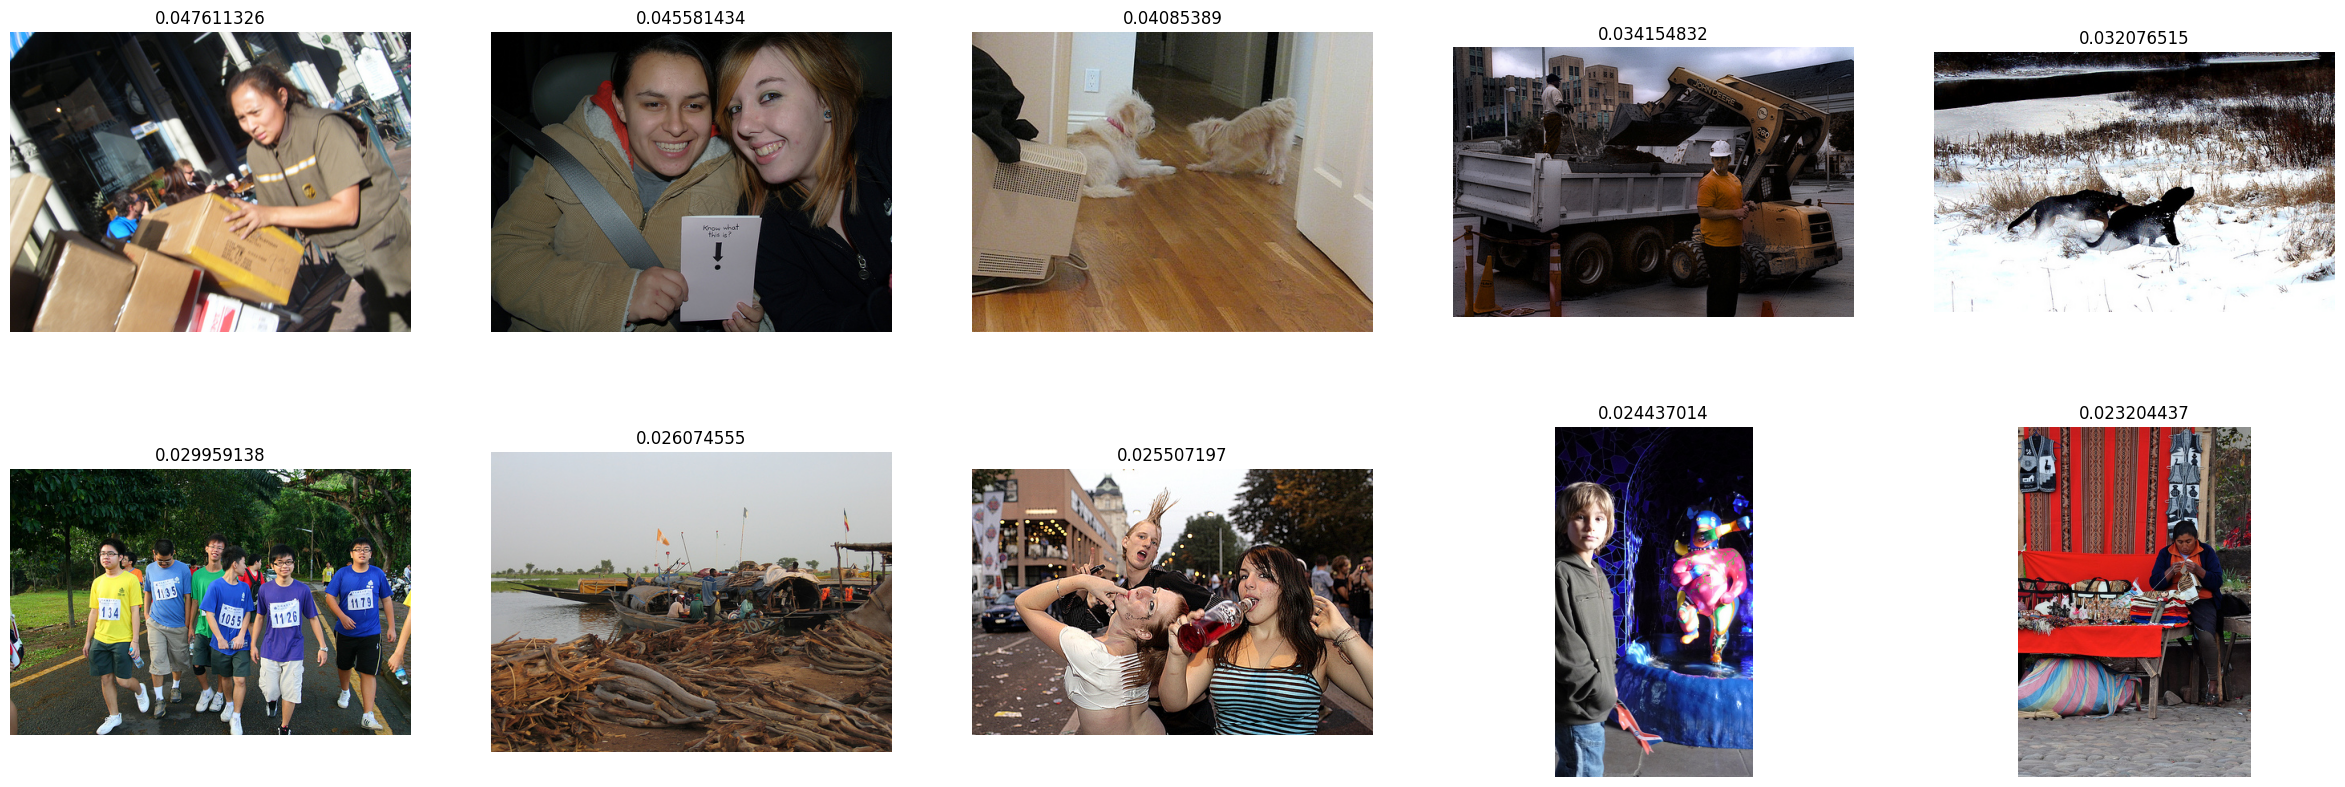

In [382]:
retrieve('Football')

Train on a very small dataset

In [59]:
data = next(iter(trainloader))

In [121]:
data = list()
k = 0
for batch in trainloader:
  if k == 30:
    break
  data.append(batch)
  k += 1

In [122]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

Epochs: [0|5000] || Iterations: [907|91607] || Loss:     0.4102 || Time:     4.2141s
Epochs: [1|5000] || Iterations: [1814|91607] || Loss:     0.4101 || Time:     3.8317s
Epochs: [2|5000] || Iterations: [2721|91607] || Loss:     0.4102 || Time:     3.7497s
Epochs: [3|5000] || Iterations: [3628|91607] || Loss:     0.4102 || Time:     3.8829s
Epochs: [4|5000] || Iterations: [4535|91607] || Loss:     0.4102 || Time:     3.8951s
Epochs: [5|5000] || Iterations: [5442|91607] || Loss:     0.4102 || Time:     3.9702s
Epochs: [6|5000] || Iterations: [6349|91607] || Loss:     0.4104 || Time:     3.8653s
Epochs: [7|5000] || Iterations: [7256|91607] || Loss:     0.4102 || Time:     3.8613s
Epochs: [8|5000] || Iterations: [8163|91607] || Loss:     0.4100 || Time:     3.8576s
Epochs: [9|5000] || Iterations: [9070|91607] || Loss:     0.4101 || Time:     4.0616s
Epochs: [10|5000] || Iterations: [9977|91607] || Loss:     0.4102 || Time:     3.8342s
Epochs: [11|5000] || Iterations: [10884|91607] || Loss

Epochs: [94|5000] || Iterations: [86165|91607] || Loss:     0.4100 || Time:     3.7868s
Epochs: [95|5000] || Iterations: [87072|91607] || Loss:     0.4102 || Time:     3.8937s
Epochs: [96|5000] || Iterations: [87979|91607] || Loss:     0.4104 || Time:     3.7951s
Epochs: [97|5000] || Iterations: [88886|91607] || Loss:     0.4101 || Time:     3.8696s
Epochs: [98|5000] || Iterations: [89793|91607] || Loss:     0.4101 || Time:     3.6793s
Epochs: [99|5000] || Iterations: [90700|91607] || Loss:     0.4101 || Time:     3.7520s
Epochs: [100|5000] || Iterations: [91607|91607] || Loss:     0.4100 || Time:     3.7257s
Epochs: [101|5000] || Iterations: [92514|91607] || Loss:     0.4109 || Time:     3.8259s
Epochs: [102|5000] || Iterations: [93421|91607] || Loss:     0.4101 || Time:     3.7501s
Epochs: [103|5000] || Iterations: [94328|91607] || Loss:     0.4102 || Time:     3.8765s
Epochs: [104|5000] || Iterations: [95235|91607] || Loss:     0.4099 || Time:     3.8160s
Epochs: [105|5000] || Itera

Epochs: [186|5000] || Iterations: [169609|91607] || Loss:     0.4102 || Time:     3.6665s
Epochs: [187|5000] || Iterations: [170516|91607] || Loss:     0.4101 || Time:     3.7228s
Epochs: [188|5000] || Iterations: [171423|91607] || Loss:     0.4102 || Time:     3.7002s
Epochs: [189|5000] || Iterations: [172330|91607] || Loss:     0.4101 || Time:     3.7651s
Epochs: [190|5000] || Iterations: [173237|91607] || Loss:     0.4101 || Time:     3.6721s
Epochs: [191|5000] || Iterations: [174144|91607] || Loss:     0.4101 || Time:     3.7728s
Epochs: [192|5000] || Iterations: [175051|91607] || Loss:     0.4099 || Time:     3.7121s
Epochs: [193|5000] || Iterations: [175958|91607] || Loss:     0.4104 || Time:     3.8276s
Epochs: [194|5000] || Iterations: [176865|91607] || Loss:     0.4103 || Time:     3.7565s
Epochs: [195|5000] || Iterations: [177772|91607] || Loss:     0.4104 || Time:     3.8625s
Epochs: [196|5000] || Iterations: [178679|91607] || Loss:     0.4102 || Time:     3.7632s
Epochs: [1

Epochs: [278|5000] || Iterations: [253053|91607] || Loss:     0.4101 || Time:     3.6395s
Epochs: [279|5000] || Iterations: [253960|91607] || Loss:     0.4101 || Time:     3.7334s
Epochs: [280|5000] || Iterations: [254867|91607] || Loss:     0.4101 || Time:     3.6663s
Epochs: [281|5000] || Iterations: [255774|91607] || Loss:     0.4101 || Time:     3.7186s
Epochs: [282|5000] || Iterations: [256681|91607] || Loss:     0.4101 || Time:     3.6391s
Epochs: [283|5000] || Iterations: [257588|91607] || Loss:     0.4102 || Time:     3.7784s
Epochs: [284|5000] || Iterations: [258495|91607] || Loss:     0.4100 || Time:     3.7120s
Epochs: [285|5000] || Iterations: [259402|91607] || Loss:     0.4103 || Time:     3.7831s
Epochs: [286|5000] || Iterations: [260309|91607] || Loss:     0.4102 || Time:     3.7154s
Epochs: [287|5000] || Iterations: [261216|91607] || Loss:     0.4101 || Time:     3.8700s
Epochs: [288|5000] || Iterations: [262123|91607] || Loss:     0.4101 || Time:     3.8606s
Epochs: [2

Epochs: [370|5000] || Iterations: [336497|91607] || Loss:     0.4102 || Time:     3.7340s
Epochs: [371|5000] || Iterations: [337404|91607] || Loss:     0.4097 || Time:     3.7043s
Epochs: [372|5000] || Iterations: [338311|91607] || Loss:     0.4105 || Time:     3.6950s
Epochs: [373|5000] || Iterations: [339218|91607] || Loss:     0.4095 || Time:     3.7425s
Epochs: [374|5000] || Iterations: [340125|91607] || Loss:     0.4103 || Time:     3.6461s
Epochs: [375|5000] || Iterations: [341032|91607] || Loss:     0.4106 || Time:     3.7582s
Epochs: [376|5000] || Iterations: [341939|91607] || Loss:     0.4101 || Time:     3.7289s
Epochs: [377|5000] || Iterations: [342846|91607] || Loss:     0.4104 || Time:     3.8812s
Epochs: [378|5000] || Iterations: [343753|91607] || Loss:     0.4102 || Time:     3.8247s
Epochs: [379|5000] || Iterations: [344660|91607] || Loss:     0.4101 || Time:     3.9585s
Epochs: [380|5000] || Iterations: [345567|91607] || Loss:     0.4100 || Time:     3.8293s
Epochs: [3

Epochs: [462|5000] || Iterations: [419941|91607] || Loss:     0.4101 || Time:     3.7461s
Epochs: [463|5000] || Iterations: [420848|91607] || Loss:     0.4101 || Time:     3.8014s
Epochs: [464|5000] || Iterations: [421755|91607] || Loss:     0.4101 || Time:     3.6624s
Epochs: [465|5000] || Iterations: [422662|91607] || Loss:     0.4101 || Time:     3.7421s
Epochs: [466|5000] || Iterations: [423569|91607] || Loss:     0.4101 || Time:     3.7201s
Epochs: [467|5000] || Iterations: [424476|91607] || Loss:     0.4101 || Time:     3.7192s
Epochs: [468|5000] || Iterations: [425383|91607] || Loss:     0.4101 || Time:     3.7756s
Epochs: [469|5000] || Iterations: [426290|91607] || Loss:     0.4102 || Time:     3.8043s
Epochs: [470|5000] || Iterations: [427197|91607] || Loss:     0.4101 || Time:     3.8359s
Epochs: [471|5000] || Iterations: [428104|91607] || Loss:     0.4102 || Time:     3.9373s
Epochs: [472|5000] || Iterations: [429011|91607] || Loss:     0.4101 || Time:     3.8128s
Epochs: [4

KeyboardInterrupt: 

In [244]:
data = list()
k = 0
for batch in trainloader:
  if k == 2:
    break
  data.append(batch)
  k += 1

In [184]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

Epochs: [0|5000] || Iterations: [907|91607] || Loss:     0.0273 || Time:     0.4768s
Epochs: [1|5000] || Iterations: [1814|91607] || Loss:     0.0277 || Time:     0.2451s
Epochs: [2|5000] || Iterations: [2721|91607] || Loss:     0.0277 || Time:     0.2485s
Epochs: [3|5000] || Iterations: [3628|91607] || Loss:     0.0273 || Time:     0.2583s
Epochs: [4|5000] || Iterations: [4535|91607] || Loss:     0.0275 || Time:     0.2457s
Epochs: [5|5000] || Iterations: [5442|91607] || Loss:     0.0271 || Time:     0.2654s
Epochs: [6|5000] || Iterations: [6349|91607] || Loss:     0.0272 || Time:     0.2828s
Epochs: [7|5000] || Iterations: [7256|91607] || Loss:     0.0273 || Time:     0.2559s
Epochs: [8|5000] || Iterations: [8163|91607] || Loss:     0.0271 || Time:     0.2712s
Epochs: [9|5000] || Iterations: [9070|91607] || Loss:     0.0277 || Time:     0.2564s
Epochs: [10|5000] || Iterations: [9977|91607] || Loss:     0.0270 || Time:     0.2543s
Epochs: [11|5000] || Iterations: [10884|91607] || Loss

Epochs: [94|5000] || Iterations: [86165|91607] || Loss:     0.0152 || Time:     0.2392s
Epochs: [95|5000] || Iterations: [87072|91607] || Loss:     0.0147 || Time:     0.2414s
Epochs: [96|5000] || Iterations: [87979|91607] || Loss:     0.0160 || Time:     0.2398s
Epochs: [97|5000] || Iterations: [88886|91607] || Loss:     0.0185 || Time:     0.2381s
Epochs: [98|5000] || Iterations: [89793|91607] || Loss:     0.0167 || Time:     0.2375s
Epochs: [99|5000] || Iterations: [90700|91607] || Loss:     0.0146 || Time:     0.2555s
Epochs: [100|5000] || Iterations: [91607|91607] || Loss:     0.0135 || Time:     0.2753s
Epochs: [101|5000] || Iterations: [92514|91607] || Loss:     0.0140 || Time:     0.2771s
Epochs: [102|5000] || Iterations: [93421|91607] || Loss:     0.0204 || Time:     0.2492s
Epochs: [103|5000] || Iterations: [94328|91607] || Loss:     0.0215 || Time:     0.2470s
Epochs: [104|5000] || Iterations: [95235|91607] || Loss:     0.0197 || Time:     0.2475s
Epochs: [105|5000] || Itera

Epochs: [186|5000] || Iterations: [169609|91607] || Loss:     0.0078 || Time:     0.2635s
Epochs: [187|5000] || Iterations: [170516|91607] || Loss:     0.0107 || Time:     0.2323s
Epochs: [188|5000] || Iterations: [171423|91607] || Loss:     0.0121 || Time:     0.2620s
Epochs: [189|5000] || Iterations: [172330|91607] || Loss:     0.0136 || Time:     0.2414s
Epochs: [190|5000] || Iterations: [173237|91607] || Loss:     0.0129 || Time:     0.2353s
Epochs: [191|5000] || Iterations: [174144|91607] || Loss:     0.0092 || Time:     0.2467s
Epochs: [192|5000] || Iterations: [175051|91607] || Loss:     0.0087 || Time:     0.2354s
Epochs: [193|5000] || Iterations: [175958|91607] || Loss:     0.0095 || Time:     0.2352s
Epochs: [194|5000] || Iterations: [176865|91607] || Loss:     0.0093 || Time:     0.2361s
Epochs: [195|5000] || Iterations: [177772|91607] || Loss:     0.0094 || Time:     0.2688s
Epochs: [196|5000] || Iterations: [178679|91607] || Loss:     0.0083 || Time:     0.2396s
Epochs: [1

Epochs: [278|5000] || Iterations: [253053|91607] || Loss:     0.0089 || Time:     0.2385s
Epochs: [279|5000] || Iterations: [253960|91607] || Loss:     0.0105 || Time:     0.2395s
Epochs: [280|5000] || Iterations: [254867|91607] || Loss:     0.0097 || Time:     0.2390s
Epochs: [281|5000] || Iterations: [255774|91607] || Loss:     0.0054 || Time:     0.2390s
Epochs: [282|5000] || Iterations: [256681|91607] || Loss:     0.0048 || Time:     0.2392s
Epochs: [283|5000] || Iterations: [257588|91607] || Loss:     0.0052 || Time:     0.2367s
Epochs: [284|5000] || Iterations: [258495|91607] || Loss:     0.0060 || Time:     0.2652s
Epochs: [285|5000] || Iterations: [259402|91607] || Loss:     0.0057 || Time:     0.2675s
Epochs: [286|5000] || Iterations: [260309|91607] || Loss:     0.0057 || Time:     0.2379s
Epochs: [287|5000] || Iterations: [261216|91607] || Loss:     0.0057 || Time:     0.2375s
Epochs: [288|5000] || Iterations: [262123|91607] || Loss:     0.0053 || Time:     0.2516s
Epochs: [2

Epochs: [370|5000] || Iterations: [336497|91607] || Loss:     0.0035 || Time:     0.2426s
Epochs: [371|5000] || Iterations: [337404|91607] || Loss:     0.0033 || Time:     0.2401s
Epochs: [372|5000] || Iterations: [338311|91607] || Loss:     0.0035 || Time:     0.2442s
Epochs: [373|5000] || Iterations: [339218|91607] || Loss:     0.0035 || Time:     0.2501s
Epochs: [374|5000] || Iterations: [340125|91607] || Loss:     0.0035 || Time:     0.2408s
Epochs: [375|5000] || Iterations: [341032|91607] || Loss:     0.0034 || Time:     0.2455s
Epochs: [376|5000] || Iterations: [341939|91607] || Loss:     0.0039 || Time:     0.2375s
Epochs: [377|5000] || Iterations: [342846|91607] || Loss:     0.0032 || Time:     0.2461s
Epochs: [378|5000] || Iterations: [343753|91607] || Loss:     0.0033 || Time:     0.2490s
Epochs: [379|5000] || Iterations: [344660|91607] || Loss:     0.0031 || Time:     0.2549s
Epochs: [380|5000] || Iterations: [345567|91607] || Loss:     0.0032 || Time:     0.2500s
Epochs: [3

Epochs: [462|5000] || Iterations: [419941|91607] || Loss:     0.0030 || Time:     0.2384s
Epochs: [463|5000] || Iterations: [420848|91607] || Loss:     0.0032 || Time:     0.2339s
Epochs: [464|5000] || Iterations: [421755|91607] || Loss:     0.0032 || Time:     0.2329s
Epochs: [465|5000] || Iterations: [422662|91607] || Loss:     0.0035 || Time:     0.2451s
Epochs: [466|5000] || Iterations: [423569|91607] || Loss:     0.0028 || Time:     0.2428s
Epochs: [467|5000] || Iterations: [424476|91607] || Loss:     0.0039 || Time:     0.2365s
Epochs: [468|5000] || Iterations: [425383|91607] || Loss:     0.0035 || Time:     0.2335s
Epochs: [469|5000] || Iterations: [426290|91607] || Loss:     0.0028 || Time:     0.2344s
Epochs: [470|5000] || Iterations: [427197|91607] || Loss:     0.0033 || Time:     0.2301s
Epochs: [471|5000] || Iterations: [428104|91607] || Loss:     0.0040 || Time:     0.2353s
Epochs: [472|5000] || Iterations: [429011|91607] || Loss:     0.0043 || Time:     0.2345s
Epochs: [4

Epochs: [554|5000] || Iterations: [503385|91607] || Loss:     0.0032 || Time:     0.2480s
Epochs: [555|5000] || Iterations: [504292|91607] || Loss:     0.0039 || Time:     0.2566s
Epochs: [556|5000] || Iterations: [505199|91607] || Loss:     0.0027 || Time:     0.2598s
Epochs: [557|5000] || Iterations: [506106|91607] || Loss:     0.0026 || Time:     0.2487s
Epochs: [558|5000] || Iterations: [507013|91607] || Loss:     0.0025 || Time:     0.2395s
Epochs: [559|5000] || Iterations: [507920|91607] || Loss:     0.0026 || Time:     0.2377s
Epochs: [560|5000] || Iterations: [508827|91607] || Loss:     0.0024 || Time:     0.2368s
Epochs: [561|5000] || Iterations: [509734|91607] || Loss:     0.0023 || Time:     0.2372s
Epochs: [562|5000] || Iterations: [510641|91607] || Loss:     0.0024 || Time:     0.2426s
Epochs: [563|5000] || Iterations: [511548|91607] || Loss:     0.0025 || Time:     0.2426s
Epochs: [564|5000] || Iterations: [512455|91607] || Loss:     0.0025 || Time:     0.2534s
Epochs: [5

Epochs: [646|5000] || Iterations: [586829|91607] || Loss:     0.0032 || Time:     0.2313s
Epochs: [647|5000] || Iterations: [587736|91607] || Loss:     0.0021 || Time:     0.2344s
Epochs: [648|5000] || Iterations: [588643|91607] || Loss:     0.0026 || Time:     0.2355s
Epochs: [649|5000] || Iterations: [589550|91607] || Loss:     0.0031 || Time:     0.2319s
Epochs: [650|5000] || Iterations: [590457|91607] || Loss:     0.0030 || Time:     0.2334s
Epochs: [651|5000] || Iterations: [591364|91607] || Loss:     0.0029 || Time:     0.2355s
Epochs: [652|5000] || Iterations: [592271|91607] || Loss:     0.0026 || Time:     0.2248s
Epochs: [653|5000] || Iterations: [593178|91607] || Loss:     0.0023 || Time:     0.2310s
Epochs: [654|5000] || Iterations: [594085|91607] || Loss:     0.0022 || Time:     0.2323s
Epochs: [655|5000] || Iterations: [594992|91607] || Loss:     0.0024 || Time:     0.2316s
Epochs: [656|5000] || Iterations: [595899|91607] || Loss:     0.0024 || Time:     0.2324s
Epochs: [6

Epochs: [738|5000] || Iterations: [670273|91607] || Loss:     0.0027 || Time:     0.2730s
Epochs: [739|5000] || Iterations: [671180|91607] || Loss:     0.0030 || Time:     0.2450s
Epochs: [740|5000] || Iterations: [672087|91607] || Loss:     0.0027 || Time:     0.2372s
Epochs: [741|5000] || Iterations: [672994|91607] || Loss:     0.0025 || Time:     0.2801s
Epochs: [742|5000] || Iterations: [673901|91607] || Loss:     0.0024 || Time:     0.2754s
Epochs: [743|5000] || Iterations: [674808|91607] || Loss:     0.0025 || Time:     0.2695s
Epochs: [744|5000] || Iterations: [675715|91607] || Loss:     0.0023 || Time:     0.2560s
Epochs: [745|5000] || Iterations: [676622|91607] || Loss:     0.0022 || Time:     0.2448s
Epochs: [746|5000] || Iterations: [677529|91607] || Loss:     0.0023 || Time:     0.2558s
Epochs: [747|5000] || Iterations: [678436|91607] || Loss:     0.0025 || Time:     0.2496s
Epochs: [748|5000] || Iterations: [679343|91607] || Loss:     0.0027 || Time:     0.2370s
Epochs: [7

Epochs: [830|5000] || Iterations: [753717|91607] || Loss:     0.0018 || Time:     0.2291s
Epochs: [831|5000] || Iterations: [754624|91607] || Loss:     0.0015 || Time:     0.2310s
Epochs: [832|5000] || Iterations: [755531|91607] || Loss:     0.0018 || Time:     0.2298s
Epochs: [833|5000] || Iterations: [756438|91607] || Loss:     0.0019 || Time:     0.2291s
Epochs: [834|5000] || Iterations: [757345|91607] || Loss:     0.0019 || Time:     0.2298s
Epochs: [835|5000] || Iterations: [758252|91607] || Loss:     0.0018 || Time:     0.2349s
Epochs: [836|5000] || Iterations: [759159|91607] || Loss:     0.0015 || Time:     0.2303s
Epochs: [837|5000] || Iterations: [760066|91607] || Loss:     0.0020 || Time:     0.2322s
Epochs: [838|5000] || Iterations: [760973|91607] || Loss:     0.0021 || Time:     0.2310s
Epochs: [839|5000] || Iterations: [761880|91607] || Loss:     0.0019 || Time:     0.2387s
Epochs: [840|5000] || Iterations: [762787|91607] || Loss:     0.0019 || Time:     0.2309s
Epochs: [8

Epochs: [922|5000] || Iterations: [837161|91607] || Loss:     0.0022 || Time:     0.2354s
Epochs: [923|5000] || Iterations: [838068|91607] || Loss:     0.0020 || Time:     0.2378s
Epochs: [924|5000] || Iterations: [838975|91607] || Loss:     0.0019 || Time:     0.2513s
Epochs: [925|5000] || Iterations: [839882|91607] || Loss:     0.0025 || Time:     0.2428s
Epochs: [926|5000] || Iterations: [840789|91607] || Loss:     0.0017 || Time:     0.2366s
Epochs: [927|5000] || Iterations: [841696|91607] || Loss:     0.0017 || Time:     0.2363s
Epochs: [928|5000] || Iterations: [842603|91607] || Loss:     0.0022 || Time:     0.2411s
Epochs: [929|5000] || Iterations: [843510|91607] || Loss:     0.0018 || Time:     0.2490s
Epochs: [930|5000] || Iterations: [844417|91607] || Loss:     0.0018 || Time:     0.2387s
Epochs: [931|5000] || Iterations: [845324|91607] || Loss:     0.0024 || Time:     0.2451s
Epochs: [932|5000] || Iterations: [846231|91607] || Loss:     0.0015 || Time:     0.2409s
Epochs: [9

Epochs: [1013|5000] || Iterations: [919698|91607] || Loss:     0.0021 || Time:     0.2534s
Epochs: [1014|5000] || Iterations: [920605|91607] || Loss:     0.0022 || Time:     0.2709s
Epochs: [1015|5000] || Iterations: [921512|91607] || Loss:     0.0023 || Time:     0.2754s
Epochs: [1016|5000] || Iterations: [922419|91607] || Loss:     0.0019 || Time:     0.2531s
Epochs: [1017|5000] || Iterations: [923326|91607] || Loss:     0.0016 || Time:     0.2583s
Epochs: [1018|5000] || Iterations: [924233|91607] || Loss:     0.0016 || Time:     0.2608s
Epochs: [1019|5000] || Iterations: [925140|91607] || Loss:     0.0017 || Time:     0.2401s
Epochs: [1020|5000] || Iterations: [926047|91607] || Loss:     0.0021 || Time:     0.2653s
Epochs: [1021|5000] || Iterations: [926954|91607] || Loss:     0.0017 || Time:     0.2719s
Epochs: [1022|5000] || Iterations: [927861|91607] || Loss:     0.0017 || Time:     0.2635s
Epochs: [1023|5000] || Iterations: [928768|91607] || Loss:     0.0015 || Time:     0.2401s

Epochs: [1104|5000] || Iterations: [1002235|91607] || Loss:     0.0017 || Time:     0.2373s
Epochs: [1105|5000] || Iterations: [1003142|91607] || Loss:     0.0032 || Time:     0.2321s
Epochs: [1106|5000] || Iterations: [1004049|91607] || Loss:     0.0016 || Time:     0.2361s
Epochs: [1107|5000] || Iterations: [1004956|91607] || Loss:     0.0020 || Time:     0.2354s
Epochs: [1108|5000] || Iterations: [1005863|91607] || Loss:     0.0027 || Time:     0.2378s
Epochs: [1109|5000] || Iterations: [1006770|91607] || Loss:     0.0027 || Time:     0.2356s
Epochs: [1110|5000] || Iterations: [1007677|91607] || Loss:     0.0022 || Time:     0.2370s
Epochs: [1111|5000] || Iterations: [1008584|91607] || Loss:     0.0019 || Time:     0.2333s
Epochs: [1112|5000] || Iterations: [1009491|91607] || Loss:     0.0024 || Time:     0.2315s
Epochs: [1113|5000] || Iterations: [1010398|91607] || Loss:     0.0026 || Time:     0.2350s
Epochs: [1114|5000] || Iterations: [1011305|91607] || Loss:     0.0035 || Time: 

Epochs: [1194|5000] || Iterations: [1083865|91607] || Loss:     0.0019 || Time:     0.2385s
Epochs: [1195|5000] || Iterations: [1084772|91607] || Loss:     0.0016 || Time:     0.2437s
Epochs: [1196|5000] || Iterations: [1085679|91607] || Loss:     0.0014 || Time:     0.2423s
Epochs: [1197|5000] || Iterations: [1086586|91607] || Loss:     0.0021 || Time:     0.2433s
Epochs: [1198|5000] || Iterations: [1087493|91607] || Loss:     0.0023 || Time:     0.2477s
Epochs: [1199|5000] || Iterations: [1088400|91607] || Loss:     0.0022 || Time:     0.2549s
Epochs: [1200|5000] || Iterations: [1089307|91607] || Loss:     0.0019 || Time:     0.2464s
Epochs: [1201|5000] || Iterations: [1090214|91607] || Loss:     0.0029 || Time:     0.2415s
Epochs: [1202|5000] || Iterations: [1091121|91607] || Loss:     0.0024 || Time:     0.2365s
Epochs: [1203|5000] || Iterations: [1092028|91607] || Loss:     0.0032 || Time:     0.2386s
Epochs: [1204|5000] || Iterations: [1092935|91607] || Loss:     0.0030 || Time: 

Epochs: [1284|5000] || Iterations: [1165495|91607] || Loss:     0.0016 || Time:     0.2305s
Epochs: [1285|5000] || Iterations: [1166402|91607] || Loss:     0.0017 || Time:     0.2523s
Epochs: [1286|5000] || Iterations: [1167309|91607] || Loss:     0.0029 || Time:     0.2481s
Epochs: [1287|5000] || Iterations: [1168216|91607] || Loss:     0.0024 || Time:     0.2380s
Epochs: [1288|5000] || Iterations: [1169123|91607] || Loss:     0.0030 || Time:     0.2779s
Epochs: [1289|5000] || Iterations: [1170030|91607] || Loss:     0.0032 || Time:     0.2761s
Epochs: [1290|5000] || Iterations: [1170937|91607] || Loss:     0.0028 || Time:     0.2707s
Epochs: [1291|5000] || Iterations: [1171844|91607] || Loss:     0.0016 || Time:     0.2592s
Epochs: [1292|5000] || Iterations: [1172751|91607] || Loss:     0.0019 || Time:     0.2561s
Epochs: [1293|5000] || Iterations: [1173658|91607] || Loss:     0.0019 || Time:     0.2292s
Epochs: [1294|5000] || Iterations: [1174565|91607] || Loss:     0.0019 || Time: 

Epochs: [1374|5000] || Iterations: [1247125|91607] || Loss:     0.0019 || Time:     0.2403s
Epochs: [1375|5000] || Iterations: [1248032|91607] || Loss:     0.0018 || Time:     0.2390s
Epochs: [1376|5000] || Iterations: [1248939|91607] || Loss:     0.0014 || Time:     0.2330s
Epochs: [1377|5000] || Iterations: [1249846|91607] || Loss:     0.0015 || Time:     0.2423s
Epochs: [1378|5000] || Iterations: [1250753|91607] || Loss:     0.0016 || Time:     0.2513s
Epochs: [1379|5000] || Iterations: [1251660|91607] || Loss:     0.0016 || Time:     0.2362s
Epochs: [1380|5000] || Iterations: [1252567|91607] || Loss:     0.0016 || Time:     0.2282s
Epochs: [1381|5000] || Iterations: [1253474|91607] || Loss:     0.0014 || Time:     0.2395s
Epochs: [1382|5000] || Iterations: [1254381|91607] || Loss:     0.0017 || Time:     0.2436s
Epochs: [1383|5000] || Iterations: [1255288|91607] || Loss:     0.0018 || Time:     0.2448s
Epochs: [1384|5000] || Iterations: [1256195|91607] || Loss:     0.0017 || Time: 

Epochs: [1464|5000] || Iterations: [1328755|91607] || Loss:     0.0027 || Time:     0.2457s
Epochs: [1465|5000] || Iterations: [1329662|91607] || Loss:     0.0025 || Time:     0.2490s
Epochs: [1466|5000] || Iterations: [1330569|91607] || Loss:     0.0026 || Time:     0.2439s
Epochs: [1467|5000] || Iterations: [1331476|91607] || Loss:     0.0020 || Time:     0.2355s
Epochs: [1468|5000] || Iterations: [1332383|91607] || Loss:     0.0021 || Time:     0.2358s
Epochs: [1469|5000] || Iterations: [1333290|91607] || Loss:     0.0023 || Time:     0.2472s
Epochs: [1470|5000] || Iterations: [1334197|91607] || Loss:     0.0025 || Time:     0.2450s
Epochs: [1471|5000] || Iterations: [1335104|91607] || Loss:     0.0018 || Time:     0.2391s
Epochs: [1472|5000] || Iterations: [1336011|91607] || Loss:     0.0017 || Time:     0.2404s
Epochs: [1473|5000] || Iterations: [1336918|91607] || Loss:     0.0019 || Time:     0.2369s
Epochs: [1474|5000] || Iterations: [1337825|91607] || Loss:     0.0016 || Time: 

Epochs: [1554|5000] || Iterations: [1410385|91607] || Loss:     0.0017 || Time:     0.2325s
Epochs: [1555|5000] || Iterations: [1411292|91607] || Loss:     0.0016 || Time:     0.2317s
Epochs: [1556|5000] || Iterations: [1412199|91607] || Loss:     0.0013 || Time:     0.2298s
Epochs: [1557|5000] || Iterations: [1413106|91607] || Loss:     0.0015 || Time:     0.2334s
Epochs: [1558|5000] || Iterations: [1414013|91607] || Loss:     0.0018 || Time:     0.2309s
Epochs: [1559|5000] || Iterations: [1414920|91607] || Loss:     0.0017 || Time:     0.2292s
Epochs: [1560|5000] || Iterations: [1415827|91607] || Loss:     0.0017 || Time:     0.2317s
Epochs: [1561|5000] || Iterations: [1416734|91607] || Loss:     0.0012 || Time:     0.2391s
Epochs: [1562|5000] || Iterations: [1417641|91607] || Loss:     0.0022 || Time:     0.2301s
Epochs: [1563|5000] || Iterations: [1418548|91607] || Loss:     0.0018 || Time:     0.2318s
Epochs: [1564|5000] || Iterations: [1419455|91607] || Loss:     0.0019 || Time: 

Epochs: [1644|5000] || Iterations: [1492015|91607] || Loss:     0.0013 || Time:     0.2323s
Epochs: [1645|5000] || Iterations: [1492922|91607] || Loss:     0.0014 || Time:     0.2380s
Epochs: [1646|5000] || Iterations: [1493829|91607] || Loss:     0.0012 || Time:     0.2325s
Epochs: [1647|5000] || Iterations: [1494736|91607] || Loss:     0.0012 || Time:     0.2312s
Epochs: [1648|5000] || Iterations: [1495643|91607] || Loss:     0.0012 || Time:     0.2341s
Epochs: [1649|5000] || Iterations: [1496550|91607] || Loss:     0.0013 || Time:     0.2318s
Epochs: [1650|5000] || Iterations: [1497457|91607] || Loss:     0.0012 || Time:     0.2363s
Epochs: [1651|5000] || Iterations: [1498364|91607] || Loss:     0.0012 || Time:     0.2377s
Epochs: [1652|5000] || Iterations: [1499271|91607] || Loss:     0.0012 || Time:     0.2358s
Epochs: [1653|5000] || Iterations: [1500178|91607] || Loss:     0.0012 || Time:     0.2378s
Epochs: [1654|5000] || Iterations: [1501085|91607] || Loss:     0.0011 || Time: 

Epochs: [1734|5000] || Iterations: [1573645|91607] || Loss:     0.0011 || Time:     0.2369s
Epochs: [1735|5000] || Iterations: [1574552|91607] || Loss:     0.0012 || Time:     0.2349s
Epochs: [1736|5000] || Iterations: [1575459|91607] || Loss:     0.0011 || Time:     0.2372s
Epochs: [1737|5000] || Iterations: [1576366|91607] || Loss:     0.0013 || Time:     0.2377s
Epochs: [1738|5000] || Iterations: [1577273|91607] || Loss:     0.0016 || Time:     0.2376s
Epochs: [1739|5000] || Iterations: [1578180|91607] || Loss:     0.0015 || Time:     0.2367s
Epochs: [1740|5000] || Iterations: [1579087|91607] || Loss:     0.0014 || Time:     0.2317s
Epochs: [1741|5000] || Iterations: [1579994|91607] || Loss:     0.0010 || Time:     0.2319s
Epochs: [1742|5000] || Iterations: [1580901|91607] || Loss:     0.0012 || Time:     0.2312s
Epochs: [1743|5000] || Iterations: [1581808|91607] || Loss:     0.0023 || Time:     0.2282s
Epochs: [1744|5000] || Iterations: [1582715|91607] || Loss:     0.0017 || Time: 

Epochs: [1824|5000] || Iterations: [1655275|91607] || Loss:     0.0017 || Time:     0.2317s
Epochs: [1825|5000] || Iterations: [1656182|91607] || Loss:     0.0016 || Time:     0.2328s
Epochs: [1826|5000] || Iterations: [1657089|91607] || Loss:     0.0011 || Time:     0.2315s
Epochs: [1827|5000] || Iterations: [1657996|91607] || Loss:     0.0011 || Time:     0.2325s
Epochs: [1828|5000] || Iterations: [1658903|91607] || Loss:     0.0016 || Time:     0.2314s
Epochs: [1829|5000] || Iterations: [1659810|91607] || Loss:     0.0027 || Time:     0.2301s
Epochs: [1830|5000] || Iterations: [1660717|91607] || Loss:     0.0015 || Time:     0.2303s
Epochs: [1831|5000] || Iterations: [1661624|91607] || Loss:     0.0013 || Time:     0.2301s
Epochs: [1832|5000] || Iterations: [1662531|91607] || Loss:     0.0010 || Time:     0.2306s
Epochs: [1833|5000] || Iterations: [1663438|91607] || Loss:     0.0014 || Time:     0.2347s
Epochs: [1834|5000] || Iterations: [1664345|91607] || Loss:     0.0015 || Time: 

Epochs: [1914|5000] || Iterations: [1736905|91607] || Loss:     0.0011 || Time:     0.2338s
Epochs: [1915|5000] || Iterations: [1737812|91607] || Loss:     0.0013 || Time:     0.2323s
Epochs: [1916|5000] || Iterations: [1738719|91607] || Loss:     0.0009 || Time:     0.2376s
Epochs: [1917|5000] || Iterations: [1739626|91607] || Loss:     0.0010 || Time:     0.2334s
Epochs: [1918|5000] || Iterations: [1740533|91607] || Loss:     0.0011 || Time:     0.2341s
Epochs: [1919|5000] || Iterations: [1741440|91607] || Loss:     0.0014 || Time:     0.2341s
Epochs: [1920|5000] || Iterations: [1742347|91607] || Loss:     0.0012 || Time:     0.2479s
Epochs: [1921|5000] || Iterations: [1743254|91607] || Loss:     0.0025 || Time:     0.2340s
Epochs: [1922|5000] || Iterations: [1744161|91607] || Loss:     0.0010 || Time:     0.2360s
Epochs: [1923|5000] || Iterations: [1745068|91607] || Loss:     0.0013 || Time:     0.2351s
Epochs: [1924|5000] || Iterations: [1745975|91607] || Loss:     0.0012 || Time: 

Epochs: [2004|5000] || Iterations: [1818535|91607] || Loss:     0.0013 || Time:     0.2287s
Epochs: [2005|5000] || Iterations: [1819442|91607] || Loss:     0.0012 || Time:     0.2319s
Epochs: [2006|5000] || Iterations: [1820349|91607] || Loss:     0.0010 || Time:     0.2285s
Epochs: [2007|5000] || Iterations: [1821256|91607] || Loss:     0.0010 || Time:     0.2323s
Epochs: [2008|5000] || Iterations: [1822163|91607] || Loss:     0.0012 || Time:     0.2374s
Epochs: [2009|5000] || Iterations: [1823070|91607] || Loss:     0.0012 || Time:     0.2321s
Epochs: [2010|5000] || Iterations: [1823977|91607] || Loss:     0.0013 || Time:     0.2305s
Epochs: [2011|5000] || Iterations: [1824884|91607] || Loss:     0.0009 || Time:     0.2329s
Epochs: [2012|5000] || Iterations: [1825791|91607] || Loss:     0.0010 || Time:     0.2306s
Epochs: [2013|5000] || Iterations: [1826698|91607] || Loss:     0.0011 || Time:     0.2290s
Epochs: [2014|5000] || Iterations: [1827605|91607] || Loss:     0.0012 || Time: 

Epochs: [2094|5000] || Iterations: [1900165|91607] || Loss:     0.0008 || Time:     0.2333s
Epochs: [2095|5000] || Iterations: [1901072|91607] || Loss:     0.0009 || Time:     0.2356s
Epochs: [2096|5000] || Iterations: [1901979|91607] || Loss:     0.0008 || Time:     0.2422s
Epochs: [2097|5000] || Iterations: [1902886|91607] || Loss:     0.0008 || Time:     0.2315s
Epochs: [2098|5000] || Iterations: [1903793|91607] || Loss:     0.0009 || Time:     0.2302s
Epochs: [2099|5000] || Iterations: [1904700|91607] || Loss:     0.0010 || Time:     0.2349s
Epochs: [2100|5000] || Iterations: [1905607|91607] || Loss:     0.0008 || Time:     0.2424s
Epochs: [2101|5000] || Iterations: [1906514|91607] || Loss:     0.0007 || Time:     0.2362s
Epochs: [2102|5000] || Iterations: [1907421|91607] || Loss:     0.0008 || Time:     0.2391s
Epochs: [2103|5000] || Iterations: [1908328|91607] || Loss:     0.0008 || Time:     0.2322s
Epochs: [2104|5000] || Iterations: [1909235|91607] || Loss:     0.0008 || Time: 

Epochs: [2184|5000] || Iterations: [1981795|91607] || Loss:     0.0006 || Time:     0.2396s
Epochs: [2185|5000] || Iterations: [1982702|91607] || Loss:     0.0007 || Time:     0.2408s
Epochs: [2186|5000] || Iterations: [1983609|91607] || Loss:     0.0005 || Time:     0.2422s
Epochs: [2187|5000] || Iterations: [1984516|91607] || Loss:     0.0004 || Time:     0.2375s
Epochs: [2188|5000] || Iterations: [1985423|91607] || Loss:     0.0006 || Time:     0.2435s
Epochs: [2189|5000] || Iterations: [1986330|91607] || Loss:     0.0005 || Time:     0.2333s
Epochs: [2190|5000] || Iterations: [1987237|91607] || Loss:     0.0005 || Time:     0.2390s
Epochs: [2191|5000] || Iterations: [1988144|91607] || Loss:     0.0005 || Time:     0.2403s
Epochs: [2192|5000] || Iterations: [1989051|91607] || Loss:     0.0006 || Time:     0.2355s
Epochs: [2193|5000] || Iterations: [1989958|91607] || Loss:     0.0006 || Time:     0.2379s
Epochs: [2194|5000] || Iterations: [1990865|91607] || Loss:     0.0006 || Time: 

Epochs: [2274|5000] || Iterations: [2063425|91607] || Loss:     0.0004 || Time:     0.2322s
Epochs: [2275|5000] || Iterations: [2064332|91607] || Loss:     0.0005 || Time:     0.2338s
Epochs: [2276|5000] || Iterations: [2065239|91607] || Loss:     0.0003 || Time:     0.2311s
Epochs: [2277|5000] || Iterations: [2066146|91607] || Loss:     0.0004 || Time:     0.2319s
Epochs: [2278|5000] || Iterations: [2067053|91607] || Loss:     0.0005 || Time:     0.2291s
Epochs: [2279|5000] || Iterations: [2067960|91607] || Loss:     0.0005 || Time:     0.2353s
Epochs: [2280|5000] || Iterations: [2068867|91607] || Loss:     0.0005 || Time:     0.2324s
Epochs: [2281|5000] || Iterations: [2069774|91607] || Loss:     0.0004 || Time:     0.2330s
Epochs: [2282|5000] || Iterations: [2070681|91607] || Loss:     0.0007 || Time:     0.2315s
Epochs: [2283|5000] || Iterations: [2071588|91607] || Loss:     0.0005 || Time:     0.2284s
Epochs: [2284|5000] || Iterations: [2072495|91607] || Loss:     0.0005 || Time: 

Epochs: [2364|5000] || Iterations: [2145055|91607] || Loss:     0.0007 || Time:     0.2337s
Epochs: [2365|5000] || Iterations: [2145962|91607] || Loss:     0.0006 || Time:     0.2327s
Epochs: [2366|5000] || Iterations: [2146869|91607] || Loss:     0.0004 || Time:     0.2326s
Epochs: [2367|5000] || Iterations: [2147776|91607] || Loss:     0.0005 || Time:     0.2390s
Epochs: [2368|5000] || Iterations: [2148683|91607] || Loss:     0.0007 || Time:     0.2388s
Epochs: [2369|5000] || Iterations: [2149590|91607] || Loss:     0.0008 || Time:     0.2444s
Epochs: [2370|5000] || Iterations: [2150497|91607] || Loss:     0.0009 || Time:     0.2394s
Epochs: [2371|5000] || Iterations: [2151404|91607] || Loss:     0.0003 || Time:     0.2361s
Epochs: [2372|5000] || Iterations: [2152311|91607] || Loss:     0.0004 || Time:     0.2351s
Epochs: [2373|5000] || Iterations: [2153218|91607] || Loss:     0.0006 || Time:     0.2363s
Epochs: [2374|5000] || Iterations: [2154125|91607] || Loss:     0.0008 || Time: 

Epochs: [2454|5000] || Iterations: [2226685|91607] || Loss:     0.0002 || Time:     0.2433s
Epochs: [2455|5000] || Iterations: [2227592|91607] || Loss:     0.0002 || Time:     0.2404s
Epochs: [2456|5000] || Iterations: [2228499|91607] || Loss:     0.0001 || Time:     0.2510s
Epochs: [2457|5000] || Iterations: [2229406|91607] || Loss:     0.0003 || Time:     0.2383s
Epochs: [2458|5000] || Iterations: [2230313|91607] || Loss:     0.0003 || Time:     0.2290s
Epochs: [2459|5000] || Iterations: [2231220|91607] || Loss:     0.0003 || Time:     0.2344s
Epochs: [2460|5000] || Iterations: [2232127|91607] || Loss:     0.0002 || Time:     0.2340s
Epochs: [2461|5000] || Iterations: [2233034|91607] || Loss:     0.0001 || Time:     0.2315s
Epochs: [2462|5000] || Iterations: [2233941|91607] || Loss:     0.0003 || Time:     0.2282s
Epochs: [2463|5000] || Iterations: [2234848|91607] || Loss:     0.0003 || Time:     0.2304s
Epochs: [2464|5000] || Iterations: [2235755|91607] || Loss:     0.0003 || Time: 

Epochs: [2544|5000] || Iterations: [2308315|91607] || Loss:     0.0005 || Time:     0.2339s
Epochs: [2545|5000] || Iterations: [2309222|91607] || Loss:     0.0006 || Time:     0.2384s
Epochs: [2546|5000] || Iterations: [2310129|91607] || Loss:     0.0002 || Time:     0.2403s
Epochs: [2547|5000] || Iterations: [2311036|91607] || Loss:     0.0002 || Time:     0.2334s
Epochs: [2548|5000] || Iterations: [2311943|91607] || Loss:     0.0002 || Time:     0.2395s
Epochs: [2549|5000] || Iterations: [2312850|91607] || Loss:     0.0004 || Time:     0.2457s
Epochs: [2550|5000] || Iterations: [2313757|91607] || Loss:     0.0004 || Time:     0.2328s
Epochs: [2551|5000] || Iterations: [2314664|91607] || Loss:     0.0003 || Time:     0.2776s
Epochs: [2552|5000] || Iterations: [2315571|91607] || Loss:     0.0003 || Time:     0.2519s
Epochs: [2553|5000] || Iterations: [2316478|91607] || Loss:     0.0003 || Time:     0.2362s
Epochs: [2554|5000] || Iterations: [2317385|91607] || Loss:     0.0003 || Time: 

Epochs: [2634|5000] || Iterations: [2389945|91607] || Loss:     0.0003 || Time:     0.2701s
Epochs: [2635|5000] || Iterations: [2390852|91607] || Loss:     0.0002 || Time:     0.2656s
Epochs: [2636|5000] || Iterations: [2391759|91607] || Loss:     0.0001 || Time:     0.2534s
Epochs: [2637|5000] || Iterations: [2392666|91607] || Loss:     0.0001 || Time:     0.2337s
Epochs: [2638|5000] || Iterations: [2393573|91607] || Loss:     0.0003 || Time:     0.2477s
Epochs: [2639|5000] || Iterations: [2394480|91607] || Loss:     0.0003 || Time:     0.2700s
Epochs: [2640|5000] || Iterations: [2395387|91607] || Loss:     0.0003 || Time:     0.2687s
Epochs: [2641|5000] || Iterations: [2396294|91607] || Loss:     0.0001 || Time:     0.2659s
Epochs: [2642|5000] || Iterations: [2397201|91607] || Loss:     0.0001 || Time:     0.2577s
Epochs: [2643|5000] || Iterations: [2398108|91607] || Loss:     0.0003 || Time:     0.2396s
Epochs: [2644|5000] || Iterations: [2399015|91607] || Loss:     0.0003 || Time: 

Epochs: [2724|5000] || Iterations: [2471575|91607] || Loss:     0.0001 || Time:     0.2300s
Epochs: [2725|5000] || Iterations: [2472482|91607] || Loss:     0.0000 || Time:     0.2450s
Epochs: [2726|5000] || Iterations: [2473389|91607] || Loss:     0.0001 || Time:     0.2463s
Epochs: [2727|5000] || Iterations: [2474296|91607] || Loss:     0.0001 || Time:     0.2460s
Epochs: [2728|5000] || Iterations: [2475203|91607] || Loss:     0.0001 || Time:     0.2476s
Epochs: [2729|5000] || Iterations: [2476110|91607] || Loss:     0.0001 || Time:     0.2326s
Epochs: [2730|5000] || Iterations: [2477017|91607] || Loss:     0.0001 || Time:     0.2333s
Epochs: [2731|5000] || Iterations: [2477924|91607] || Loss:     0.0000 || Time:     0.2308s
Epochs: [2732|5000] || Iterations: [2478831|91607] || Loss:     0.0001 || Time:     0.2302s
Epochs: [2733|5000] || Iterations: [2479738|91607] || Loss:     0.0001 || Time:     0.2307s
Epochs: [2734|5000] || Iterations: [2480645|91607] || Loss:     0.0000 || Time: 

Epochs: [2814|5000] || Iterations: [2553205|91607] || Loss:     0.0003 || Time:     0.2368s
Epochs: [2815|5000] || Iterations: [2554112|91607] || Loss:     0.0001 || Time:     0.2348s
Epochs: [2816|5000] || Iterations: [2555019|91607] || Loss:     0.0003 || Time:     0.2339s
Epochs: [2817|5000] || Iterations: [2555926|91607] || Loss:     0.0001 || Time:     0.2351s
Epochs: [2818|5000] || Iterations: [2556833|91607] || Loss:     0.0002 || Time:     0.2394s
Epochs: [2819|5000] || Iterations: [2557740|91607] || Loss:     0.0001 || Time:     0.2367s
Epochs: [2820|5000] || Iterations: [2558647|91607] || Loss:     0.0001 || Time:     0.2380s
Epochs: [2821|5000] || Iterations: [2559554|91607] || Loss:     0.0003 || Time:     0.2424s
Epochs: [2822|5000] || Iterations: [2560461|91607] || Loss:     0.0001 || Time:     0.2339s
Epochs: [2823|5000] || Iterations: [2561368|91607] || Loss:     0.0001 || Time:     0.2329s
Epochs: [2824|5000] || Iterations: [2562275|91607] || Loss:     0.0001 || Time: 

Epochs: [2904|5000] || Iterations: [2634835|91607] || Loss:     0.0001 || Time:     0.2350s
Epochs: [2905|5000] || Iterations: [2635742|91607] || Loss:     0.0001 || Time:     0.2502s
Epochs: [2906|5000] || Iterations: [2636649|91607] || Loss:     0.0000 || Time:     0.2465s
Epochs: [2907|5000] || Iterations: [2637556|91607] || Loss:     0.0000 || Time:     0.2543s
Epochs: [2908|5000] || Iterations: [2638463|91607] || Loss:     0.0001 || Time:     0.2380s
Epochs: [2909|5000] || Iterations: [2639370|91607] || Loss:     0.0001 || Time:     0.2577s
Epochs: [2910|5000] || Iterations: [2640277|91607] || Loss:     0.0001 || Time:     0.2504s
Epochs: [2911|5000] || Iterations: [2641184|91607] || Loss:     0.0000 || Time:     0.2583s
Epochs: [2912|5000] || Iterations: [2642091|91607] || Loss:     0.0001 || Time:     0.2422s
Epochs: [2913|5000] || Iterations: [2642998|91607] || Loss:     0.0000 || Time:     0.2420s
Epochs: [2914|5000] || Iterations: [2643905|91607] || Loss:     0.0001 || Time: 

Epochs: [2994|5000] || Iterations: [2716465|91607] || Loss:     0.0000 || Time:     0.2484s
Epochs: [2995|5000] || Iterations: [2717372|91607] || Loss:     0.0001 || Time:     0.2503s
Epochs: [2996|5000] || Iterations: [2718279|91607] || Loss:     0.0000 || Time:     0.2499s
Epochs: [2997|5000] || Iterations: [2719186|91607] || Loss:     0.0000 || Time:     0.2517s
Epochs: [2998|5000] || Iterations: [2720093|91607] || Loss:     0.0000 || Time:     0.2602s
Epochs: [2999|5000] || Iterations: [2721000|91607] || Loss:     0.0000 || Time:     0.2353s
Epochs: [3000|5000] || Iterations: [2721907|91607] || Loss:     0.0000 || Time:     0.2425s
Epochs: [3001|5000] || Iterations: [2722814|91607] || Loss:     0.0000 || Time:     0.2397s
Epochs: [3002|5000] || Iterations: [2723721|91607] || Loss:     0.0000 || Time:     0.2591s
Epochs: [3003|5000] || Iterations: [2724628|91607] || Loss:     0.0000 || Time:     0.2589s
Epochs: [3004|5000] || Iterations: [2725535|91607] || Loss:     0.0000 || Time: 

Epochs: [3084|5000] || Iterations: [2798095|91607] || Loss:     0.0003 || Time:     0.2399s
Epochs: [3085|5000] || Iterations: [2799002|91607] || Loss:     0.0003 || Time:     0.2524s
Epochs: [3086|5000] || Iterations: [2799909|91607] || Loss:     0.0000 || Time:     0.2605s
Epochs: [3087|5000] || Iterations: [2800816|91607] || Loss:     0.0002 || Time:     0.2659s
Epochs: [3088|5000] || Iterations: [2801723|91607] || Loss:     0.0003 || Time:     0.2642s
Epochs: [3089|5000] || Iterations: [2802630|91607] || Loss:     0.0002 || Time:     0.2734s
Epochs: [3090|5000] || Iterations: [2803537|91607] || Loss:     0.0002 || Time:     0.2584s
Epochs: [3091|5000] || Iterations: [2804444|91607] || Loss:     0.0001 || Time:     0.2443s
Epochs: [3092|5000] || Iterations: [2805351|91607] || Loss:     0.0001 || Time:     0.2484s
Epochs: [3093|5000] || Iterations: [2806258|91607] || Loss:     0.0003 || Time:     0.2419s
Epochs: [3094|5000] || Iterations: [2807165|91607] || Loss:     0.0003 || Time: 

Epochs: [3174|5000] || Iterations: [2879725|91607] || Loss:     0.0001 || Time:     0.2318s
Epochs: [3175|5000] || Iterations: [2880632|91607] || Loss:     0.0001 || Time:     0.2329s
Epochs: [3176|5000] || Iterations: [2881539|91607] || Loss:     0.0000 || Time:     0.2316s
Epochs: [3177|5000] || Iterations: [2882446|91607] || Loss:     0.0000 || Time:     0.2313s
Epochs: [3178|5000] || Iterations: [2883353|91607] || Loss:     0.0001 || Time:     0.2298s
Epochs: [3179|5000] || Iterations: [2884260|91607] || Loss:     0.0001 || Time:     0.2367s
Epochs: [3180|5000] || Iterations: [2885167|91607] || Loss:     0.0001 || Time:     0.2340s
Epochs: [3181|5000] || Iterations: [2886074|91607] || Loss:     0.0000 || Time:     0.2338s
Epochs: [3182|5000] || Iterations: [2886981|91607] || Loss:     0.0001 || Time:     0.2328s
Epochs: [3183|5000] || Iterations: [2887888|91607] || Loss:     0.0001 || Time:     0.2348s
Epochs: [3184|5000] || Iterations: [2888795|91607] || Loss:     0.0001 || Time: 

Epochs: [3264|5000] || Iterations: [2961355|91607] || Loss:     0.0001 || Time:     0.2588s
Epochs: [3265|5000] || Iterations: [2962262|91607] || Loss:     0.0001 || Time:     0.2593s
Epochs: [3266|5000] || Iterations: [2963169|91607] || Loss:     0.0000 || Time:     0.2464s
Epochs: [3267|5000] || Iterations: [2964076|91607] || Loss:     0.0000 || Time:     0.2665s
Epochs: [3268|5000] || Iterations: [2964983|91607] || Loss:     0.0001 || Time:     0.2587s
Epochs: [3269|5000] || Iterations: [2965890|91607] || Loss:     0.0000 || Time:     0.2441s
Epochs: [3270|5000] || Iterations: [2966797|91607] || Loss:     0.0000 || Time:     0.2423s
Epochs: [3271|5000] || Iterations: [2967704|91607] || Loss:     0.0000 || Time:     0.2394s
Epochs: [3272|5000] || Iterations: [2968611|91607] || Loss:     0.0001 || Time:     0.2446s
Epochs: [3273|5000] || Iterations: [2969518|91607] || Loss:     0.0000 || Time:     0.2372s
Epochs: [3274|5000] || Iterations: [2970425|91607] || Loss:     0.0000 || Time: 

Epochs: [3354|5000] || Iterations: [3042985|91607] || Loss:     0.0000 || Time:     0.2397s
Epochs: [3355|5000] || Iterations: [3043892|91607] || Loss:     0.0000 || Time:     0.2463s
Epochs: [3356|5000] || Iterations: [3044799|91607] || Loss:     0.0000 || Time:     0.2442s
Epochs: [3357|5000] || Iterations: [3045706|91607] || Loss:     0.0000 || Time:     0.2373s
Epochs: [3358|5000] || Iterations: [3046613|91607] || Loss:     0.0000 || Time:     0.2499s
Epochs: [3359|5000] || Iterations: [3047520|91607] || Loss:     0.0000 || Time:     0.2444s
Epochs: [3360|5000] || Iterations: [3048427|91607] || Loss:     0.0000 || Time:     0.2437s
Epochs: [3361|5000] || Iterations: [3049334|91607] || Loss:     0.0000 || Time:     0.2421s
Epochs: [3362|5000] || Iterations: [3050241|91607] || Loss:     0.0000 || Time:     0.2421s
Epochs: [3363|5000] || Iterations: [3051148|91607] || Loss:     0.0001 || Time:     0.2407s
Epochs: [3364|5000] || Iterations: [3052055|91607] || Loss:     0.0000 || Time: 

Epochs: [3444|5000] || Iterations: [3124615|91607] || Loss:     0.0002 || Time:     0.2410s
Epochs: [3445|5000] || Iterations: [3125522|91607] || Loss:     0.0002 || Time:     0.2417s
Epochs: [3446|5000] || Iterations: [3126429|91607] || Loss:     0.0001 || Time:     0.2369s
Epochs: [3447|5000] || Iterations: [3127336|91607] || Loss:     0.0000 || Time:     0.2396s
Epochs: [3448|5000] || Iterations: [3128243|91607] || Loss:     0.0001 || Time:     0.2341s
Epochs: [3449|5000] || Iterations: [3129150|91607] || Loss:     0.0001 || Time:     0.2380s
Epochs: [3450|5000] || Iterations: [3130057|91607] || Loss:     0.0001 || Time:     0.2365s
Epochs: [3451|5000] || Iterations: [3130964|91607] || Loss:     0.0001 || Time:     0.2390s
Epochs: [3452|5000] || Iterations: [3131871|91607] || Loss:     0.0007 || Time:     0.2319s
Epochs: [3453|5000] || Iterations: [3132778|91607] || Loss:     0.0001 || Time:     0.2320s
Epochs: [3454|5000] || Iterations: [3133685|91607] || Loss:     0.0001 || Time: 

Epochs: [3534|5000] || Iterations: [3206245|91607] || Loss:     0.0000 || Time:     0.2559s
Epochs: [3535|5000] || Iterations: [3207152|91607] || Loss:     0.0000 || Time:     0.2484s
Epochs: [3536|5000] || Iterations: [3208059|91607] || Loss:     0.0000 || Time:     0.2492s
Epochs: [3537|5000] || Iterations: [3208966|91607] || Loss:     0.0000 || Time:     0.2386s
Epochs: [3538|5000] || Iterations: [3209873|91607] || Loss:     0.0000 || Time:     0.2410s
Epochs: [3539|5000] || Iterations: [3210780|91607] || Loss:     0.0000 || Time:     0.2381s
Epochs: [3540|5000] || Iterations: [3211687|91607] || Loss:     0.0000 || Time:     0.2453s
Epochs: [3541|5000] || Iterations: [3212594|91607] || Loss:     0.0000 || Time:     0.2377s
Epochs: [3542|5000] || Iterations: [3213501|91607] || Loss:     0.0000 || Time:     0.2370s
Epochs: [3543|5000] || Iterations: [3214408|91607] || Loss:     0.0001 || Time:     0.2404s
Epochs: [3544|5000] || Iterations: [3215315|91607] || Loss:     0.0000 || Time: 

Epochs: [3624|5000] || Iterations: [3287875|91607] || Loss:     0.0000 || Time:     0.2349s
Epochs: [3625|5000] || Iterations: [3288782|91607] || Loss:     0.0000 || Time:     0.2368s
Epochs: [3626|5000] || Iterations: [3289689|91607] || Loss:     0.0000 || Time:     0.2336s
Epochs: [3627|5000] || Iterations: [3290596|91607] || Loss:     0.0000 || Time:     0.2380s
Epochs: [3628|5000] || Iterations: [3291503|91607] || Loss:     0.0000 || Time:     0.2344s
Epochs: [3629|5000] || Iterations: [3292410|91607] || Loss:     0.0000 || Time:     0.2364s
Epochs: [3630|5000] || Iterations: [3293317|91607] || Loss:     0.0000 || Time:     0.2370s
Epochs: [3631|5000] || Iterations: [3294224|91607] || Loss:     0.0000 || Time:     0.2373s
Epochs: [3632|5000] || Iterations: [3295131|91607] || Loss:     0.0000 || Time:     0.2318s
Epochs: [3633|5000] || Iterations: [3296038|91607] || Loss:     0.0000 || Time:     0.2358s
Epochs: [3634|5000] || Iterations: [3296945|91607] || Loss:     0.0000 || Time: 

Epochs: [3714|5000] || Iterations: [3369505|91607] || Loss:     0.0000 || Time:     0.2374s
Epochs: [3715|5000] || Iterations: [3370412|91607] || Loss:     0.0000 || Time:     0.2383s
Epochs: [3716|5000] || Iterations: [3371319|91607] || Loss:     0.0000 || Time:     0.2365s
Epochs: [3717|5000] || Iterations: [3372226|91607] || Loss:     0.0000 || Time:     0.2318s
Epochs: [3718|5000] || Iterations: [3373133|91607] || Loss:     0.0000 || Time:     0.2344s
Epochs: [3719|5000] || Iterations: [3374040|91607] || Loss:     0.0001 || Time:     0.2368s
Epochs: [3720|5000] || Iterations: [3374947|91607] || Loss:     0.0000 || Time:     0.2350s
Epochs: [3721|5000] || Iterations: [3375854|91607] || Loss:     0.0000 || Time:     0.2400s
Epochs: [3722|5000] || Iterations: [3376761|91607] || Loss:     0.0000 || Time:     0.2388s
Epochs: [3723|5000] || Iterations: [3377668|91607] || Loss:     0.0000 || Time:     0.2366s
Epochs: [3724|5000] || Iterations: [3378575|91607] || Loss:     0.0000 || Time: 

Epochs: [3804|5000] || Iterations: [3451135|91607] || Loss:     0.0002 || Time:     0.2572s
Epochs: [3805|5000] || Iterations: [3452042|91607] || Loss:     0.0001 || Time:     0.2623s
Epochs: [3806|5000] || Iterations: [3452949|91607] || Loss:     0.0000 || Time:     0.2378s
Epochs: [3807|5000] || Iterations: [3453856|91607] || Loss:     0.0000 || Time:     0.2399s
Epochs: [3808|5000] || Iterations: [3454763|91607] || Loss:     0.0000 || Time:     0.2400s
Epochs: [3809|5000] || Iterations: [3455670|91607] || Loss:     0.0001 || Time:     0.2403s
Epochs: [3810|5000] || Iterations: [3456577|91607] || Loss:     0.0002 || Time:     0.2419s
Epochs: [3811|5000] || Iterations: [3457484|91607] || Loss:     0.0000 || Time:     0.2423s
Epochs: [3812|5000] || Iterations: [3458391|91607] || Loss:     0.0001 || Time:     0.2384s
Epochs: [3813|5000] || Iterations: [3459298|91607] || Loss:     0.0001 || Time:     0.2376s
Epochs: [3814|5000] || Iterations: [3460205|91607] || Loss:     0.0000 || Time: 

Epochs: [3894|5000] || Iterations: [3532765|91607] || Loss:     0.0000 || Time:     0.2457s
Epochs: [3895|5000] || Iterations: [3533672|91607] || Loss:     0.0000 || Time:     0.2479s
Epochs: [3896|5000] || Iterations: [3534579|91607] || Loss:     0.0000 || Time:     0.2437s
Epochs: [3897|5000] || Iterations: [3535486|91607] || Loss:     0.0000 || Time:     0.2568s
Epochs: [3898|5000] || Iterations: [3536393|91607] || Loss:     0.0000 || Time:     0.2514s
Epochs: [3899|5000] || Iterations: [3537300|91607] || Loss:     0.0000 || Time:     0.2440s
Epochs: [3900|5000] || Iterations: [3538207|91607] || Loss:     0.0000 || Time:     0.2355s
Epochs: [3901|5000] || Iterations: [3539114|91607] || Loss:     0.0000 || Time:     0.2339s
Epochs: [3902|5000] || Iterations: [3540021|91607] || Loss:     0.0000 || Time:     0.2643s
Epochs: [3903|5000] || Iterations: [3540928|91607] || Loss:     0.0000 || Time:     0.2398s
Epochs: [3904|5000] || Iterations: [3541835|91607] || Loss:     0.0001 || Time: 

Epochs: [3984|5000] || Iterations: [3614395|91607] || Loss:     0.0001 || Time:     0.2630s
Epochs: [3985|5000] || Iterations: [3615302|91607] || Loss:     0.0000 || Time:     0.2670s
Epochs: [3986|5000] || Iterations: [3616209|91607] || Loss:     0.0000 || Time:     0.2500s
Epochs: [3987|5000] || Iterations: [3617116|91607] || Loss:     0.0001 || Time:     0.2714s
Epochs: [3988|5000] || Iterations: [3618023|91607] || Loss:     0.0001 || Time:     0.2619s
Epochs: [3989|5000] || Iterations: [3618930|91607] || Loss:     0.0000 || Time:     0.2683s
Epochs: [3990|5000] || Iterations: [3619837|91607] || Loss:     0.0000 || Time:     0.2685s
Epochs: [3991|5000] || Iterations: [3620744|91607] || Loss:     0.0000 || Time:     0.2720s
Epochs: [3992|5000] || Iterations: [3621651|91607] || Loss:     0.0000 || Time:     0.2653s
Epochs: [3993|5000] || Iterations: [3622558|91607] || Loss:     0.0001 || Time:     0.2530s
Epochs: [3994|5000] || Iterations: [3623465|91607] || Loss:     0.0001 || Time: 

Epochs: [4074|5000] || Iterations: [3696025|91607] || Loss:     0.0000 || Time:     0.2503s
Epochs: [4075|5000] || Iterations: [3696932|91607] || Loss:     0.0000 || Time:     0.2567s
Epochs: [4076|5000] || Iterations: [3697839|91607] || Loss:     0.0000 || Time:     0.2602s
Epochs: [4077|5000] || Iterations: [3698746|91607] || Loss:     0.0000 || Time:     0.2639s
Epochs: [4078|5000] || Iterations: [3699653|91607] || Loss:     0.0000 || Time:     0.2608s
Epochs: [4079|5000] || Iterations: [3700560|91607] || Loss:     0.0000 || Time:     0.2684s
Epochs: [4080|5000] || Iterations: [3701467|91607] || Loss:     0.0000 || Time:     0.2602s
Epochs: [4081|5000] || Iterations: [3702374|91607] || Loss:     0.0000 || Time:     0.2626s
Epochs: [4082|5000] || Iterations: [3703281|91607] || Loss:     0.0000 || Time:     0.2614s
Epochs: [4083|5000] || Iterations: [3704188|91607] || Loss:     0.0000 || Time:     0.2511s
Epochs: [4084|5000] || Iterations: [3705095|91607] || Loss:     0.0000 || Time: 

Epochs: [4164|5000] || Iterations: [3777655|91607] || Loss:     0.0000 || Time:     0.2386s
Epochs: [4165|5000] || Iterations: [3778562|91607] || Loss:     0.0000 || Time:     0.2361s
Epochs: [4166|5000] || Iterations: [3779469|91607] || Loss:     0.0000 || Time:     0.2380s
Epochs: [4167|5000] || Iterations: [3780376|91607] || Loss:     0.0000 || Time:     0.2357s
Epochs: [4168|5000] || Iterations: [3781283|91607] || Loss:     0.0000 || Time:     0.2356s
Epochs: [4169|5000] || Iterations: [3782190|91607] || Loss:     0.0000 || Time:     0.2377s
Epochs: [4170|5000] || Iterations: [3783097|91607] || Loss:     0.0000 || Time:     0.2336s
Epochs: [4171|5000] || Iterations: [3784004|91607] || Loss:     0.0001 || Time:     0.2343s
Epochs: [4172|5000] || Iterations: [3784911|91607] || Loss:     0.0000 || Time:     0.2376s
Epochs: [4173|5000] || Iterations: [3785818|91607] || Loss:     0.0000 || Time:     0.2353s
Epochs: [4174|5000] || Iterations: [3786725|91607] || Loss:     0.0000 || Time: 

Epochs: [4254|5000] || Iterations: [3859285|91607] || Loss:     0.0000 || Time:     0.2451s
Epochs: [4255|5000] || Iterations: [3860192|91607] || Loss:     0.0000 || Time:     0.2456s
Epochs: [4256|5000] || Iterations: [3861099|91607] || Loss:     0.0000 || Time:     0.2626s
Epochs: [4257|5000] || Iterations: [3862006|91607] || Loss:     0.0001 || Time:     0.2474s
Epochs: [4258|5000] || Iterations: [3862913|91607] || Loss:     0.0000 || Time:     0.2413s
Epochs: [4259|5000] || Iterations: [3863820|91607] || Loss:     0.0000 || Time:     0.2655s
Epochs: [4260|5000] || Iterations: [3864727|91607] || Loss:     0.0000 || Time:     0.2773s
Epochs: [4261|5000] || Iterations: [3865634|91607] || Loss:     0.0000 || Time:     0.2749s
Epochs: [4262|5000] || Iterations: [3866541|91607] || Loss:     0.0000 || Time:     0.2550s
Epochs: [4263|5000] || Iterations: [3867448|91607] || Loss:     0.0001 || Time:     0.2427s
Epochs: [4264|5000] || Iterations: [3868355|91607] || Loss:     0.0000 || Time: 

KeyboardInterrupt: 

In [307]:
data = list()
k = 0
for batch in trainloader:
  if k == 10:
    break
  data.append(batch)
  k += 1

In [308]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

Epochs: [0|5000] || Iterations: [907|91607] || Loss:    12.4611 || Time:     1.6750s
Epochs: [1|5000] || Iterations: [1814|91607] || Loss:    12.3114 || Time:     1.2522s
Epochs: [2|5000] || Iterations: [2721|91607] || Loss:    12.3597 || Time:     1.2536s
Epochs: [3|5000] || Iterations: [3628|91607] || Loss:    12.3734 || Time:     1.2123s
Epochs: [4|5000] || Iterations: [4535|91607] || Loss:    12.3247 || Time:     1.2256s
Epochs: [5|5000] || Iterations: [5442|91607] || Loss:    12.4841 || Time:     1.2137s
Epochs: [6|5000] || Iterations: [6349|91607] || Loss:    12.4023 || Time:     1.2407s
Epochs: [7|5000] || Iterations: [7256|91607] || Loss:    12.3479 || Time:     1.2226s
Epochs: [8|5000] || Iterations: [8163|91607] || Loss:    12.4139 || Time:     1.2371s
Epochs: [9|5000] || Iterations: [9070|91607] || Loss:    12.3599 || Time:     1.2182s
Epochs: [10|5000] || Iterations: [9977|91607] || Loss:    12.2399 || Time:     1.2567s
Epochs: [11|5000] || Iterations: [10884|91607] || Loss

Epochs: [94|5000] || Iterations: [86165|91607] || Loss:    12.4070 || Time:     1.2096s
Epochs: [95|5000] || Iterations: [87072|91607] || Loss:    12.3952 || Time:     1.2064s
Epochs: [96|5000] || Iterations: [87979|91607] || Loss:    12.4291 || Time:     1.2110s
Epochs: [97|5000] || Iterations: [88886|91607] || Loss:    12.4228 || Time:     1.2060s
Epochs: [98|5000] || Iterations: [89793|91607] || Loss:    12.4015 || Time:     1.2320s
Epochs: [99|5000] || Iterations: [90700|91607] || Loss:    12.3985 || Time:     1.2322s
Epochs: [100|5000] || Iterations: [91607|91607] || Loss:    12.4113 || Time:     1.2355s
Epochs: [101|5000] || Iterations: [92514|91607] || Loss:    12.4031 || Time:     1.2240s
Epochs: [102|5000] || Iterations: [93421|91607] || Loss:    12.4009 || Time:     1.2845s
Epochs: [103|5000] || Iterations: [94328|91607] || Loss:    12.3944 || Time:     1.2395s
Epochs: [104|5000] || Iterations: [95235|91607] || Loss:    12.3947 || Time:     1.2313s
Epochs: [105|5000] || Itera

KeyboardInterrupt: 

**COMPLEX MODEL FITS BAD TO ABOVE SMALL DATASET**

In [422]:
for epoch in range(500):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for batch in data:
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step() # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 500, iters, num_iters, running_loss, running_time))

Epochs: [0|500] || Iterations: [227|22927] || Loss:     0.0677 || Time:     0.5268s
Epochs: [1|500] || Iterations: [454|22927] || Loss:     0.0655 || Time:     0.3384s
Epochs: [2|500] || Iterations: [681|22927] || Loss:     0.0633 || Time:     0.3389s
Epochs: [3|500] || Iterations: [908|22927] || Loss:     0.0640 || Time:     0.3338s
Epochs: [4|500] || Iterations: [1135|22927] || Loss:     0.0603 || Time:     0.3551s
Epochs: [5|500] || Iterations: [1362|22927] || Loss:     0.0645 || Time:     0.3331s
Epochs: [6|500] || Iterations: [1589|22927] || Loss:     0.0589 || Time:     0.3613s
Epochs: [7|500] || Iterations: [1816|22927] || Loss:     0.0593 || Time:     0.3405s
Epochs: [8|500] || Iterations: [2043|22927] || Loss:     0.0583 || Time:     0.3311s
Epochs: [9|500] || Iterations: [2270|22927] || Loss:     0.0581 || Time:     0.3312s
Epochs: [10|500] || Iterations: [2497|22927] || Loss:     0.0589 || Time:     0.3190s
Epochs: [11|500] || Iterations: [2724|22927] || Loss:     0.0550 || 

Epochs: [95|500] || Iterations: [21792|22927] || Loss:     0.0374 || Time:     0.3470s
Epochs: [96|500] || Iterations: [22019|22927] || Loss:     0.0377 || Time:     0.3498s
Epochs: [97|500] || Iterations: [22246|22927] || Loss:     0.0389 || Time:     0.3345s
Epochs: [98|500] || Iterations: [22473|22927] || Loss:     0.0370 || Time:     0.3382s
Epochs: [99|500] || Iterations: [22700|22927] || Loss:     0.0368 || Time:     0.3347s
Epochs: [100|500] || Iterations: [22927|22927] || Loss:     0.0390 || Time:     0.3426s
Epochs: [101|500] || Iterations: [23154|22927] || Loss:     0.0372 || Time:     0.3234s
Epochs: [102|500] || Iterations: [23381|22927] || Loss:     0.0410 || Time:     0.3253s
Epochs: [103|500] || Iterations: [23608|22927] || Loss:     0.0371 || Time:     0.3304s
Epochs: [104|500] || Iterations: [23835|22927] || Loss:     0.0364 || Time:     0.3400s
Epochs: [105|500] || Iterations: [24062|22927] || Loss:     0.0355 || Time:     0.3259s
Epochs: [106|500] || Iterations: [242

Epochs: [189|500] || Iterations: [43130|22927] || Loss:     0.0291 || Time:     0.3366s
Epochs: [190|500] || Iterations: [43357|22927] || Loss:     0.0315 || Time:     0.3455s
Epochs: [191|500] || Iterations: [43584|22927] || Loss:     0.0286 || Time:     0.3355s
Epochs: [192|500] || Iterations: [43811|22927] || Loss:     0.0292 || Time:     0.3339s
Epochs: [193|500] || Iterations: [44038|22927] || Loss:     0.0288 || Time:     0.3399s
Epochs: [194|500] || Iterations: [44265|22927] || Loss:     0.0292 || Time:     0.3356s
Epochs: [195|500] || Iterations: [44492|22927] || Loss:     0.0300 || Time:     0.3465s
Epochs: [196|500] || Iterations: [44719|22927] || Loss:     0.0301 || Time:     0.3301s
Epochs: [197|500] || Iterations: [44946|22927] || Loss:     0.0311 || Time:     0.3301s
Epochs: [198|500] || Iterations: [45173|22927] || Loss:     0.0312 || Time:     0.3289s
Epochs: [199|500] || Iterations: [45400|22927] || Loss:     0.0300 || Time:     0.3252s
Epochs: [200|500] || Iterations:

Epochs: [283|500] || Iterations: [64468|22927] || Loss:     0.0247 || Time:     0.3465s
Epochs: [284|500] || Iterations: [64695|22927] || Loss:     0.0238 || Time:     0.3319s
Epochs: [285|500] || Iterations: [64922|22927] || Loss:     0.0239 || Time:     0.3539s
Epochs: [286|500] || Iterations: [65149|22927] || Loss:     0.0315 || Time:     0.3543s
Epochs: [287|500] || Iterations: [65376|22927] || Loss:     0.0236 || Time:     0.3383s
Epochs: [288|500] || Iterations: [65603|22927] || Loss:     0.0253 || Time:     0.3415s
Epochs: [289|500] || Iterations: [65830|22927] || Loss:     0.0241 || Time:     0.3387s
Epochs: [290|500] || Iterations: [66057|22927] || Loss:     0.0251 || Time:     0.3433s
Epochs: [291|500] || Iterations: [66284|22927] || Loss:     0.0248 || Time:     0.3334s
Epochs: [292|500] || Iterations: [66511|22927] || Loss:     0.0243 || Time:     0.3492s
Epochs: [293|500] || Iterations: [66738|22927] || Loss:     0.0242 || Time:     0.3358s
Epochs: [294|500] || Iterations:

Epochs: [377|500] || Iterations: [85806|22927] || Loss:     0.0365 || Time:     0.3214s
Epochs: [378|500] || Iterations: [86033|22927] || Loss:     0.0250 || Time:     0.3203s
Epochs: [379|500] || Iterations: [86260|22927] || Loss:     0.0519 || Time:     0.3216s
Epochs: [380|500] || Iterations: [86487|22927] || Loss:     0.0915 || Time:     0.3214s
Epochs: [381|500] || Iterations: [86714|22927] || Loss:     0.1622 || Time:     0.3247s
Epochs: [382|500] || Iterations: [86941|22927] || Loss:     0.1367 || Time:     0.3252s
Epochs: [383|500] || Iterations: [87168|22927] || Loss:     0.0556 || Time:     0.3355s
Epochs: [384|500] || Iterations: [87395|22927] || Loss:     0.0865 || Time:     0.3525s
Epochs: [385|500] || Iterations: [87622|22927] || Loss:     0.0641 || Time:     0.3355s
Epochs: [386|500] || Iterations: [87849|22927] || Loss:     0.0557 || Time:     0.3461s
Epochs: [387|500] || Iterations: [88076|22927] || Loss:     0.0736 || Time:     0.3381s
Epochs: [388|500] || Iterations:

Epochs: [470|500] || Iterations: [106917|22927] || Loss:     0.0250 || Time:     0.3429s
Epochs: [471|500] || Iterations: [107144|22927] || Loss:     0.0288 || Time:     0.3421s
Epochs: [472|500] || Iterations: [107371|22927] || Loss:     0.0244 || Time:     0.3410s
Epochs: [473|500] || Iterations: [107598|22927] || Loss:     0.0268 || Time:     0.3380s
Epochs: [474|500] || Iterations: [107825|22927] || Loss:     0.0256 || Time:     0.3289s
Epochs: [475|500] || Iterations: [108052|22927] || Loss:     0.0250 || Time:     0.3282s
Epochs: [476|500] || Iterations: [108279|22927] || Loss:     0.0263 || Time:     0.3323s
Epochs: [477|500] || Iterations: [108506|22927] || Loss:     0.0239 || Time:     0.3332s
Epochs: [478|500] || Iterations: [108733|22927] || Loss:     0.0254 || Time:     0.3355s
Epochs: [479|500] || Iterations: [108960|22927] || Loss:     0.0234 || Time:     0.3486s
Epochs: [480|500] || Iterations: [109187|22927] || Loss:     0.0249 || Time:     0.3357s
Epochs: [481|500] || 

**EMBED_DIM DECREAED**

In [368]:
data = list()
k = 0
for batch in trainloader:
  if k == 10:
    break
  data.append(batch)
  k += 1

In [369]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

Epochs: [0|5000] || Iterations: [907|91607] || Loss:    12.6127 || Time:     1.6356s
Epochs: [1|5000] || Iterations: [1814|91607] || Loss:    12.3914 || Time:     0.9412s
Epochs: [2|5000] || Iterations: [2721|91607] || Loss:    12.4343 || Time:     0.8992s
Epochs: [3|5000] || Iterations: [3628|91607] || Loss:    12.3444 || Time:     0.8856s
Epochs: [4|5000] || Iterations: [4535|91607] || Loss:    12.3740 || Time:     0.8941s
Epochs: [5|5000] || Iterations: [5442|91607] || Loss:    12.4721 || Time:     0.9028s
Epochs: [6|5000] || Iterations: [6349|91607] || Loss:    12.5107 || Time:     0.8981s
Epochs: [7|5000] || Iterations: [7256|91607] || Loss:    12.3657 || Time:     0.9002s
Epochs: [8|5000] || Iterations: [8163|91607] || Loss:    12.4948 || Time:     0.8969s
Epochs: [9|5000] || Iterations: [9070|91607] || Loss:    12.3741 || Time:     0.8964s
Epochs: [10|5000] || Iterations: [9977|91607] || Loss:    12.3519 || Time:     0.9013s
Epochs: [11|5000] || Iterations: [10884|91607] || Loss

Epochs: [94|5000] || Iterations: [86165|91607] || Loss:    12.4003 || Time:     0.9599s
Epochs: [95|5000] || Iterations: [87072|91607] || Loss:    12.3951 || Time:     0.9088s
Epochs: [96|5000] || Iterations: [87979|91607] || Loss:    12.4018 || Time:     0.9000s
Epochs: [97|5000] || Iterations: [88886|91607] || Loss:    12.4056 || Time:     0.8935s
Epochs: [98|5000] || Iterations: [89793|91607] || Loss:    12.4158 || Time:     0.9089s
Epochs: [99|5000] || Iterations: [90700|91607] || Loss:    12.3870 || Time:     0.9068s
Epochs: [100|5000] || Iterations: [91607|91607] || Loss:    12.3896 || Time:     0.8983s
Epochs: [101|5000] || Iterations: [92514|91607] || Loss:    12.4464 || Time:     0.9246s
Epochs: [102|5000] || Iterations: [93421|91607] || Loss:    12.4502 || Time:     0.9027s
Epochs: [103|5000] || Iterations: [94328|91607] || Loss:    12.4093 || Time:     0.8819s
Epochs: [104|5000] || Iterations: [95235|91607] || Loss:    12.4063 || Time:     0.8706s
Epochs: [105|5000] || Itera

Epochs: [186|5000] || Iterations: [169609|91607] || Loss:    12.3035 || Time:     0.8724s
Epochs: [187|5000] || Iterations: [170516|91607] || Loss:    12.5432 || Time:     0.9515s
Epochs: [188|5000] || Iterations: [171423|91607] || Loss:    12.2554 || Time:     1.0079s
Epochs: [189|5000] || Iterations: [172330|91607] || Loss:    12.3859 || Time:     0.8845s
Epochs: [190|5000] || Iterations: [173237|91607] || Loss:    12.4793 || Time:     0.8665s
Epochs: [191|5000] || Iterations: [174144|91607] || Loss:    12.4011 || Time:     0.9465s
Epochs: [192|5000] || Iterations: [175051|91607] || Loss:    12.4066 || Time:     0.8879s
Epochs: [193|5000] || Iterations: [175958|91607] || Loss:    12.4055 || Time:     0.8911s
Epochs: [194|5000] || Iterations: [176865|91607] || Loss:    12.4062 || Time:     0.8927s
Epochs: [195|5000] || Iterations: [177772|91607] || Loss:    12.4200 || Time:     0.9276s
Epochs: [196|5000] || Iterations: [178679|91607] || Loss:    12.3742 || Time:     0.9554s
Epochs: [1

Epochs: [278|5000] || Iterations: [253053|91607] || Loss:    11.6802 || Time:     0.8805s
Epochs: [279|5000] || Iterations: [253960|91607] || Loss:    11.8856 || Time:     0.9133s
Epochs: [280|5000] || Iterations: [254867|91607] || Loss:    11.7493 || Time:     0.9421s
Epochs: [281|5000] || Iterations: [255774|91607] || Loss:    11.9952 || Time:     0.9153s
Epochs: [282|5000] || Iterations: [256681|91607] || Loss:    12.0426 || Time:     0.9466s
Epochs: [283|5000] || Iterations: [257588|91607] || Loss:    11.9897 || Time:     0.8807s
Epochs: [284|5000] || Iterations: [258495|91607] || Loss:    12.0245 || Time:     0.8882s
Epochs: [285|5000] || Iterations: [259402|91607] || Loss:    11.9520 || Time:     0.8906s
Epochs: [286|5000] || Iterations: [260309|91607] || Loss:    11.8700 || Time:     0.8959s
Epochs: [287|5000] || Iterations: [261216|91607] || Loss:    11.9765 || Time:     0.9526s
Epochs: [288|5000] || Iterations: [262123|91607] || Loss:    11.7985 || Time:     0.9435s
Epochs: [2

Epochs: [370|5000] || Iterations: [336497|91607] || Loss:     9.5767 || Time:     0.9259s
Epochs: [371|5000] || Iterations: [337404|91607] || Loss:    11.7976 || Time:     0.9403s
Epochs: [372|5000] || Iterations: [338311|91607] || Loss:     9.8706 || Time:     0.9776s
Epochs: [373|5000] || Iterations: [339218|91607] || Loss:     9.2146 || Time:     0.9389s
Epochs: [374|5000] || Iterations: [340125|91607] || Loss:     9.3829 || Time:     0.9199s
Epochs: [375|5000] || Iterations: [341032|91607] || Loss:     8.9903 || Time:     0.9055s
Epochs: [376|5000] || Iterations: [341939|91607] || Loss:     9.7915 || Time:     0.9317s
Epochs: [377|5000] || Iterations: [342846|91607] || Loss:     8.6836 || Time:     0.9209s
Epochs: [378|5000] || Iterations: [343753|91607] || Loss:     9.0495 || Time:     0.9945s
Epochs: [379|5000] || Iterations: [344660|91607] || Loss:     8.7824 || Time:     0.9957s
Epochs: [380|5000] || Iterations: [345567|91607] || Loss:     8.9621 || Time:     0.9532s
Epochs: [3

Epochs: [462|5000] || Iterations: [419941|91607] || Loss:     8.2644 || Time:     0.8483s
Epochs: [463|5000] || Iterations: [420848|91607] || Loss:     8.1390 || Time:     0.8614s
Epochs: [464|5000] || Iterations: [421755|91607] || Loss:     7.8230 || Time:     0.8737s
Epochs: [465|5000] || Iterations: [422662|91607] || Loss:     8.2622 || Time:     0.8552s
Epochs: [466|5000] || Iterations: [423569|91607] || Loss:     8.3650 || Time:     0.8453s
Epochs: [467|5000] || Iterations: [424476|91607] || Loss:     8.3318 || Time:     0.8553s
Epochs: [468|5000] || Iterations: [425383|91607] || Loss:     8.6422 || Time:     0.8532s
Epochs: [469|5000] || Iterations: [426290|91607] || Loss:     7.9823 || Time:     0.8576s
Epochs: [470|5000] || Iterations: [427197|91607] || Loss:     8.2014 || Time:     0.9082s
Epochs: [471|5000] || Iterations: [428104|91607] || Loss:    10.9644 || Time:     0.9400s
Epochs: [472|5000] || Iterations: [429011|91607] || Loss:     9.2085 || Time:     0.9658s
Epochs: [4

Epochs: [554|5000] || Iterations: [503385|91607] || Loss:     6.8089 || Time:     0.9367s
Epochs: [555|5000] || Iterations: [504292|91607] || Loss:     7.3895 || Time:     0.8831s
Epochs: [556|5000] || Iterations: [505199|91607] || Loss:     7.8538 || Time:     0.9269s
Epochs: [557|5000] || Iterations: [506106|91607] || Loss:     6.6248 || Time:     0.8651s
Epochs: [558|5000] || Iterations: [507013|91607] || Loss:     7.0699 || Time:     0.8855s
Epochs: [559|5000] || Iterations: [507920|91607] || Loss:     6.9721 || Time:     0.8740s
Epochs: [560|5000] || Iterations: [508827|91607] || Loss:     6.8823 || Time:     0.8710s
Epochs: [561|5000] || Iterations: [509734|91607] || Loss:     8.0194 || Time:     0.8615s
Epochs: [562|5000] || Iterations: [510641|91607] || Loss:     6.7115 || Time:     0.8619s
Epochs: [563|5000] || Iterations: [511548|91607] || Loss:     6.5979 || Time:     0.8641s
Epochs: [564|5000] || Iterations: [512455|91607] || Loss:     6.5945 || Time:     0.8695s
Epochs: [5

Epochs: [646|5000] || Iterations: [586829|91607] || Loss:     7.8489 || Time:     1.0094s
Epochs: [647|5000] || Iterations: [587736|91607] || Loss:     7.2024 || Time:     1.0190s
Epochs: [648|5000] || Iterations: [588643|91607] || Loss:     7.7605 || Time:     1.0314s
Epochs: [649|5000] || Iterations: [589550|91607] || Loss:     7.5562 || Time:     0.9082s
Epochs: [650|5000] || Iterations: [590457|91607] || Loss:     7.2052 || Time:     0.9221s
Epochs: [651|5000] || Iterations: [591364|91607] || Loss:     8.8501 || Time:     0.9202s
Epochs: [652|5000] || Iterations: [592271|91607] || Loss:     7.6074 || Time:     0.9705s
Epochs: [653|5000] || Iterations: [593178|91607] || Loss:     7.7129 || Time:     0.8856s
Epochs: [654|5000] || Iterations: [594085|91607] || Loss:     7.5892 || Time:     0.9203s
Epochs: [655|5000] || Iterations: [594992|91607] || Loss:     7.1412 || Time:     0.9519s
Epochs: [656|5000] || Iterations: [595899|91607] || Loss:     7.3943 || Time:     0.8935s
Epochs: [6

Epochs: [738|5000] || Iterations: [670273|91607] || Loss:     5.4436 || Time:     0.9478s
Epochs: [739|5000] || Iterations: [671180|91607] || Loss:     5.8064 || Time:     0.9709s
Epochs: [740|5000] || Iterations: [672087|91607] || Loss:     5.7894 || Time:     0.8870s
Epochs: [741|5000] || Iterations: [672994|91607] || Loss:     6.2424 || Time:     0.9139s
Epochs: [742|5000] || Iterations: [673901|91607] || Loss:     5.6628 || Time:     0.9432s
Epochs: [743|5000] || Iterations: [674808|91607] || Loss:     5.8839 || Time:     0.9967s
Epochs: [744|5000] || Iterations: [675715|91607] || Loss:     5.5695 || Time:     1.0259s
Epochs: [745|5000] || Iterations: [676622|91607] || Loss:     6.1394 || Time:     1.0050s
Epochs: [746|5000] || Iterations: [677529|91607] || Loss:     8.6138 || Time:     0.9413s
Epochs: [747|5000] || Iterations: [678436|91607] || Loss:     5.6620 || Time:     0.8957s
Epochs: [748|5000] || Iterations: [679343|91607] || Loss:     6.0450 || Time:     0.9640s
Epochs: [7

Epochs: [830|5000] || Iterations: [753717|91607] || Loss:     4.8825 || Time:     0.8830s
Epochs: [831|5000] || Iterations: [754624|91607] || Loss:     5.1125 || Time:     0.8894s
Epochs: [832|5000] || Iterations: [755531|91607] || Loss:     4.9663 || Time:     0.8843s
Epochs: [833|5000] || Iterations: [756438|91607] || Loss:     4.6939 || Time:     0.8878s
Epochs: [834|5000] || Iterations: [757345|91607] || Loss:     4.7263 || Time:     0.8832s
Epochs: [835|5000] || Iterations: [758252|91607] || Loss:     4.7198 || Time:     0.8945s
Epochs: [836|5000] || Iterations: [759159|91607] || Loss:     4.7998 || Time:     0.8841s
Epochs: [837|5000] || Iterations: [760066|91607] || Loss:     4.5576 || Time:     0.8857s
Epochs: [838|5000] || Iterations: [760973|91607] || Loss:     4.4681 || Time:     0.8856s
Epochs: [839|5000] || Iterations: [761880|91607] || Loss:     4.4546 || Time:     0.8827s
Epochs: [840|5000] || Iterations: [762787|91607] || Loss:     4.7874 || Time:     0.8822s
Epochs: [8

Epochs: [922|5000] || Iterations: [837161|91607] || Loss:     4.7747 || Time:     0.9765s
Epochs: [923|5000] || Iterations: [838068|91607] || Loss:     3.9557 || Time:     0.9099s
Epochs: [924|5000] || Iterations: [838975|91607] || Loss:     3.9490 || Time:     0.9317s
Epochs: [925|5000] || Iterations: [839882|91607] || Loss:     4.2509 || Time:     0.9395s
Epochs: [926|5000] || Iterations: [840789|91607] || Loss:     4.3441 || Time:     1.0067s
Epochs: [927|5000] || Iterations: [841696|91607] || Loss:     4.2638 || Time:     0.9475s
Epochs: [928|5000] || Iterations: [842603|91607] || Loss:     4.1438 || Time:     0.8973s
Epochs: [929|5000] || Iterations: [843510|91607] || Loss:     3.8889 || Time:     0.8992s
Epochs: [930|5000] || Iterations: [844417|91607] || Loss:     4.5252 || Time:     0.8905s
Epochs: [931|5000] || Iterations: [845324|91607] || Loss:     6.4948 || Time:     0.8993s
Epochs: [932|5000] || Iterations: [846231|91607] || Loss:     4.4967 || Time:     0.9855s
Epochs: [9

Epochs: [1013|5000] || Iterations: [919698|91607] || Loss:     4.6429 || Time:     0.9577s
Epochs: [1014|5000] || Iterations: [920605|91607] || Loss:     4.4265 || Time:     0.9766s
Epochs: [1015|5000] || Iterations: [921512|91607] || Loss:     4.6244 || Time:     1.0491s
Epochs: [1016|5000] || Iterations: [922419|91607] || Loss:     6.3318 || Time:     0.9595s
Epochs: [1017|5000] || Iterations: [923326|91607] || Loss:     3.9576 || Time:     0.8484s
Epochs: [1018|5000] || Iterations: [924233|91607] || Loss:     4.8134 || Time:     0.8630s
Epochs: [1019|5000] || Iterations: [925140|91607] || Loss:     4.4937 || Time:     0.9058s
Epochs: [1020|5000] || Iterations: [926047|91607] || Loss:     4.4805 || Time:     0.8557s
Epochs: [1021|5000] || Iterations: [926954|91607] || Loss:     7.0121 || Time:     0.8859s
Epochs: [1022|5000] || Iterations: [927861|91607] || Loss:     4.3538 || Time:     0.8520s
Epochs: [1023|5000] || Iterations: [928768|91607] || Loss:     4.3936 || Time:     0.8484s

Epochs: [1104|5000] || Iterations: [1002235|91607] || Loss:     3.6010 || Time:     0.8641s
Epochs: [1105|5000] || Iterations: [1003142|91607] || Loss:     3.9986 || Time:     0.8647s
Epochs: [1106|5000] || Iterations: [1004049|91607] || Loss:     5.3429 || Time:     0.8821s
Epochs: [1107|5000] || Iterations: [1004956|91607] || Loss:     3.4982 || Time:     0.8876s
Epochs: [1108|5000] || Iterations: [1005863|91607] || Loss:     3.9191 || Time:     0.8730s
Epochs: [1109|5000] || Iterations: [1006770|91607] || Loss:     4.1064 || Time:     0.8962s
Epochs: [1110|5000] || Iterations: [1007677|91607] || Loss:     3.6741 || Time:     0.8742s
Epochs: [1111|5000] || Iterations: [1008584|91607] || Loss:     4.7152 || Time:     0.9039s
Epochs: [1112|5000] || Iterations: [1009491|91607] || Loss:     3.5754 || Time:     0.8831s
Epochs: [1113|5000] || Iterations: [1010398|91607] || Loss:     3.2774 || Time:     0.8849s
Epochs: [1114|5000] || Iterations: [1011305|91607] || Loss:     3.1435 || Time: 

KeyboardInterrupt: 

In [431]:
data = list()
k = 0
for batch in trainloader:
  if k == 20:
    break
  data.append(batch)
  k += 1

In [ ]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

Epochs: [0|5000] || Iterations: [907|91607] || Loss:    12.5314 || Time:     2.1581s
Epochs: [1|5000] || Iterations: [1814|91607] || Loss:    12.4018 || Time:     1.8350s
Epochs: [2|5000] || Iterations: [2721|91607] || Loss:    12.4024 || Time:     1.8116s
Epochs: [3|5000] || Iterations: [3628|91607] || Loss:    12.4033 || Time:     1.8118s
Epochs: [4|5000] || Iterations: [4535|91607] || Loss:    12.3678 || Time:     1.8495s
Epochs: [5|5000] || Iterations: [5442|91607] || Loss:    12.4356 || Time:     1.7611s
Epochs: [6|5000] || Iterations: [6349|91607] || Loss:    12.3982 || Time:     1.7595s
Epochs: [7|5000] || Iterations: [7256|91607] || Loss:    12.4275 || Time:     1.7490s
Epochs: [8|5000] || Iterations: [8163|91607] || Loss:    12.4592 || Time:     1.7831s
Epochs: [9|5000] || Iterations: [9070|91607] || Loss:    12.4411 || Time:     1.8654s
Epochs: [10|5000] || Iterations: [9977|91607] || Loss:    12.4138 || Time:     1.8630s
Epochs: [11|5000] || Iterations: [10884|91607] || Loss

Epochs: [94|5000] || Iterations: [86165|91607] || Loss:    12.5371 || Time:     1.7686s
Epochs: [95|5000] || Iterations: [87072|91607] || Loss:    12.3456 || Time:     1.7652s
Epochs: [96|5000] || Iterations: [87979|91607] || Loss:    12.4004 || Time:     1.8136s
Epochs: [97|5000] || Iterations: [88886|91607] || Loss:    12.4082 || Time:     1.8008s
Epochs: [98|5000] || Iterations: [89793|91607] || Loss:    12.3098 || Time:     1.7924s
Epochs: [99|5000] || Iterations: [90700|91607] || Loss:    12.4906 || Time:     1.7995s
Epochs: [100|5000] || Iterations: [91607|91607] || Loss:    12.3821 || Time:     1.7933s
Epochs: [101|5000] || Iterations: [92514|91607] || Loss:    12.4387 || Time:     1.7777s
Epochs: [102|5000] || Iterations: [93421|91607] || Loss:    12.3953 || Time:     1.7990s
Epochs: [103|5000] || Iterations: [94328|91607] || Loss:    12.4331 || Time:     1.8025s
Epochs: [104|5000] || Iterations: [95235|91607] || Loss:    12.3887 || Time:     1.7853s
Epochs: [105|5000] || Itera

Epochs: [186|5000] || Iterations: [169609|91607] || Loss:    12.3774 || Time:     2.0037s
Epochs: [187|5000] || Iterations: [170516|91607] || Loss:    12.4140 || Time:     1.9282s
Epochs: [188|5000] || Iterations: [171423|91607] || Loss:    12.4198 || Time:     1.9281s
Epochs: [189|5000] || Iterations: [172330|91607] || Loss:    12.3769 || Time:     1.9544s
Epochs: [190|5000] || Iterations: [173237|91607] || Loss:    12.4077 || Time:     1.9221s
Epochs: [191|5000] || Iterations: [174144|91607] || Loss:    12.3434 || Time:     1.9339s
Epochs: [192|5000] || Iterations: [175051|91607] || Loss:    12.3472 || Time:     1.9761s
Epochs: [193|5000] || Iterations: [175958|91607] || Loss:    12.5710 || Time:     1.9640s
Epochs: [194|5000] || Iterations: [176865|91607] || Loss:    12.6229 || Time:     2.1088s
Epochs: [195|5000] || Iterations: [177772|91607] || Loss:    12.4845 || Time:     2.0056s
Epochs: [196|5000] || Iterations: [178679|91607] || Loss:    12.3994 || Time:     2.0237s
Epochs: [1

Epochs: [278|5000] || Iterations: [253053|91607] || Loss:    12.3965 || Time:     1.9559s
Epochs: [279|5000] || Iterations: [253960|91607] || Loss:    12.3988 || Time:     1.9504s
Epochs: [280|5000] || Iterations: [254867|91607] || Loss:    12.3953 || Time:     1.9186s
Epochs: [281|5000] || Iterations: [255774|91607] || Loss:    12.3907 || Time:     1.9553s
Epochs: [282|5000] || Iterations: [256681|91607] || Loss:    12.4161 || Time:     2.0168s
Epochs: [283|5000] || Iterations: [257588|91607] || Loss:    12.4018 || Time:     1.9155s
Epochs: [284|5000] || Iterations: [258495|91607] || Loss:    12.3940 || Time:     1.8685s
Epochs: [285|5000] || Iterations: [259402|91607] || Loss:    12.4037 || Time:     1.8467s
Epochs: [286|5000] || Iterations: [260309|91607] || Loss:    12.3945 || Time:     1.9517s
Epochs: [287|5000] || Iterations: [261216|91607] || Loss:    12.4096 || Time:     2.1181s
Epochs: [288|5000] || Iterations: [262123|91607] || Loss:    12.3944 || Time:     2.0269s
Epochs: [2

Epochs: [370|5000] || Iterations: [336497|91607] || Loss:    12.4001 || Time:     2.0512s
Epochs: [371|5000] || Iterations: [337404|91607] || Loss:    12.4014 || Time:     1.9448s
Epochs: [372|5000] || Iterations: [338311|91607] || Loss:    12.4033 || Time:     1.9688s
Epochs: [373|5000] || Iterations: [339218|91607] || Loss:    12.3981 || Time:     1.9170s
Epochs: [374|5000] || Iterations: [340125|91607] || Loss:    12.4018 || Time:     1.9229s
Epochs: [375|5000] || Iterations: [341032|91607] || Loss:    12.4022 || Time:     1.8787s
Epochs: [376|5000] || Iterations: [341939|91607] || Loss:    12.4018 || Time:     1.8899s
Epochs: [377|5000] || Iterations: [342846|91607] || Loss:    12.4010 || Time:     1.9297s
Epochs: [378|5000] || Iterations: [343753|91607] || Loss:    12.3999 || Time:     1.9381s
Epochs: [379|5000] || Iterations: [344660|91607] || Loss:    12.3999 || Time:     1.9238s
Epochs: [380|5000] || Iterations: [345567|91607] || Loss:    12.4007 || Time:     1.9365s
Epochs: [3

Epochs: [462|5000] || Iterations: [419941|91607] || Loss:    12.3920 || Time:     1.7514s
Epochs: [463|5000] || Iterations: [420848|91607] || Loss:    12.3432 || Time:     1.7391s
Epochs: [464|5000] || Iterations: [421755|91607] || Loss:    12.3782 || Time:     1.7478s
Epochs: [465|5000] || Iterations: [422662|91607] || Loss:    12.3238 || Time:     1.9307s
Epochs: [466|5000] || Iterations: [423569|91607] || Loss:    12.3894 || Time:     1.9035s
Epochs: [467|5000] || Iterations: [424476|91607] || Loss:    12.3578 || Time:     1.8120s
Epochs: [468|5000] || Iterations: [425383|91607] || Loss:    12.3125 || Time:     1.7927s
Epochs: [469|5000] || Iterations: [426290|91607] || Loss:    12.3617 || Time:     1.7505s
Epochs: [470|5000] || Iterations: [427197|91607] || Loss:    12.3484 || Time:     1.7297s
Epochs: [471|5000] || Iterations: [428104|91607] || Loss:    12.3399 || Time:     1.7391s
Epochs: [472|5000] || Iterations: [429011|91607] || Loss:    12.1679 || Time:     1.7904s
Epochs: [4

Epochs: [554|5000] || Iterations: [503385|91607] || Loss:    12.0771 || Time:     1.8477s
Epochs: [555|5000] || Iterations: [504292|91607] || Loss:    12.1869 || Time:     1.9076s
Epochs: [556|5000] || Iterations: [505199|91607] || Loss:    12.4394 || Time:     1.8331s
Epochs: [557|5000] || Iterations: [506106|91607] || Loss:    12.2494 || Time:     1.8549s
Epochs: [558|5000] || Iterations: [507013|91607] || Loss:    12.3337 || Time:     1.8271s
Epochs: [559|5000] || Iterations: [507920|91607] || Loss:    12.3226 || Time:     1.8404s
Epochs: [560|5000] || Iterations: [508827|91607] || Loss:    12.2862 || Time:     1.8246s
Epochs: [561|5000] || Iterations: [509734|91607] || Loss:    12.1548 || Time:     1.8201s
Epochs: [562|5000] || Iterations: [510641|91607] || Loss:    12.2117 || Time:     1.8347s
Epochs: [563|5000] || Iterations: [511548|91607] || Loss:    12.0838 || Time:     1.9348s
Epochs: [564|5000] || Iterations: [512455|91607] || Loss:    12.2903 || Time:     1.8794s
Epochs: [5

Epochs: [646|5000] || Iterations: [586829|91607] || Loss:    12.0730 || Time:     1.7784s
Epochs: [647|5000] || Iterations: [587736|91607] || Loss:    12.0846 || Time:     1.8065s
Epochs: [648|5000] || Iterations: [588643|91607] || Loss:    12.0182 || Time:     1.7818s
Epochs: [649|5000] || Iterations: [589550|91607] || Loss:    12.1814 || Time:     1.7813s
Epochs: [650|5000] || Iterations: [590457|91607] || Loss:    11.7557 || Time:     1.7796s
Epochs: [651|5000] || Iterations: [591364|91607] || Loss:    11.9472 || Time:     1.7755s
Epochs: [652|5000] || Iterations: [592271|91607] || Loss:    12.0326 || Time:     1.8144s
Epochs: [653|5000] || Iterations: [593178|91607] || Loss:    11.7299 || Time:     1.8038s
Epochs: [654|5000] || Iterations: [594085|91607] || Loss:    11.9407 || Time:     1.8192s
Epochs: [655|5000] || Iterations: [594992|91607] || Loss:    11.8512 || Time:     1.8081s
Epochs: [656|5000] || Iterations: [595899|91607] || Loss:    11.9719 || Time:     1.8498s
Epochs: [6

Epochs: [738|5000] || Iterations: [670273|91607] || Loss:     9.4341 || Time:     1.8073s
Epochs: [739|5000] || Iterations: [671180|91607] || Loss:     8.5628 || Time:     1.7818s
Epochs: [740|5000] || Iterations: [672087|91607] || Loss:     8.7877 || Time:     1.7557s
Epochs: [741|5000] || Iterations: [672994|91607] || Loss:     8.8646 || Time:     1.7410s
Epochs: [742|5000] || Iterations: [673901|91607] || Loss:     9.3654 || Time:     1.7491s
Epochs: [743|5000] || Iterations: [674808|91607] || Loss:     8.4505 || Time:     1.7590s
Epochs: [744|5000] || Iterations: [675715|91607] || Loss:     8.6524 || Time:     1.7493s
Epochs: [745|5000] || Iterations: [676622|91607] || Loss:     9.2157 || Time:     1.7722s
Epochs: [746|5000] || Iterations: [677529|91607] || Loss:     9.0410 || Time:     1.7805s
Epochs: [747|5000] || Iterations: [678436|91607] || Loss:     9.9744 || Time:     1.7573s
Epochs: [748|5000] || Iterations: [679343|91607] || Loss:     8.5855 || Time:     1.7705s
Epochs: [7

Epochs: [830|5000] || Iterations: [753717|91607] || Loss:     8.7717 || Time:     1.8266s
Epochs: [831|5000] || Iterations: [754624|91607] || Loss:     8.3833 || Time:     1.7831s
Epochs: [832|5000] || Iterations: [755531|91607] || Loss:    10.3575 || Time:     1.8090s
Epochs: [833|5000] || Iterations: [756438|91607] || Loss:     7.6862 || Time:     1.7795s
Epochs: [834|5000] || Iterations: [757345|91607] || Loss:     7.4044 || Time:     1.8245s
Epochs: [835|5000] || Iterations: [758252|91607] || Loss:     7.3963 || Time:     1.7953s
Epochs: [836|5000] || Iterations: [759159|91607] || Loss:     7.7920 || Time:     1.8171s
Epochs: [837|5000] || Iterations: [760066|91607] || Loss:     8.9713 || Time:     1.7874s
Epochs: [838|5000] || Iterations: [760973|91607] || Loss:     7.1879 || Time:     1.8640s
Epochs: [839|5000] || Iterations: [761880|91607] || Loss:     7.2613 || Time:     1.8339s
Epochs: [840|5000] || Iterations: [762787|91607] || Loss:     7.4950 || Time:     1.8050s
Epochs: [8

Epochs: [922|5000] || Iterations: [837161|91607] || Loss:     6.3484 || Time:     1.7522s
Epochs: [923|5000] || Iterations: [838068|91607] || Loss:     6.4011 || Time:     1.7568s
Epochs: [924|5000] || Iterations: [838975|91607] || Loss:     6.4017 || Time:     1.8022s
Epochs: [925|5000] || Iterations: [839882|91607] || Loss:     6.5209 || Time:     1.7691s
Epochs: [926|5000] || Iterations: [840789|91607] || Loss:     6.5339 || Time:     1.7677s
Epochs: [927|5000] || Iterations: [841696|91607] || Loss:     6.4572 || Time:     1.8821s
Epochs: [928|5000] || Iterations: [842603|91607] || Loss:     6.4543 || Time:     1.7849s
Epochs: [929|5000] || Iterations: [843510|91607] || Loss:     6.3149 || Time:     1.7659s
Epochs: [930|5000] || Iterations: [844417|91607] || Loss:     6.3089 || Time:     1.7594s
Epochs: [931|5000] || Iterations: [845324|91607] || Loss:     6.3649 || Time:     1.7371s
Epochs: [932|5000] || Iterations: [846231|91607] || Loss:     6.4409 || Time:     1.7598s
Epochs: [9

Epochs: [1013|5000] || Iterations: [919698|91607] || Loss:     6.2414 || Time:     1.8610s
Epochs: [1014|5000] || Iterations: [920605|91607] || Loss:     5.8038 || Time:     1.8090s
Epochs: [1015|5000] || Iterations: [921512|91607] || Loss:     5.9057 || Time:     1.8437s
Epochs: [1016|5000] || Iterations: [922419|91607] || Loss:     6.5799 || Time:     1.8498s
Epochs: [1017|5000] || Iterations: [923326|91607] || Loss:     6.8999 || Time:     1.8220s
Epochs: [1018|5000] || Iterations: [924233|91607] || Loss:     6.1558 || Time:     1.8062s
Epochs: [1019|5000] || Iterations: [925140|91607] || Loss:     5.9172 || Time:     1.7438s
Epochs: [1020|5000] || Iterations: [926047|91607] || Loss:     5.8753 || Time:     1.7387s
Epochs: [1021|5000] || Iterations: [926954|91607] || Loss:     6.1348 || Time:     1.8307s
Epochs: [1022|5000] || Iterations: [927861|91607] || Loss:     8.3587 || Time:     1.7562s
Epochs: [1023|5000] || Iterations: [928768|91607] || Loss:     6.3895 || Time:     1.7462s

Epochs: [1104|5000] || Iterations: [1002235|91607] || Loss:     5.6642 || Time:     1.7658s
Epochs: [1105|5000] || Iterations: [1003142|91607] || Loss:     6.0016 || Time:     1.7826s
Epochs: [1106|5000] || Iterations: [1004049|91607] || Loss:     6.2716 || Time:     1.8865s
Epochs: [1107|5000] || Iterations: [1004956|91607] || Loss:     8.5305 || Time:     1.8341s
Epochs: [1108|5000] || Iterations: [1005863|91607] || Loss:     5.4865 || Time:     1.8198s
Epochs: [1109|5000] || Iterations: [1006770|91607] || Loss:     5.6970 || Time:     1.8329s
Epochs: [1110|5000] || Iterations: [1007677|91607] || Loss:     5.9729 || Time:     1.8122s
Epochs: [1111|5000] || Iterations: [1008584|91607] || Loss:     6.3936 || Time:     1.7804s
Epochs: [1112|5000] || Iterations: [1009491|91607] || Loss:     7.6265 || Time:     1.7931s
Epochs: [1113|5000] || Iterations: [1010398|91607] || Loss:     6.6059 || Time:     1.8017s
Epochs: [1114|5000] || Iterations: [1011305|91607] || Loss:     5.6895 || Time: 

Epochs: [1194|5000] || Iterations: [1083865|91607] || Loss:     5.8953 || Time:     1.7730s
Epochs: [1195|5000] || Iterations: [1084772|91607] || Loss:     5.9575 || Time:     1.7293s
Epochs: [1196|5000] || Iterations: [1085679|91607] || Loss:     5.8748 || Time:     1.7316s
Epochs: [1197|5000] || Iterations: [1086586|91607] || Loss:     6.5435 || Time:     1.7274s
Epochs: [1198|5000] || Iterations: [1087493|91607] || Loss:     5.4502 || Time:     1.7301s
Epochs: [1199|5000] || Iterations: [1088400|91607] || Loss:     5.4557 || Time:     1.7342s
Epochs: [1200|5000] || Iterations: [1089307|91607] || Loss:     5.6741 || Time:     1.7564s
Epochs: [1201|5000] || Iterations: [1090214|91607] || Loss:     5.8842 || Time:     1.7425s
Epochs: [1202|5000] || Iterations: [1091121|91607] || Loss:     7.1969 || Time:     1.7473s
Epochs: [1203|5000] || Iterations: [1092028|91607] || Loss:     6.3963 || Time:     1.7434s
Epochs: [1204|5000] || Iterations: [1092935|91607] || Loss:     6.3858 || Time: 

Epochs: [1284|5000] || Iterations: [1165495|91607] || Loss:     5.7684 || Time:     1.7936s
Epochs: [1285|5000] || Iterations: [1166402|91607] || Loss:     6.8802 || Time:     1.7800s
Epochs: [1286|5000] || Iterations: [1167309|91607] || Loss:     6.4877 || Time:     1.8672s
Epochs: [1287|5000] || Iterations: [1168216|91607] || Loss:     9.5495 || Time:     1.7867s
Epochs: [1288|5000] || Iterations: [1169123|91607] || Loss:     5.6553 || Time:     1.7876s
Epochs: [1289|5000] || Iterations: [1170030|91607] || Loss:     4.4716 || Time:     1.7958s
Epochs: [1290|5000] || Iterations: [1170937|91607] || Loss:     5.0397 || Time:     1.8165s
Epochs: [1291|5000] || Iterations: [1171844|91607] || Loss:     4.8043 || Time:     1.7953s
Epochs: [1292|5000] || Iterations: [1172751|91607] || Loss:     4.8789 || Time:     1.7946s
Epochs: [1293|5000] || Iterations: [1173658|91607] || Loss:     4.7263 || Time:     1.7783s
Epochs: [1294|5000] || Iterations: [1174565|91607] || Loss:     4.6828 || Time: 

Epochs: [1374|5000] || Iterations: [1247125|91607] || Loss:     5.2740 || Time:     1.8894s
Epochs: [1375|5000] || Iterations: [1248032|91607] || Loss:     5.6184 || Time:     1.7361s
Epochs: [1376|5000] || Iterations: [1248939|91607] || Loss:     5.3430 || Time:     1.7452s
Epochs: [1377|5000] || Iterations: [1249846|91607] || Loss:     6.9622 || Time:     1.7478s
Epochs: [1378|5000] || Iterations: [1250753|91607] || Loss:     4.9225 || Time:     1.7435s
Epochs: [1379|5000] || Iterations: [1251660|91607] || Loss:     4.9102 || Time:     1.7552s
Epochs: [1380|5000] || Iterations: [1252567|91607] || Loss:     5.1939 || Time:     1.7588s
Epochs: [1381|5000] || Iterations: [1253474|91607] || Loss:     5.7972 || Time:     1.7867s
Epochs: [1382|5000] || Iterations: [1254381|91607] || Loss:     7.1175 || Time:     1.7747s
Epochs: [1383|5000] || Iterations: [1255288|91607] || Loss:     4.9983 || Time:     1.7875s
Epochs: [1384|5000] || Iterations: [1256195|91607] || Loss:     4.7849 || Time: 

Epochs: [1464|5000] || Iterations: [1328755|91607] || Loss:     4.3882 || Time:     1.8968s
Epochs: [1465|5000] || Iterations: [1329662|91607] || Loss:     5.1336 || Time:     1.8496s
Epochs: [1466|5000] || Iterations: [1330569|91607] || Loss:     5.6809 || Time:     1.7934s
Epochs: [1467|5000] || Iterations: [1331476|91607] || Loss:     5.0328 || Time:     1.7870s
Epochs: [1468|5000] || Iterations: [1332383|91607] || Loss:     5.2143 || Time:     1.7948s
Epochs: [1469|5000] || Iterations: [1333290|91607] || Loss:     4.5874 || Time:     1.8044s
Epochs: [1470|5000] || Iterations: [1334197|91607] || Loss:     4.4675 || Time:     1.8164s
Epochs: [1471|5000] || Iterations: [1335104|91607] || Loss:     5.3962 || Time:     1.8236s
Epochs: [1472|5000] || Iterations: [1336011|91607] || Loss:     5.2508 || Time:     1.8095s
Epochs: [1473|5000] || Iterations: [1336918|91607] || Loss:     4.7375 || Time:     1.8310s
Epochs: [1474|5000] || Iterations: [1337825|91607] || Loss:     4.1918 || Time: 

Epochs: [1554|5000] || Iterations: [1410385|91607] || Loss:     5.2581 || Time:     1.7782s
Epochs: [1555|5000] || Iterations: [1411292|91607] || Loss:     5.9004 || Time:     1.8088s
Epochs: [1556|5000] || Iterations: [1412199|91607] || Loss:     5.0266 || Time:     1.7862s
Epochs: [1557|5000] || Iterations: [1413106|91607] || Loss:     6.6966 || Time:     1.7693s
Epochs: [1558|5000] || Iterations: [1414013|91607] || Loss:     4.9601 || Time:     1.7993s
Epochs: [1559|5000] || Iterations: [1414920|91607] || Loss:     4.8541 || Time:     1.7889s
Epochs: [1560|5000] || Iterations: [1415827|91607] || Loss:     4.4978 || Time:     1.8284s
Epochs: [1561|5000] || Iterations: [1416734|91607] || Loss:     5.4049 || Time:     1.8007s
Epochs: [1562|5000] || Iterations: [1417641|91607] || Loss:     5.1741 || Time:     1.7972s
Epochs: [1563|5000] || Iterations: [1418548|91607] || Loss:     4.8638 || Time:     1.7730s
Epochs: [1564|5000] || Iterations: [1419455|91607] || Loss:     4.8555 || Time: 

Epochs: [1644|5000] || Iterations: [1492015|91607] || Loss:     4.4584 || Time:     2.0056s
Epochs: [1645|5000] || Iterations: [1492922|91607] || Loss:     4.1833 || Time:     1.8935s
Epochs: [1646|5000] || Iterations: [1493829|91607] || Loss:     4.5317 || Time:     1.9126s
Epochs: [1647|5000] || Iterations: [1494736|91607] || Loss:     4.4462 || Time:     1.8477s
Epochs: [1648|5000] || Iterations: [1495643|91607] || Loss:     4.5070 || Time:     1.8931s
Epochs: [1649|5000] || Iterations: [1496550|91607] || Loss:     4.3034 || Time:     1.9167s
Epochs: [1650|5000] || Iterations: [1497457|91607] || Loss:     5.0123 || Time:     1.8759s
Epochs: [1651|5000] || Iterations: [1498364|91607] || Loss:     5.9452 || Time:     1.8205s
Epochs: [1652|5000] || Iterations: [1499271|91607] || Loss:     4.3233 || Time:     1.8460s
Epochs: [1653|5000] || Iterations: [1500178|91607] || Loss:     4.9237 || Time:     1.8469s
Epochs: [1654|5000] || Iterations: [1501085|91607] || Loss:     4.3400 || Time: 

Epochs: [1734|5000] || Iterations: [1573645|91607] || Loss:     4.1586 || Time:     1.7551s
Epochs: [1735|5000] || Iterations: [1574552|91607] || Loss:     5.1246 || Time:     1.7644s
Epochs: [1736|5000] || Iterations: [1575459|91607] || Loss:     5.2395 || Time:     1.7492s
Epochs: [1737|5000] || Iterations: [1576366|91607] || Loss:     4.8481 || Time:     1.7658s
Epochs: [1738|5000] || Iterations: [1577273|91607] || Loss:     5.3151 || Time:     1.7736s
Epochs: [1739|5000] || Iterations: [1578180|91607] || Loss:     4.8087 || Time:     1.7589s
Epochs: [1740|5000] || Iterations: [1579087|91607] || Loss:     5.5501 || Time:     1.7773s
Epochs: [1741|5000] || Iterations: [1579994|91607] || Loss:     5.5639 || Time:     1.8181s
Epochs: [1742|5000] || Iterations: [1580901|91607] || Loss:     5.0365 || Time:     1.8109s
Epochs: [1743|5000] || Iterations: [1581808|91607] || Loss:     5.0640 || Time:     1.8008s
Epochs: [1744|5000] || Iterations: [1582715|91607] || Loss:     4.8680 || Time: 

Epochs: [1824|5000] || Iterations: [1655275|91607] || Loss:     4.4821 || Time:     1.9285s
Epochs: [1825|5000] || Iterations: [1656182|91607] || Loss:     4.9954 || Time:     1.8837s
Epochs: [1826|5000] || Iterations: [1657089|91607] || Loss:     5.1699 || Time:     1.8296s
Epochs: [1827|5000] || Iterations: [1657996|91607] || Loss:     5.4910 || Time:     1.8248s
Epochs: [1828|5000] || Iterations: [1658903|91607] || Loss:     4.5010 || Time:     1.8425s
Epochs: [1829|5000] || Iterations: [1659810|91607] || Loss:     4.4958 || Time:     1.8398s
Epochs: [1830|5000] || Iterations: [1660717|91607] || Loss:     4.1121 || Time:     1.8336s
Epochs: [1831|5000] || Iterations: [1661624|91607] || Loss:     4.9019 || Time:     1.8862s
Epochs: [1832|5000] || Iterations: [1662531|91607] || Loss:     4.5912 || Time:     1.8673s
Epochs: [1833|5000] || Iterations: [1663438|91607] || Loss:     4.2991 || Time:     1.8521s
Epochs: [1834|5000] || Iterations: [1664345|91607] || Loss:     4.2824 || Time: 

Epochs: [1914|5000] || Iterations: [1736905|91607] || Loss:     4.3867 || Time:     1.8870s
Epochs: [1915|5000] || Iterations: [1737812|91607] || Loss:     5.8052 || Time:     1.9701s
Epochs: [1916|5000] || Iterations: [1738719|91607] || Loss:     5.0371 || Time:     1.9311s
Epochs: [1917|5000] || Iterations: [1739626|91607] || Loss:     7.2983 || Time:     2.0136s
Epochs: [1918|5000] || Iterations: [1740533|91607] || Loss:     3.9670 || Time:     1.8957s
Epochs: [1919|5000] || Iterations: [1741440|91607] || Loss:     4.0504 || Time:     1.9822s
Epochs: [1920|5000] || Iterations: [1742347|91607] || Loss:     4.8181 || Time:     1.9671s
Epochs: [1921|5000] || Iterations: [1743254|91607] || Loss:     5.0265 || Time:     1.9577s
Epochs: [1922|5000] || Iterations: [1744161|91607] || Loss:     4.9844 || Time:     2.0026s
Epochs: [1923|5000] || Iterations: [1745068|91607] || Loss:     4.4161 || Time:     1.9157s
Epochs: [1924|5000] || Iterations: [1745975|91607] || Loss:     4.1676 || Time: 

Epochs: [2004|5000] || Iterations: [1818535|91607] || Loss:     3.6911 || Time:     2.0145s
Epochs: [2005|5000] || Iterations: [1819442|91607] || Loss:     3.7626 || Time:     1.9593s
Epochs: [2006|5000] || Iterations: [1820349|91607] || Loss:     3.8289 || Time:     1.9463s
Epochs: [2007|5000] || Iterations: [1821256|91607] || Loss:     4.3082 || Time:     1.8469s
Epochs: [2008|5000] || Iterations: [1822163|91607] || Loss:     3.6112 || Time:     1.8017s
Epochs: [2009|5000] || Iterations: [1823070|91607] || Loss:     3.2818 || Time:     1.7573s
Epochs: [2010|5000] || Iterations: [1823977|91607] || Loss:     3.6521 || Time:     1.7667s
Epochs: [2011|5000] || Iterations: [1824884|91607] || Loss:     3.5185 || Time:     1.8581s
Epochs: [2012|5000] || Iterations: [1825791|91607] || Loss:     4.0233 || Time:     1.8881s
Epochs: [2013|5000] || Iterations: [1826698|91607] || Loss:     3.5858 || Time:     1.7875s
Epochs: [2014|5000] || Iterations: [1827605|91607] || Loss:     3.4464 || Time: 

Epochs: [2094|5000] || Iterations: [1900165|91607] || Loss:     3.2166 || Time:     1.8958s
Epochs: [2095|5000] || Iterations: [1901072|91607] || Loss:     3.5772 || Time:     1.8676s
Epochs: [2096|5000] || Iterations: [1901979|91607] || Loss:     3.3660 || Time:     1.8652s
Epochs: [2097|5000] || Iterations: [1902886|91607] || Loss:     3.6813 || Time:     1.9013s
Epochs: [2098|5000] || Iterations: [1903793|91607] || Loss:     4.0008 || Time:     1.8629s
Epochs: [2099|5000] || Iterations: [1904700|91607] || Loss:     3.7618 || Time:     1.8551s
Epochs: [2100|5000] || Iterations: [1905607|91607] || Loss:     4.7194 || Time:     1.8567s
Epochs: [2101|5000] || Iterations: [1906514|91607] || Loss:     4.5055 || Time:     1.8594s
Epochs: [2102|5000] || Iterations: [1907421|91607] || Loss:     6.2816 || Time:     1.8657s
Epochs: [2103|5000] || Iterations: [1908328|91607] || Loss:     4.4316 || Time:     1.8334s
Epochs: [2104|5000] || Iterations: [1909235|91607] || Loss:     3.9519 || Time: 

Epochs: [2184|5000] || Iterations: [1981795|91607] || Loss:     3.3097 || Time:     1.9470s
Epochs: [2185|5000] || Iterations: [1982702|91607] || Loss:     3.8090 || Time:     1.8479s
Epochs: [2186|5000] || Iterations: [1983609|91607] || Loss:     3.6746 || Time:     1.8380s
Epochs: [2187|5000] || Iterations: [1984516|91607] || Loss:     4.7260 || Time:     1.8214s
Epochs: [2188|5000] || Iterations: [1985423|91607] || Loss:     3.3280 || Time:     1.9095s
Epochs: [2189|5000] || Iterations: [1986330|91607] || Loss:     2.9564 || Time:     1.8007s
Epochs: [2190|5000] || Iterations: [1987237|91607] || Loss:     3.1913 || Time:     1.8246s
Epochs: [2191|5000] || Iterations: [1988144|91607] || Loss:     3.1120 || Time:     1.8007s
Epochs: [2192|5000] || Iterations: [1989051|91607] || Loss:     2.9607 || Time:     1.7910s
Epochs: [2193|5000] || Iterations: [1989958|91607] || Loss:     3.1112 || Time:     1.8527s
Epochs: [2194|5000] || Iterations: [1990865|91607] || Loss:     2.9453 || Time: 

Epochs: [2274|5000] || Iterations: [2063425|91607] || Loss:     3.1193 || Time:     1.9489s
Epochs: [2275|5000] || Iterations: [2064332|91607] || Loss:     3.8563 || Time:     2.0336s
Epochs: [2276|5000] || Iterations: [2065239|91607] || Loss:     3.7196 || Time:     1.8614s
Epochs: [2277|5000] || Iterations: [2066146|91607] || Loss:     4.7096 || Time:     1.8527s
Epochs: [2278|5000] || Iterations: [2067053|91607] || Loss:     3.0820 || Time:     1.8307s
Epochs: [2279|5000] || Iterations: [2067960|91607] || Loss:     2.8408 || Time:     1.9610s
Epochs: [2280|5000] || Iterations: [2068867|91607] || Loss:     3.0510 || Time:     1.8564s
Epochs: [2281|5000] || Iterations: [2069774|91607] || Loss:     3.2902 || Time:     1.8228s
Epochs: [2282|5000] || Iterations: [2070681|91607] || Loss:     3.7538 || Time:     1.8003s
Epochs: [2283|5000] || Iterations: [2071588|91607] || Loss:     2.7480 || Time:     1.7734s
Epochs: [2284|5000] || Iterations: [2072495|91607] || Loss:     2.8715 || Time: 

Epochs: [2364|5000] || Iterations: [2145055|91607] || Loss:     2.7014 || Time:     1.8759s
Epochs: [2365|5000] || Iterations: [2145962|91607] || Loss:     3.0921 || Time:     1.8708s
Epochs: [2366|5000] || Iterations: [2146869|91607] || Loss:     2.9902 || Time:     1.8503s
Epochs: [2367|5000] || Iterations: [2147776|91607] || Loss:     3.3296 || Time:     1.9464s
Epochs: [2368|5000] || Iterations: [2148683|91607] || Loss:     3.1132 || Time:     2.1002s
Epochs: [2369|5000] || Iterations: [2149590|91607] || Loss:     3.1222 || Time:     1.8590s
Epochs: [2370|5000] || Iterations: [2150497|91607] || Loss:     4.1368 || Time:     1.8912s
Epochs: [2371|5000] || Iterations: [2151404|91607] || Loss:     4.0373 || Time:     1.9707s
Epochs: [2372|5000] || Iterations: [2152311|91607] || Loss:     4.3372 || Time:     1.8691s
Epochs: [2373|5000] || Iterations: [2153218|91607] || Loss:     3.4175 || Time:     1.9947s
Epochs: [2374|5000] || Iterations: [2154125|91607] || Loss:     3.1925 || Time: 

Epochs: [2454|5000] || Iterations: [2226685|91607] || Loss:     2.6254 || Time:     1.8449s
Epochs: [2455|5000] || Iterations: [2227592|91607] || Loss:     2.6994 || Time:     1.8049s
Epochs: [2456|5000] || Iterations: [2228499|91607] || Loss:     2.8221 || Time:     1.7760s
Epochs: [2457|5000] || Iterations: [2229406|91607] || Loss:     2.6153 || Time:     1.7506s
Epochs: [2458|5000] || Iterations: [2230313|91607] || Loss:     2.7983 || Time:     1.7430s
Epochs: [2459|5000] || Iterations: [2231220|91607] || Loss:     2.4473 || Time:     1.7756s
Epochs: [2460|5000] || Iterations: [2232127|91607] || Loss:     2.9916 || Time:     1.7566s
Epochs: [2461|5000] || Iterations: [2233034|91607] || Loss:     2.9935 || Time:     1.7521s
Epochs: [2462|5000] || Iterations: [2233941|91607] || Loss:     2.6724 || Time:     1.7609s
Epochs: [2463|5000] || Iterations: [2234848|91607] || Loss:     2.6988 || Time:     1.7603s
Epochs: [2464|5000] || Iterations: [2235755|91607] || Loss:     2.6123 || Time: 

Epochs: [2544|5000] || Iterations: [2308315|91607] || Loss:     3.3877 || Time:     1.7817s
Epochs: [2545|5000] || Iterations: [2309222|91607] || Loss:     3.3477 || Time:     1.7818s
Epochs: [2546|5000] || Iterations: [2310129|91607] || Loss:     4.0485 || Time:     1.7810s
Epochs: [2547|5000] || Iterations: [2311036|91607] || Loss:     3.5412 || Time:     1.7831s
Epochs: [2548|5000] || Iterations: [2311943|91607] || Loss:     3.6751 || Time:     1.8393s
Epochs: [2549|5000] || Iterations: [2312850|91607] || Loss:     3.1919 || Time:     1.8057s
Epochs: [2550|5000] || Iterations: [2313757|91607] || Loss:     3.3272 || Time:     1.8220s
Epochs: [2551|5000] || Iterations: [2314664|91607] || Loss:     4.0238 || Time:     1.7965s
Epochs: [2552|5000] || Iterations: [2315571|91607] || Loss:     4.3187 || Time:     1.7958s
Epochs: [2553|5000] || Iterations: [2316478|91607] || Loss:     4.0437 || Time:     1.8996s
Epochs: [2554|5000] || Iterations: [2317385|91607] || Loss:     3.2199 || Time: 

Epochs: [2634|5000] || Iterations: [2389945|91607] || Loss:     2.8354 || Time:     2.0281s
Epochs: [2635|5000] || Iterations: [2390852|91607] || Loss:     3.9773 || Time:     2.0122s
Epochs: [2636|5000] || Iterations: [2391759|91607] || Loss:     2.9764 || Time:     2.0772s
Epochs: [2637|5000] || Iterations: [2392666|91607] || Loss:     4.1162 || Time:     2.1195s
Epochs: [2638|5000] || Iterations: [2393573|91607] || Loss:     2.6626 || Time:     2.0364s
Epochs: [2639|5000] || Iterations: [2394480|91607] || Loss:     2.8975 || Time:     2.1264s
Epochs: [2640|5000] || Iterations: [2395387|91607] || Loss:     3.0891 || Time:     2.0489s
Epochs: [2641|5000] || Iterations: [2396294|91607] || Loss:     3.2646 || Time:     1.9785s
Epochs: [2642|5000] || Iterations: [2397201|91607] || Loss:     4.8901 || Time:     1.9112s
Epochs: [2643|5000] || Iterations: [2398108|91607] || Loss:     2.7769 || Time:     1.9458s
Epochs: [2644|5000] || Iterations: [2399015|91607] || Loss:     2.7651 || Time: 

Epochs: [2724|5000] || Iterations: [2471575|91607] || Loss:     2.6046 || Time:     2.0738s
Epochs: [2725|5000] || Iterations: [2472482|91607] || Loss:     3.0678 || Time:     1.9684s
Epochs: [2726|5000] || Iterations: [2473389|91607] || Loss:     3.0095 || Time:     1.9310s
Epochs: [2727|5000] || Iterations: [2474296|91607] || Loss:     3.3919 || Time:     1.9565s
Epochs: [2728|5000] || Iterations: [2475203|91607] || Loss:     2.5254 || Time:     1.9272s
Epochs: [2729|5000] || Iterations: [2476110|91607] || Loss:     2.6816 || Time:     1.8940s
Epochs: [2730|5000] || Iterations: [2477017|91607] || Loss:     3.2537 || Time:     1.9135s
Epochs: [2731|5000] || Iterations: [2477924|91607] || Loss:     3.5155 || Time:     1.8954s
Epochs: [2732|5000] || Iterations: [2478831|91607] || Loss:     4.2584 || Time:     1.9389s
Epochs: [2733|5000] || Iterations: [2479738|91607] || Loss:     2.9426 || Time:     1.9347s
Epochs: [2734|5000] || Iterations: [2480645|91607] || Loss:     2.5547 || Time: 

Epochs: [2814|5000] || Iterations: [2553205|91607] || Loss:     2.7320 || Time:     1.9380s
Epochs: [2815|5000] || Iterations: [2554112|91607] || Loss:     3.1548 || Time:     1.9687s
Epochs: [2816|5000] || Iterations: [2555019|91607] || Loss:     2.6758 || Time:     2.3266s
Epochs: [2817|5000] || Iterations: [2555926|91607] || Loss:     2.8645 || Time:     1.8827s
Epochs: [2818|5000] || Iterations: [2556833|91607] || Loss:     2.4562 || Time:     1.8731s
Epochs: [2819|5000] || Iterations: [2557740|91607] || Loss:     2.4799 || Time:     1.8679s
Epochs: [2820|5000] || Iterations: [2558647|91607] || Loss:     2.2770 || Time:     1.8665s
Epochs: [2821|5000] || Iterations: [2559554|91607] || Loss:     2.4372 || Time:     1.9397s
Epochs: [2822|5000] || Iterations: [2560461|91607] || Loss:     3.0578 || Time:     1.8927s
Epochs: [2823|5000] || Iterations: [2561368|91607] || Loss:     2.9220 || Time:     1.9012s
Epochs: [2824|5000] || Iterations: [2562275|91607] || Loss:     2.7823 || Time: 

Epochs: [2904|5000] || Iterations: [2634835|91607] || Loss:     2.6200 || Time:     2.0398s
Epochs: [2905|5000] || Iterations: [2635742|91607] || Loss:     3.1103 || Time:     2.0291s
Epochs: [2906|5000] || Iterations: [2636649|91607] || Loss:     3.1779 || Time:     1.8624s
Epochs: [2907|5000] || Iterations: [2637556|91607] || Loss:     3.4390 || Time:     1.8849s
Epochs: [2908|5000] || Iterations: [2638463|91607] || Loss:     2.6216 || Time:     1.9048s
Epochs: [2909|5000] || Iterations: [2639370|91607] || Loss:     2.3147 || Time:     1.9887s
Epochs: [2910|5000] || Iterations: [2640277|91607] || Loss:     3.3202 || Time:     1.8401s
Epochs: [2911|5000] || Iterations: [2641184|91607] || Loss:     2.6734 || Time:     1.9283s
Epochs: [2912|5000] || Iterations: [2642091|91607] || Loss:     2.8564 || Time:     1.8069s
Epochs: [2913|5000] || Iterations: [2642998|91607] || Loss:     3.0482 || Time:     1.7616s
Epochs: [2914|5000] || Iterations: [2643905|91607] || Loss:     2.8656 || Time: 

Epochs: [2994|5000] || Iterations: [2716465|91607] || Loss:     2.6343 || Time:     2.0800s
Epochs: [2995|5000] || Iterations: [2717372|91607] || Loss:     4.2809 || Time:     1.9861s
Epochs: [2996|5000] || Iterations: [2718279|91607] || Loss:     2.7905 || Time:     1.9569s
Epochs: [2997|5000] || Iterations: [2719186|91607] || Loss:     3.8533 || Time:     1.9464s
Epochs: [2998|5000] || Iterations: [2720093|91607] || Loss:     2.3934 || Time:     1.8411s
Epochs: [2999|5000] || Iterations: [2721000|91607] || Loss:     2.5208 || Time:     2.0343s
Epochs: [3000|5000] || Iterations: [2721907|91607] || Loss:     2.2997 || Time:     2.0058s
Epochs: [3001|5000] || Iterations: [2722814|91607] || Loss:     2.5099 || Time:     1.9943s
Epochs: [3002|5000] || Iterations: [2723721|91607] || Loss:     3.1751 || Time:     1.9457s
Epochs: [3003|5000] || Iterations: [2724628|91607] || Loss:     2.3210 || Time:     1.7680s
Epochs: [3004|5000] || Iterations: [2725535|91607] || Loss:     2.5135 || Time: 

**CHANGED REL POS ENC TO BE ADDED ONLY TO THE FIRST LAYER LIKE SINE ENCODING**

In [448]:
data = list()
k = 0
for batch in trainloader:
  if k == 20:
    break
  data.append(batch)
  k += 1

In [449]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

Epochs: [0|5000] || Iterations: [907|91607] || Loss:     9.4898 || Time:     3.0150s
Epochs: [1|5000] || Iterations: [1814|91607] || Loss:     9.7129 || Time:     1.6189s
Epochs: [2|5000] || Iterations: [2721|91607] || Loss:    11.8684 || Time:     1.5370s
Epochs: [3|5000] || Iterations: [3628|91607] || Loss:    11.1796 || Time:     1.4971s
Epochs: [4|5000] || Iterations: [4535|91607] || Loss:     9.7558 || Time:     1.4569s
Epochs: [5|5000] || Iterations: [5442|91607] || Loss:    10.2686 || Time:     1.4624s
Epochs: [6|5000] || Iterations: [6349|91607] || Loss:    11.4243 || Time:     1.4614s
Epochs: [7|5000] || Iterations: [7256|91607] || Loss:    10.8571 || Time:     1.4754s
Epochs: [8|5000] || Iterations: [8163|91607] || Loss:     9.6501 || Time:     1.4793s
Epochs: [9|5000] || Iterations: [9070|91607] || Loss:     8.4509 || Time:     1.5418s
Epochs: [10|5000] || Iterations: [9977|91607] || Loss:     8.9229 || Time:     1.5458s
Epochs: [11|5000] || Iterations: [10884|91607] || Loss

Epochs: [94|5000] || Iterations: [86165|91607] || Loss:     4.2460 || Time:     1.4076s
Epochs: [95|5000] || Iterations: [87072|91607] || Loss:     4.3484 || Time:     1.5206s
Epochs: [96|5000] || Iterations: [87979|91607] || Loss:     4.4173 || Time:     1.4413s
Epochs: [97|5000] || Iterations: [88886|91607] || Loss:     5.3975 || Time:     1.4205s
Epochs: [98|5000] || Iterations: [89793|91607] || Loss:     5.6584 || Time:     1.5382s
Epochs: [99|5000] || Iterations: [90700|91607] || Loss:     4.8809 || Time:     1.4854s
Epochs: [100|5000] || Iterations: [91607|91607] || Loss:     7.0686 || Time:     1.5298s
Epochs: [101|5000] || Iterations: [92514|91607] || Loss:     6.5433 || Time:     1.4902s
Epochs: [102|5000] || Iterations: [93421|91607] || Loss:     8.0025 || Time:     1.4557s
Epochs: [103|5000] || Iterations: [94328|91607] || Loss:     5.9092 || Time:     1.4752s
Epochs: [104|5000] || Iterations: [95235|91607] || Loss:     4.7634 || Time:     1.4257s
Epochs: [105|5000] || Itera

KeyboardInterrupt: 